# INF-0616 - Projeto 2: *SVR, Grid Search & Random Search*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br 

Este notebook faz parte da disciplina INF-0616 no curso de extensão MDC.
Demais artefatos podem ser encontrados no moodle da disciplina: moodle.lab.ic.unicamp.br/469

Instituto de Computação - Unicamp 2022

In [1]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

import seaborn as sns

from IPython.display import display

## PARTE I - Support Vector Machine Regressors

O conjunto *Doctor fees prediction* contém uma relação entre um conjunto de características associadas a um médico atendente e o preço da consulta cobrada. O objetivo é **regredir** este valor o mais próximo possível do valor esperado.   
Ele pode ser encontrado no moodle, junto com a atividade, ou no seguinte link: [kaggle.com/nitin194/doctor-fees-prediction](https://www.kaggle.com/nitin194/doctor-fees-prediction)

In [2]:
train = pd.read_csv('./doctor-fees-train.csv')
train, test = train_test_split(train, test_size=.3, random_state=7128)

#### Pré-processamento dos dados para um formato mais limpo

- Converte a coluna `Rating` para porcentagens
- Converte a coluna `Experience` para um número (em anos)
- Simplifica as colunas `Qualification` e `Place`, removendo caracteres especiais e transformando tudo em minúsculo

In [3]:
def preprocess(frame):
    frame['Rating'] = frame['Rating'].str.replace('%', '').astype(float) / 100.0
    frame['Experience'] = frame['Experience'].str.replace('years experience', '').astype(float)
    frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
    frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()

preprocess(train)
preprocess(test)

/tmp/ipykernel_102317/1485874194.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
/tmp/ipykernel_102317/1485874194.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()


- Remove uma linha inválida, contendo `"years experience"` como valor para a coluna qualificação

In [4]:
invalid_rows = train['Qualification'].str.contains('years experience')
train = train[~invalid_rows]

- Preenche todas as células das colunas `Place` e `Profile` com valor igual à `NaN` com a tag `unknown`

In [5]:
train.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
test.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
train.head()

/tmp/ipykernel_102317/4148310140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);


,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,bds mds conservative dentistry endodontics,6.0,NaN,nungambakkam chennai,Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,mbbs,9.0,NaN,balapur hyderabad,General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,md dermatology venereology leprosy mbbs,17.0,NaN,manikonda hyderabad,Dermatologists,NaN,350
1992,bams,10.0,1.0,konanakunte bangalore,Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,bhms,0.0,NaN,vidyanagar hyderabad,Homeopath,NaN,200


### Exibindo frequência com que as qualificações, locais e perfis ocorrem nos conjuntos

In [6]:
def plot_feature_freq(frame, feature, showing=30):
    labels, counts = np.unique(frame[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    g = sns.barplot(labels[:showing], counts[:showing])
    g.set_xticklabels(labels[:showing], rotation=90)
    
    return g

/home/nelson/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nelson/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


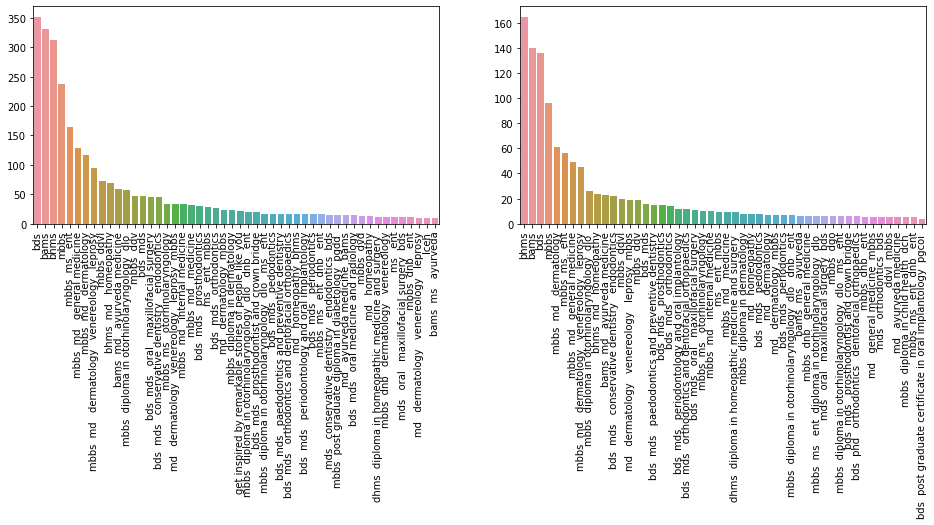

In [7]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Qualification', showing=50)

plt.subplot(122)
plot_feature_freq(test, 'Qualification', showing=50)

# Ordena as qualificações pelas mais frequentes.
qualifications, counts = np.unique(train['Qualification'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
qualifications = qualifications[p];

/home/nelson/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nelson/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


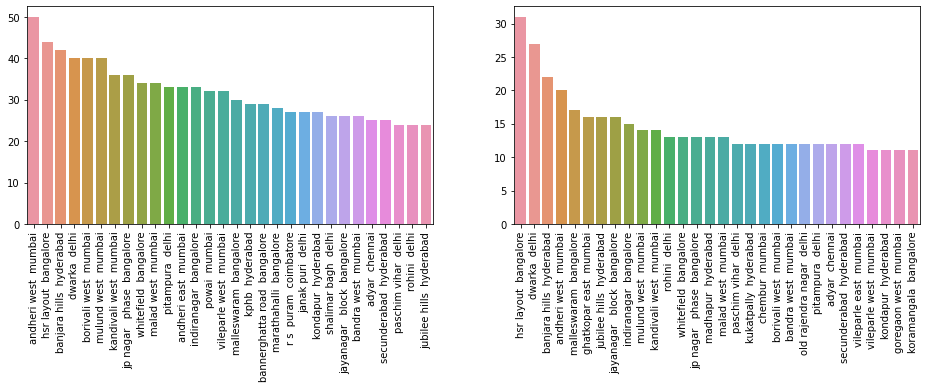

In [8]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Place')

plt.subplot(122)
plot_feature_freq(test, 'Place')

# Ordena os locais pelos mais frequentes.
places, counts = np.unique(train['Place'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
places = places[p];

/home/nelson/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nelson/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


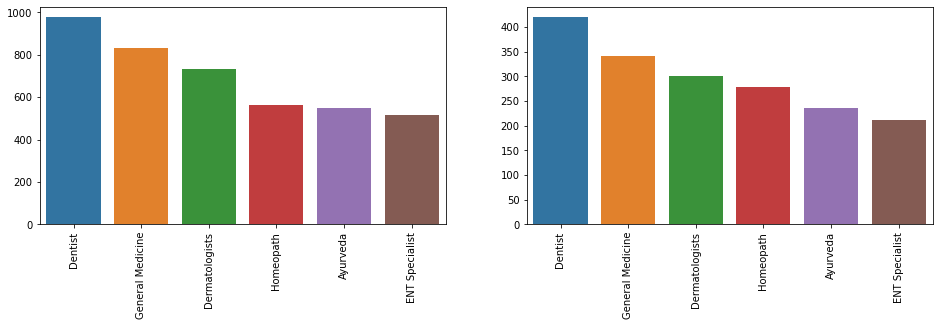

In [9]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Profile')

plt.subplot(122)
plot_feature_freq(test, 'Profile');

### Modelando um regressor de custo de consulta

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

Vamos codificar as características categóricas usando o one-hot encoding.
Entretanto, dado o alto número de ocorrências únicas, nós consideramos somente os 100 valores de maior frequência.

In [11]:
retained_qualif = qualifications[:100].tolist()
retained_places = places[:100].tolist()

qualif_places_enc = OneHotEncoder(categories=[retained_qualif, retained_places],
                                  handle_unknown='ignore')
profile_enc = OneHotEncoder()

Substituímos as células desconhecidas pelo valor mediano e normalizamos as características contínuas com o `StandardScaler`, o que os transforma em um conjunto de média 0, desvio padrão 1:

In [12]:
continuous_enc = make_pipeline(SimpleImputer(strategy='median'),
                               StandardScaler())

Compomos o pipeline, definindo quais colunas alimentarão quais codificadores, e aplicamos o transformador aos dados de entrada e aos valores de saída:

In [13]:
encoder = ColumnTransformer([
  ('q_pla', qualif_places_enc, ['Qualification', 'Place']),
  ('prof', profile_enc, ['Profile']),
  ('ex_ra', continuous_enc, ['Experience', 'Rating'])
])

train_e = encoder.fit_transform(train)
# Apesar da normalização ser imprescindível, ela está acontecendo no conjunto de teste com os parâmetros 
# que encontramos no cnjunto de treino. Logo, não estamos usando informação do teste, mas apenas adequando a
# faixa de valores para a faixa com a qual o modelo foi treinado.
test_e = encoder.transform(test)

fee_enc = StandardScaler()
ye_train = fee_enc.fit_transform(train[['Fees']].astype(float)).ravel()
ye_test = fee_enc.transform(test[['Fees']].astype(float)).ravel()

**Atividade (3 pts):** treine três ou mais regressores baseados em *máquina de vetor de suporte* com configurações distintas (Kernel, C, epislon) e reporte o seus respectivos erros quadráticos médios (MSE) sobre as porções de validação separadas. Discuta como os diversos parâmetros da SVR (Kernel, C, epislon) afetaram a qualidade do seus regressores. A busca pelos hiperparâmetros deve usar um método formal como GridSerach, RandomSearch, etc.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [14]:
# Imports
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor

from typing import Tuple, List, Dict
import pandas as pd

# Random seed fixed
rs = 1082141
np.random.seed(rs)
sns.set()

In [15]:
# Creating training params
c_range = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
gamma_range = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
epsilon_range = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
kernel_range = ["linear", "rbf", "sigmoid"]
cv = KFold(n_splits=5, shuffle=True, random_state=rs)

# Important functions to create customized scorer using MSE for grid search
def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print("MSE: %2.3f" % mse)
    return mse

def R2(y_true,y_pred):    
     r2 = r2_score(y_true, y_pred)
     print("R2: %2.3f" % r2)
     return r2

def two_score(y_true,y_pred):    
    score = MSE(y_true,y_pred)
    R2(y_true,y_pred) # Just printing R2
    return score

def two_scorer():
    return make_scorer(two_score, greater_is_better=False) # As we use MSE as comparison parameter, greater_is_better = False 

In [16]:
# Applying a grid search (This may take some time, around 20 minutes to run)
param_kernel = dict(C=c_range, gamma=gamma_range, epsilon=epsilon_range)

svr_kernel = SVR(kernel='sigmoid')

reg_kernel = GridSearchCV(estimator=svr_kernel, 
                          param_grid=param_kernel, 
                          cv=cv, 
                          scoring=two_scorer(), 
                          verbose=10)

reg_kernel.fit(X=train_e, y=ye_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5; 1/125] START C=0.001, epsilon=0.001, gamma=0.001.......................
MSE: 1.004
R2: -0.001
[CV 1/5; 1/125] END C=0.001, epsilon=0.001, gamma=0.001;, score=-1.004 total time=   0.6s
[CV 2/5; 1/125] START C=0.001, epsilon=0.001, gamma=0.001.......................
MSE: 0.949
R2: -0.006
[CV 2/5; 1/125] END C=0.001, epsilon=0.001, gamma=0.001;, score=-0.949 total time=   0.6s
[CV 3/5; 1/125] START C=0.001, epsilon=0.001, gamma=0.001.......................
MSE: 1.069
R2: -0.004
[CV 3/5; 1/125] END C=0.001, epsilon=0.001, gamma=0.001;, score=-1.069 total time=   0.6s
[CV 4/5; 1/125] START C=0.001, epsilon=0.001, gamma=0.001.......................
MSE: 0.955
R2: -0.000
[CV 4/5; 1/125] END C=0.001, epsilon=0.001, gamma=0.001;, score=-0.955 total time=   0.6s
[CV 5/5; 1/125] START C=0.001, epsilon=0.001, gamma=0.001.......................
MSE: 1.030
R2: 0.000
[CV 5/5; 1/125] END C=0.001, epsilon=0.001, gamma=0.001;, score

MSE: 0.928
R2: 0.028
[CV 4/5; 9/125] END C=0.001, epsilon=0.01, gamma=1.0;, score=-0.928 total time=   0.7s
[CV 5/5; 9/125] START C=0.001, epsilon=0.01, gamma=1.0..........................
MSE: 0.999
R2: 0.031
[CV 5/5; 9/125] END C=0.001, epsilon=0.01, gamma=1.0;, score=-0.999 total time=   0.7s
[CV 1/5; 10/125] START C=0.001, epsilon=0.01, gamma=10.0........................
MSE: 0.978
R2: 0.025
[CV 1/5; 10/125] END C=0.001, epsilon=0.01, gamma=10.0;, score=-0.978 total time=   0.7s
[CV 2/5; 10/125] START C=0.001, epsilon=0.01, gamma=10.0........................
MSE: 0.958
R2: -0.016
[CV 2/5; 10/125] END C=0.001, epsilon=0.01, gamma=10.0;, score=-0.958 total time=   0.7s
[CV 3/5; 10/125] START C=0.001, epsilon=0.01, gamma=10.0........................
MSE: 1.076
R2: -0.010
[CV 3/5; 10/125] END C=0.001, epsilon=0.01, gamma=10.0;, score=-1.076 total time=   0.7s
[CV 4/5; 10/125] START C=0.001, epsilon=0.01, gamma=10.0........................
MSE: 0.947
R2: 0.009
[CV 4/5; 10/125] END C=0.0

MSE: 0.937
R2: 0.006
[CV 2/5; 18/125] END C=0.001, epsilon=1.0, gamma=0.1;, score=-0.937 total time=   0.3s
[CV 3/5; 18/125] START C=0.001, epsilon=1.0, gamma=0.1..........................
MSE: 1.059
R2: 0.006
[CV 3/5; 18/125] END C=0.001, epsilon=1.0, gamma=0.1;, score=-1.059 total time=   0.3s
[CV 4/5; 18/125] START C=0.001, epsilon=1.0, gamma=0.1..........................
MSE: 0.948
R2: 0.007
[CV 4/5; 18/125] END C=0.001, epsilon=1.0, gamma=0.1;, score=-0.948 total time=   0.3s
[CV 5/5; 18/125] START C=0.001, epsilon=1.0, gamma=0.1..........................
MSE: 1.025
R2: 0.006
[CV 5/5; 18/125] END C=0.001, epsilon=1.0, gamma=0.1;, score=-1.025 total time=   0.3s
[CV 1/5; 19/125] START C=0.001, epsilon=1.0, gamma=1.0..........................
MSE: 0.986
R2: 0.017
[CV 1/5; 19/125] END C=0.001, epsilon=1.0, gamma=1.0;, score=-0.986 total time=   0.3s
[CV 2/5; 19/125] START C=0.001, epsilon=1.0, gamma=1.0..........................
MSE: 0.931
R2: 0.013
[CV 2/5; 19/125] END C=0.001, epsi

MSE: 1.029
R2: 0.001
[CV 5/5; 26/125] END C=0.01, epsilon=0.001, gamma=0.001;, score=-1.029 total time=   0.6s
[CV 1/5; 27/125] START C=0.01, epsilon=0.001, gamma=0.01........................
MSE: 0.989
R2: 0.014
[CV 1/5; 27/125] END C=0.01, epsilon=0.001, gamma=0.01;, score=-0.989 total time=   0.6s
[CV 2/5; 27/125] START C=0.01, epsilon=0.001, gamma=0.01........................
MSE: 0.939
R2: 0.004
[CV 2/5; 27/125] END C=0.01, epsilon=0.001, gamma=0.01;, score=-0.939 total time=   0.6s
[CV 3/5; 27/125] START C=0.01, epsilon=0.001, gamma=0.01........................
MSE: 1.057
R2: 0.008
[CV 3/5; 27/125] END C=0.01, epsilon=0.001, gamma=0.01;, score=-1.057 total time=   0.6s
[CV 4/5; 27/125] START C=0.01, epsilon=0.001, gamma=0.01........................
MSE: 0.942
R2: 0.013
[CV 4/5; 27/125] END C=0.01, epsilon=0.001, gamma=0.01;, score=-0.942 total time=   0.6s
[CV 5/5; 27/125] START C=0.01, epsilon=0.001, gamma=0.01........................
MSE: 1.016
R2: 0.014
[CV 5/5; 27/125] END C=

MSE: 15.972
R2: -13.990
[CV 3/5; 35/125] END C=0.01, epsilon=0.01, gamma=10.0;, score=-15.972 total time=   0.7s
[CV 4/5; 35/125] START C=0.01, epsilon=0.01, gamma=10.0.........................
MSE: 14.020
R2: -13.685
[CV 4/5; 35/125] END C=0.01, epsilon=0.01, gamma=10.0;, score=-14.020 total time=   0.7s
[CV 5/5; 35/125] START C=0.01, epsilon=0.01, gamma=10.0.........................
MSE: 15.053
R2: -13.608
[CV 5/5; 35/125] END C=0.01, epsilon=0.01, gamma=10.0;, score=-15.053 total time=   0.7s
[CV 1/5; 36/125] START C=0.01, epsilon=0.1, gamma=0.001.........................
MSE: 1.018
R2: -0.015
[CV 1/5; 36/125] END C=0.01, epsilon=0.1, gamma=0.001;, score=-1.018 total time=   0.6s
[CV 2/5; 36/125] START C=0.01, epsilon=0.1, gamma=0.001.........................
MSE: 0.973
R2: -0.032
[CV 2/5; 36/125] END C=0.01, epsilon=0.1, gamma=0.001;, score=-0.973 total time=   0.6s
[CV 3/5; 36/125] START C=0.01, epsilon=0.1, gamma=0.001.........................
MSE: 1.091
R2: -0.024
[CV 3/5; 36/12

MSE: 1.841
R2: -0.953
[CV 2/5; 44/125] END C=0.01, epsilon=1.0, gamma=1.0;, score=-1.841 total time=   0.4s
[CV 3/5; 44/125] START C=0.01, epsilon=1.0, gamma=1.0...........................
MSE: 1.866
R2: -0.752
[CV 3/5; 44/125] END C=0.01, epsilon=1.0, gamma=1.0;, score=-1.866 total time=   0.4s
[CV 4/5; 44/125] START C=0.01, epsilon=1.0, gamma=1.0...........................
MSE: 1.783
R2: -0.867
[CV 4/5; 44/125] END C=0.01, epsilon=1.0, gamma=1.0;, score=-1.783 total time=   0.4s
[CV 5/5; 44/125] START C=0.01, epsilon=1.0, gamma=1.0...........................
MSE: 1.880
R2: -0.825
[CV 5/5; 44/125] END C=0.01, epsilon=1.0, gamma=1.0;, score=-1.880 total time=   0.4s
[CV 1/5; 45/125] START C=0.01, epsilon=1.0, gamma=10.0..........................
MSE: 14.102
R2: -13.059
[CV 1/5; 45/125] END C=0.01, epsilon=1.0, gamma=10.0;, score=-14.102 total time=   0.6s
[CV 2/5; 45/125] START C=0.01, epsilon=1.0, gamma=10.0..........................
MSE: 14.791
R2: -14.685
[CV 2/5; 45/125] END C=0.01

MSE: 0.974
R2: 0.055
[CV 5/5; 52/125] END C=0.1, epsilon=0.001, gamma=0.01;, score=-0.974 total time=   0.6s
[CV 1/5; 53/125] START C=0.1, epsilon=0.001, gamma=0.1..........................
MSE: 1.926
R2: -0.920
[CV 1/5; 53/125] END C=0.1, epsilon=0.001, gamma=0.1;, score=-1.926 total time=   0.6s
[CV 2/5; 53/125] START C=0.1, epsilon=0.001, gamma=0.1..........................
MSE: 1.862
R2: -0.975
[CV 2/5; 53/125] END C=0.1, epsilon=0.001, gamma=0.1;, score=-1.862 total time=   0.6s
[CV 3/5; 53/125] START C=0.1, epsilon=0.001, gamma=0.1..........................
MSE: 2.518
R2: -1.364
[CV 3/5; 53/125] END C=0.1, epsilon=0.001, gamma=0.1;, score=-2.518 total time=   0.6s
[CV 4/5; 53/125] START C=0.1, epsilon=0.001, gamma=0.1..........................
MSE: 1.936
R2: -1.028
[CV 4/5; 53/125] END C=0.1, epsilon=0.001, gamma=0.1;, score=-1.936 total time=   0.6s
[CV 5/5; 53/125] START C=0.1, epsilon=0.001, gamma=0.1..........................
MSE: 1.669
R2: -0.619
[CV 5/5; 53/125] END C=0.1, 

MSE: 1.081
R2: -0.014
[CV 3/5; 61/125] END C=0.1, epsilon=0.1, gamma=0.001;, score=-1.081 total time=   0.6s
[CV 4/5; 61/125] START C=0.1, epsilon=0.1, gamma=0.001..........................
MSE: 0.958
R2: -0.004
[CV 4/5; 61/125] END C=0.1, epsilon=0.1, gamma=0.001;, score=-0.958 total time=   0.6s
[CV 5/5; 61/125] START C=0.1, epsilon=0.1, gamma=0.001..........................
MSE: 1.031
R2: -0.000
[CV 5/5; 61/125] END C=0.1, epsilon=0.1, gamma=0.001;, score=-1.031 total time=   0.6s
[CV 1/5; 62/125] START C=0.1, epsilon=0.1, gamma=0.01...........................
MSE: 0.946
R2: 0.057
[CV 1/5; 62/125] END C=0.1, epsilon=0.1, gamma=0.01;, score=-0.946 total time=   0.5s
[CV 2/5; 62/125] START C=0.1, epsilon=0.1, gamma=0.01...........................
MSE: 0.913
R2: 0.032
[CV 2/5; 62/125] END C=0.1, epsilon=0.1, gamma=0.01;, score=-0.913 total time=   0.5s
[CV 3/5; 62/125] START C=0.1, epsilon=0.1, gamma=0.01...........................
MSE: 1.028
R2: 0.035
[CV 3/5; 62/125] END C=0.1, epsil

MSE: 1523.667
R2: -1518.051
[CV 1/5; 70/125] END C=0.1, epsilon=1.0, gamma=10.0;, score=-1523.667 total time=   0.7s
[CV 2/5; 70/125] START C=0.1, epsilon=1.0, gamma=10.0...........................
MSE: 1521.491
R2: -1612.453
[CV 2/5; 70/125] END C=0.1, epsilon=1.0, gamma=10.0;, score=-1521.491 total time=   0.7s
[CV 3/5; 70/125] START C=0.1, epsilon=1.0, gamma=10.0...........................
MSE: 1564.954
R2: -1467.827
[CV 3/5; 70/125] END C=0.1, epsilon=1.0, gamma=10.0;, score=-1564.954 total time=   0.7s
[CV 4/5; 70/125] START C=0.1, epsilon=1.0, gamma=10.0...........................
MSE: 1511.286
R2: -1581.911
[CV 4/5; 70/125] END C=0.1, epsilon=1.0, gamma=10.0;, score=-1511.286 total time=   0.7s
[CV 5/5; 70/125] START C=0.1, epsilon=1.0, gamma=10.0...........................
MSE: 1453.562
R2: -1409.559
[CV 5/5; 70/125] END C=0.1, epsilon=1.0, gamma=10.0;, score=-1453.562 total time=   0.7s
[CV 1/5; 71/125] START C=0.1, epsilon=10.0, gamma=0.001.........................
MSE: 1.838

MSE: 281.750
R2: -294.103
[CV 4/5; 78/125] END C=1.0, epsilon=0.001, gamma=0.1;, score=-281.750 total time=   0.6s
[CV 5/5; 78/125] START C=1.0, epsilon=0.001, gamma=0.1..........................
MSE: 180.910
R2: -174.558
[CV 5/5; 78/125] END C=1.0, epsilon=0.001, gamma=0.1;, score=-180.910 total time=   0.6s
[CV 1/5; 79/125] START C=1.0, epsilon=0.001, gamma=1.0..........................
MSE: 24973.582
R2: -24896.918
[CV 1/5; 79/125] END C=1.0, epsilon=0.001, gamma=1.0;, score=-24973.582 total time=   0.7s
[CV 2/5; 79/125] START C=1.0, epsilon=0.001, gamma=1.0..........................
MSE: 25192.182
R2: -26713.843
[CV 2/5; 79/125] END C=1.0, epsilon=0.001, gamma=1.0;, score=-25192.182 total time=   0.7s
[CV 3/5; 79/125] START C=1.0, epsilon=0.001, gamma=1.0..........................
MSE: 27223.473
R2: -25550.288
[CV 3/5; 79/125] END C=1.0, epsilon=0.001, gamma=1.0;, score=-27223.473 total time=   0.7s
[CV 4/5; 79/125] START C=1.0, epsilon=0.001, gamma=1.0..........................
MS

MSE: 0.883
R2: 0.120
[CV 1/5; 87/125] END C=1.0, epsilon=0.1, gamma=0.01;, score=-0.883 total time=   0.5s
[CV 2/5; 87/125] START C=1.0, epsilon=0.1, gamma=0.01...........................
MSE: 0.847
R2: 0.101
[CV 2/5; 87/125] END C=1.0, epsilon=0.1, gamma=0.01;, score=-0.847 total time=   0.5s
[CV 3/5; 87/125] START C=1.0, epsilon=0.1, gamma=0.01...........................
MSE: 0.957
R2: 0.102
[CV 3/5; 87/125] END C=1.0, epsilon=0.1, gamma=0.01;, score=-0.957 total time=   0.5s
[CV 4/5; 87/125] START C=1.0, epsilon=0.1, gamma=0.01...........................
MSE: 0.860
R2: 0.099
[CV 4/5; 87/125] END C=1.0, epsilon=0.1, gamma=0.01;, score=-0.860 total time=   0.5s
[CV 5/5; 87/125] START C=1.0, epsilon=0.1, gamma=0.01...........................
MSE: 0.909
R2: 0.118
[CV 5/5; 87/125] END C=1.0, epsilon=0.1, gamma=0.01;, score=-0.909 total time=   0.5s
[CV 1/5; 88/125] START C=1.0, epsilon=0.1, gamma=0.1............................
MSE: 342.016
R2: -339.980
[CV 1/5; 88/125] END C=1.0, epsilo

MSE: 155558.424
R2: -146002.347
[CV 3/5; 95/125] END C=1.0, epsilon=1.0, gamma=10.0;, score=-155558.424 total time=   0.7s
[CV 4/5; 95/125] START C=1.0, epsilon=1.0, gamma=10.0...........................
MSE: 83459.262
R2: -87413.660
[CV 4/5; 95/125] END C=1.0, epsilon=1.0, gamma=10.0;, score=-83459.262 total time=   0.7s
[CV 5/5; 95/125] START C=1.0, epsilon=1.0, gamma=10.0...........................
MSE: 142615.991
R2: -138395.828
[CV 5/5; 95/125] END C=1.0, epsilon=1.0, gamma=10.0;, score=-142615.991 total time=   0.7s
[CV 1/5; 96/125] START C=1.0, epsilon=10.0, gamma=0.001.........................
MSE: 1.838
R2: -0.832
[CV 1/5; 96/125] END C=1.0, epsilon=10.0, gamma=0.001;, score=-1.838 total time=   0.0s
[CV 2/5; 96/125] START C=1.0, epsilon=10.0, gamma=0.001.........................
MSE: 1.790
R2: -0.898
[CV 2/5; 96/125] END C=1.0, epsilon=10.0, gamma=0.001;, score=-1.790 total time=   0.0s
[CV 3/5; 96/125] START C=1.0, epsilon=10.0, gamma=0.001.........................
MSE: 1.84

MSE: 2512244.442
R2: -2504631.927
[CV 1/5; 104/125] END C=10.0, epsilon=0.001, gamma=1.0;, score=-2512244.442 total time=   0.7s
[CV 2/5; 104/125] START C=10.0, epsilon=0.001, gamma=1.0........................
MSE: 2499810.084
R2: -2650902.200
[CV 2/5; 104/125] END C=10.0, epsilon=0.001, gamma=1.0;, score=-2499810.084 total time=   0.7s
[CV 3/5; 104/125] START C=10.0, epsilon=0.001, gamma=1.0........................
MSE: 2714711.600
R2: -2547961.170
[CV 3/5; 104/125] END C=10.0, epsilon=0.001, gamma=1.0;, score=-2714711.600 total time=   0.7s
[CV 4/5; 104/125] START C=10.0, epsilon=0.001, gamma=1.0........................
MSE: 2706042.436
R2: -2834289.341
[CV 4/5; 104/125] END C=10.0, epsilon=0.001, gamma=1.0;, score=-2706042.436 total time=   0.7s
[CV 5/5; 104/125] START C=10.0, epsilon=0.001, gamma=1.0........................
MSE: 2559973.236
R2: -2484237.787
[CV 5/5; 104/125] END C=10.0, epsilon=0.001, gamma=1.0;, score=-2559973.236 total time=   0.7s
[CV 1/5; 105/125] START C=10.0,

MSE: 2.210
R2: -1.344
[CV 2/5; 112/125] END C=10.0, epsilon=0.1, gamma=0.01;, score=-2.210 total time=   0.6s
[CV 3/5; 112/125] START C=10.0, epsilon=0.1, gamma=0.01.........................
MSE: 9.882
R2: -8.275
[CV 3/5; 112/125] END C=10.0, epsilon=0.1, gamma=0.01;, score=-9.882 total time=   0.6s
[CV 4/5; 112/125] START C=10.0, epsilon=0.1, gamma=0.01.........................
MSE: 1.974
R2: -1.067
[CV 4/5; 112/125] END C=10.0, epsilon=0.1, gamma=0.01;, score=-1.974 total time=   0.6s
[CV 5/5; 112/125] START C=10.0, epsilon=0.1, gamma=0.01.........................
MSE: 1.508
R2: -0.464
[CV 5/5; 112/125] END C=10.0, epsilon=0.1, gamma=0.01;, score=-1.508 total time=   0.6s
[CV 1/5; 113/125] START C=10.0, epsilon=0.1, gamma=0.1..........................
MSE: 40478.438
R2: -40354.797
[CV 1/5; 113/125] END C=10.0, epsilon=0.1, gamma=0.1;, score=-40478.438 total time=   0.7s
[CV 2/5; 113/125] START C=10.0, epsilon=0.1, gamma=0.1..........................
MSE: 38169.641
R2: -40475.685
[CV 

MSE: 16285540.235
R2: -15285210.306
[CV 3/5; 120/125] END C=10.0, epsilon=1.0, gamma=10.0;, score=-16285540.235 total time=   0.7s
[CV 4/5; 120/125] START C=10.0, epsilon=1.0, gamma=10.0.........................
MSE: 15095412.970
R2: -15810831.309
[CV 4/5; 120/125] END C=10.0, epsilon=1.0, gamma=10.0;, score=-15095412.970 total time=   0.7s
[CV 5/5; 120/125] START C=10.0, epsilon=1.0, gamma=10.0.........................
MSE: 14457759.591
R2: -14030039.096
[CV 5/5; 120/125] END C=10.0, epsilon=1.0, gamma=10.0;, score=-14457759.591 total time=   0.7s
[CV 1/5; 121/125] START C=10.0, epsilon=10.0, gamma=0.001.......................
MSE: 1.838
R2: -0.832
[CV 1/5; 121/125] END C=10.0, epsilon=10.0, gamma=0.001;, score=-1.838 total time=   0.0s
[CV 2/5; 121/125] START C=10.0, epsilon=10.0, gamma=0.001.......................
MSE: 1.790
R2: -0.898
[CV 2/5; 121/125] END C=10.0, epsilon=10.0, gamma=0.001;, score=-1.790 total time=   0.0s
[CV 3/5; 121/125] START C=10.0, epsilon=10.0, gamma=0.001..

GridSearchCV(cv=KFold(n_splits=5, random_state=1082141, shuffle=True),
             estimator=SVR(kernel='sigmoid'),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'epsilon': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 10.0]},
             scoring=make_scorer(two_score, greater_is_better=False),
             verbose=10)

In [17]:
print(reg_kernel.best_estimator_)
best_reg_kernel = reg_kernel.best_estimator_

SVR(gamma=0.01, kernel='sigmoid')


In [18]:
reg_kernel.best_params_['kernel'] = 'sigmoid'

In [19]:
# Applying a grid search (This may take some time, around 20 minutes to run)
param_C = dict(kernel=kernel_range, gamma=gamma_range, epsilon=epsilon_range)

svr_C = SVR(C=0.01)

reg_C = GridSearchCV(estimator=svr_C, 
                       param_grid=param_C, 
                       cv=cv, 
                       scoring=two_scorer(), 
                       verbose=10)


reg_C.fit(X=train_e, y=ye_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5; 1/75] START epsilon=0.001, gamma=0.001, kernel=linear..................
MSE: 0.886
R2: 0.117
[CV 1/5; 1/75] END epsilon=0.001, gamma=0.001, kernel=linear;, score=-0.886 total time=   0.4s
[CV 2/5; 1/75] START epsilon=0.001, gamma=0.001, kernel=linear..................
MSE: 0.848
R2: 0.101
[CV 2/5; 1/75] END epsilon=0.001, gamma=0.001, kernel=linear;, score=-0.848 total time=   0.4s
[CV 3/5; 1/75] START epsilon=0.001, gamma=0.001, kernel=linear..................
MSE: 0.963
R2: 0.096
[CV 3/5; 1/75] END epsilon=0.001, gamma=0.001, kernel=linear;, score=-0.963 total time=   0.4s
[CV 4/5; 1/75] START epsilon=0.001, gamma=0.001, kernel=linear..................
MSE: 0.858
R2: 0.101
[CV 4/5; 1/75] END epsilon=0.001, gamma=0.001, kernel=linear;, score=-0.858 total time=   0.4s
[CV 5/5; 1/75] START epsilon=0.001, gamma=0.001, kernel=linear..................
MSE: 0.911
R2: 0.116
[CV 5/5; 1/75] END epsilon=0.001, gamma=0.001, k

MSE: 1.030
R2: 0.033
[CV 3/5; 9/75] END epsilon=0.001, gamma=0.1, kernel=sigmoid;, score=-1.030 total time=   0.6s
[CV 4/5; 9/75] START epsilon=0.001, gamma=0.1, kernel=sigmoid...................
MSE: 0.909
R2: 0.048
[CV 4/5; 9/75] END epsilon=0.001, gamma=0.1, kernel=sigmoid;, score=-0.909 total time=   0.6s
[CV 5/5; 9/75] START epsilon=0.001, gamma=0.1, kernel=sigmoid...................
MSE: 0.973
R2: 0.056
[CV 5/5; 9/75] END epsilon=0.001, gamma=0.1, kernel=sigmoid;, score=-0.973 total time=   0.6s
[CV 1/5; 10/75] START epsilon=0.001, gamma=1.0, kernel=linear...................
MSE: 0.886
R2: 0.117
[CV 1/5; 10/75] END epsilon=0.001, gamma=1.0, kernel=linear;, score=-0.886 total time=   0.4s
[CV 2/5; 10/75] START epsilon=0.001, gamma=1.0, kernel=linear...................
MSE: 0.848
R2: 0.101
[CV 2/5; 10/75] END epsilon=0.001, gamma=1.0, kernel=linear;, score=-0.848 total time=   0.4s
[CV 3/5; 10/75] START epsilon=0.001, gamma=1.0, kernel=linear...................
MSE: 0.963
R2: 0.096

MSE: 1.028
R2: 0.003
[CV 5/5; 17/75] END epsilon=0.01, gamma=0.001, kernel=rbf;, score=-1.028 total time=   0.5s
[CV 1/5; 18/75] START epsilon=0.01, gamma=0.001, kernel=sigmoid.................
MSE: 1.003
R2: 0.000
[CV 1/5; 18/75] END epsilon=0.01, gamma=0.001, kernel=sigmoid;, score=-1.003 total time=   0.6s
[CV 2/5; 18/75] START epsilon=0.01, gamma=0.001, kernel=sigmoid.................
MSE: 0.949
R2: -0.006
[CV 2/5; 18/75] END epsilon=0.01, gamma=0.001, kernel=sigmoid;, score=-0.949 total time=   0.6s
[CV 3/5; 18/75] START epsilon=0.01, gamma=0.001, kernel=sigmoid.................
MSE: 1.069
R2: -0.003
[CV 3/5; 18/75] END epsilon=0.01, gamma=0.001, kernel=sigmoid;, score=-1.069 total time=   0.6s
[CV 4/5; 18/75] START epsilon=0.01, gamma=0.001, kernel=sigmoid.................
MSE: 0.954
R2: 0.001
[CV 4/5; 18/75] END epsilon=0.01, gamma=0.001, kernel=sigmoid;, score=-0.954 total time=   0.6s
[CV 5/5; 18/75] START epsilon=0.01, gamma=0.001, kernel=sigmoid.................
MSE: 1.029
R

MSE: 0.913
R2: 0.031
[CV 2/5; 26/75] END epsilon=0.01, gamma=1.0, kernel=rbf;, score=-0.913 total time=   0.5s
[CV 3/5; 26/75] START epsilon=0.01, gamma=1.0, kernel=rbf.......................
MSE: 1.026
R2: 0.037
[CV 3/5; 26/75] END epsilon=0.01, gamma=1.0, kernel=rbf;, score=-1.026 total time=   0.5s
[CV 4/5; 26/75] START epsilon=0.01, gamma=1.0, kernel=rbf.......................
MSE: 0.894
R2: 0.063
[CV 4/5; 26/75] END epsilon=0.01, gamma=1.0, kernel=rbf;, score=-0.894 total time=   0.5s
[CV 5/5; 26/75] START epsilon=0.01, gamma=1.0, kernel=rbf.......................
MSE: 0.979
R2: 0.050
[CV 5/5; 26/75] END epsilon=0.01, gamma=1.0, kernel=rbf;, score=-0.979 total time=   0.5s
[CV 1/5; 27/75] START epsilon=0.01, gamma=1.0, kernel=sigmoid...................
MSE: 2.461
R2: -1.454
[CV 1/5; 27/75] END epsilon=0.01, gamma=1.0, kernel=sigmoid;, score=-2.461 total time=   0.7s
[CV 2/5; 27/75] START epsilon=0.01, gamma=1.0, kernel=sigmoid...................
MSE: 2.578
R2: -1.734
[CV 2/5; 27/7

MSE: 0.857
R2: 0.102
[CV 4/5; 34/75] END epsilon=0.1, gamma=0.01, kernel=linear;, score=-0.857 total time=   0.4s
[CV 5/5; 34/75] START epsilon=0.1, gamma=0.01, kernel=linear....................
MSE: 0.908
R2: 0.118
[CV 5/5; 34/75] END epsilon=0.1, gamma=0.01, kernel=linear;, score=-0.908 total time=   0.4s
[CV 1/5; 35/75] START epsilon=0.1, gamma=0.01, kernel=rbf.......................
MSE: 0.996
R2: 0.007
[CV 1/5; 35/75] END epsilon=0.1, gamma=0.01, kernel=rbf;, score=-0.996 total time=   0.5s
[CV 2/5; 35/75] START epsilon=0.1, gamma=0.01, kernel=rbf.......................
MSE: 0.957
R2: -0.015
[CV 2/5; 35/75] END epsilon=0.1, gamma=0.01, kernel=rbf;, score=-0.957 total time=   0.5s
[CV 3/5; 35/75] START epsilon=0.1, gamma=0.01, kernel=rbf.......................
MSE: 1.070
R2: -0.005
[CV 3/5; 35/75] END epsilon=0.1, gamma=0.01, kernel=rbf;, score=-1.070 total time=   0.5s
[CV 4/5; 35/75] START epsilon=0.1, gamma=0.01, kernel=rbf.......................
MSE: 0.950
R2: 0.005
[CV 4/5; 35

MSE: 0.849
R2: 0.099
[CV 2/5; 43/75] END epsilon=0.1, gamma=10.0, kernel=linear;, score=-0.849 total time=   0.4s
[CV 3/5; 43/75] START epsilon=0.1, gamma=10.0, kernel=linear....................
MSE: 0.961
R2: 0.098
[CV 3/5; 43/75] END epsilon=0.1, gamma=10.0, kernel=linear;, score=-0.961 total time=   0.4s
[CV 4/5; 43/75] START epsilon=0.1, gamma=10.0, kernel=linear....................
MSE: 0.857
R2: 0.102
[CV 4/5; 43/75] END epsilon=0.1, gamma=10.0, kernel=linear;, score=-0.857 total time=   0.4s
[CV 5/5; 43/75] START epsilon=0.1, gamma=10.0, kernel=linear....................
MSE: 0.908
R2: 0.118
[CV 5/5; 43/75] END epsilon=0.1, gamma=10.0, kernel=linear;, score=-0.908 total time=   0.4s
[CV 1/5; 44/75] START epsilon=0.1, gamma=10.0, kernel=rbf.......................
MSE: 1.011
R2: -0.008
[CV 1/5; 44/75] END epsilon=0.1, gamma=10.0, kernel=rbf;, score=-1.011 total time=   0.6s
[CV 2/5; 44/75] START epsilon=0.1, gamma=10.0, kernel=rbf.......................
MSE: 0.966
R2: -0.024
[CV 2

MSE: 0.948
R2: 0.008
[CV 4/5; 51/75] END epsilon=1.0, gamma=0.01, kernel=sigmoid;, score=-0.948 total time=   0.3s
[CV 5/5; 51/75] START epsilon=1.0, gamma=0.01, kernel=sigmoid...................
MSE: 1.024
R2: 0.006
[CV 5/5; 51/75] END epsilon=1.0, gamma=0.01, kernel=sigmoid;, score=-1.024 total time=   0.3s
[CV 1/5; 52/75] START epsilon=1.0, gamma=0.1, kernel=linear.....................
MSE: 0.941
R2: 0.062
[CV 1/5; 52/75] END epsilon=1.0, gamma=0.1, kernel=linear;, score=-0.941 total time=   0.2s
[CV 2/5; 52/75] START epsilon=1.0, gamma=0.1, kernel=linear.....................
MSE: 0.882
R2: 0.065
[CV 2/5; 52/75] END epsilon=1.0, gamma=0.1, kernel=linear;, score=-0.882 total time=   0.2s
[CV 3/5; 52/75] START epsilon=1.0, gamma=0.1, kernel=linear.....................
MSE: 1.011
R2: 0.051
[CV 3/5; 52/75] END epsilon=1.0, gamma=0.1, kernel=linear;, score=-1.011 total time=   0.2s
[CV 4/5; 52/75] START epsilon=1.0, gamma=0.1, kernel=linear.....................
MSE: 0.898
R2: 0.060
[CV 4

MSE: 14.791
R2: -14.685
[CV 2/5; 60/75] END epsilon=1.0, gamma=10.0, kernel=sigmoid;, score=-14.791 total time=   0.6s
[CV 3/5; 60/75] START epsilon=1.0, gamma=10.0, kernel=sigmoid...................
MSE: 14.960
R2: -13.041
[CV 3/5; 60/75] END epsilon=1.0, gamma=10.0, kernel=sigmoid;, score=-14.960 total time=   0.6s
[CV 4/5; 60/75] START epsilon=1.0, gamma=10.0, kernel=sigmoid...................
MSE: 12.781
R2: -12.387
[CV 4/5; 60/75] END epsilon=1.0, gamma=10.0, kernel=sigmoid;, score=-12.781 total time=   0.6s
[CV 5/5; 60/75] START epsilon=1.0, gamma=10.0, kernel=sigmoid...................
MSE: 13.644
R2: -12.240
[CV 5/5; 60/75] END epsilon=1.0, gamma=10.0, kernel=sigmoid;, score=-13.644 total time=   0.6s
[CV 1/5; 61/75] START epsilon=10.0, gamma=0.001, kernel=linear..................
MSE: 1.838
R2: -0.832
[CV 1/5; 61/75] END epsilon=10.0, gamma=0.001, kernel=linear;, score=-1.838 total time=   0.0s
[CV 2/5; 61/75] START epsilon=10.0, gamma=0.001, kernel=linear..................
MS

GridSearchCV(cv=KFold(n_splits=5, random_state=1082141, shuffle=True),
             estimator=SVR(C=0.01),
             param_grid={'epsilon': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             scoring=make_scorer(two_score, greater_is_better=False),
             verbose=10)

In [20]:
print(reg_C.best_estimator_)
best_reg_C = reg_C.best_estimator_

SVR(C=0.01, gamma=0.001, kernel='linear')


In [21]:
reg_C.best_params_['C'] = 0.01

In [22]:
# Applying a grid search (This may take some time, around 20 minutes to run)
param_eps = dict(C=c_range, gamma=gamma_range, kernel=kernel_range)

svr_eps = SVR(epsilon=0.5)

reg_eps = GridSearchCV(estimator=svr_eps, 
                       param_grid=param_eps, 
                       cv=cv, 
                       scoring=two_scorer(), 
                       verbose=10)

reg_eps.fit(X=train_e, y=ye_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5; 1/75] START C=0.001, gamma=0.001, kernel=linear........................
MSE: 0.939
R2: 0.064
[CV 1/5; 1/75] END C=0.001, gamma=0.001, kernel=linear;, score=-0.939 total time=   0.3s
[CV 2/5; 1/75] START C=0.001, gamma=0.001, kernel=linear........................
MSE: 0.898
R2: 0.048
[CV 2/5; 1/75] END C=0.001, gamma=0.001, kernel=linear;, score=-0.898 total time=   0.3s
[CV 3/5; 1/75] START C=0.001, gamma=0.001, kernel=linear........................
MSE: 1.016
R2: 0.047
[CV 3/5; 1/75] END C=0.001, gamma=0.001, kernel=linear;, score=-1.016 total time=   0.3s
[CV 4/5; 1/75] START C=0.001, gamma=0.001, kernel=linear........................
MSE: 0.899
R2: 0.059
[CV 4/5; 1/75] END C=0.001, gamma=0.001, kernel=linear;, score=-0.899 total time=   0.3s
[CV 5/5; 1/75] START C=0.001, gamma=0.001, kernel=linear........................
MSE: 0.968
R2: 0.060
[CV 5/5; 1/75] END C=0.001, gamma=0.001, kernel=linear;, score=-0.968 to

MSE: 0.946
R2: 0.009
[CV 4/5; 9/75] END C=0.001, gamma=0.1, kernel=sigmoid;, score=-0.946 total time=   0.4s
[CV 5/5; 9/75] START C=0.001, gamma=0.1, kernel=sigmoid.........................
MSE: 1.021
R2: 0.010
[CV 5/5; 9/75] END C=0.001, gamma=0.1, kernel=sigmoid;, score=-1.021 total time=   0.4s
[CV 1/5; 10/75] START C=0.001, gamma=1.0, kernel=linear.........................
MSE: 0.939
R2: 0.064
[CV 1/5; 10/75] END C=0.001, gamma=1.0, kernel=linear;, score=-0.939 total time=   0.3s
[CV 2/5; 10/75] START C=0.001, gamma=1.0, kernel=linear.........................
MSE: 0.898
R2: 0.048
[CV 2/5; 10/75] END C=0.001, gamma=1.0, kernel=linear;, score=-0.898 total time=   0.3s
[CV 3/5; 10/75] START C=0.001, gamma=1.0, kernel=linear.........................
MSE: 1.016
R2: 0.047
[CV 3/5; 10/75] END C=0.001, gamma=1.0, kernel=linear;, score=-1.016 total time=   0.3s
[CV 4/5; 10/75] START C=0.001, gamma=1.0, kernel=linear.........................
MSE: 0.899
R2: 0.059
[CV 4/5; 10/75] END C=0.001, 

MSE: 1.071
R2: -0.006
[CV 3/5; 18/75] END C=0.01, gamma=0.001, kernel=sigmoid;, score=-1.071 total time=   0.4s
[CV 4/5; 18/75] START C=0.01, gamma=0.001, kernel=sigmoid.......................
MSE: 0.955
R2: -0.001
[CV 4/5; 18/75] END C=0.01, gamma=0.001, kernel=sigmoid;, score=-0.955 total time=   0.4s
[CV 5/5; 18/75] START C=0.01, gamma=0.001, kernel=sigmoid.......................
MSE: 1.030
R2: 0.000
[CV 5/5; 18/75] END C=0.01, gamma=0.001, kernel=sigmoid;, score=-1.030 total time=   0.4s
[CV 1/5; 19/75] START C=0.01, gamma=0.01, kernel=linear.........................
MSE: 0.872
R2: 0.131
[CV 1/5; 19/75] END C=0.01, gamma=0.01, kernel=linear;, score=-0.872 total time=   0.3s
[CV 2/5; 19/75] START C=0.01, gamma=0.01, kernel=linear.........................
MSE: 0.826
R2: 0.124
[CV 2/5; 19/75] END C=0.01, gamma=0.01, kernel=linear;, score=-0.826 total time=   0.3s
[CV 3/5; 19/75] START C=0.01, gamma=0.01, kernel=linear.........................
MSE: 0.942
R2: 0.116
[CV 3/5; 19/75] END C

MSE: 2.314
R2: -1.454
[CV 2/5; 27/75] END C=0.01, gamma=1.0, kernel=sigmoid;, score=-2.314 total time=   0.6s
[CV 3/5; 27/75] START C=0.01, gamma=1.0, kernel=sigmoid.........................
MSE: 2.449
R2: -1.298
[CV 3/5; 27/75] END C=0.01, gamma=1.0, kernel=sigmoid;, score=-2.449 total time=   0.6s
[CV 4/5; 27/75] START C=0.01, gamma=1.0, kernel=sigmoid.........................
MSE: 2.341
R2: -1.452
[CV 4/5; 27/75] END C=0.01, gamma=1.0, kernel=sigmoid;, score=-2.341 total time=   0.6s
[CV 5/5; 27/75] START C=0.01, gamma=1.0, kernel=sigmoid.........................
MSE: 2.377
R2: -1.306
[CV 5/5; 27/75] END C=0.01, gamma=1.0, kernel=sigmoid;, score=-2.377 total time=   0.6s
[CV 1/5; 28/75] START C=0.01, gamma=10.0, kernel=linear.........................
MSE: 0.872
R2: 0.131
[CV 1/5; 28/75] END C=0.01, gamma=10.0, kernel=linear;, score=-0.872 total time=   0.3s
[CV 2/5; 28/75] START C=0.01, gamma=10.0, kernel=linear.........................
MSE: 0.826
R2: 0.124
[CV 2/5; 28/75] END C=0.0

MSE: 0.939
R2: 0.064
[CV 1/5; 36/75] END C=0.1, gamma=0.01, kernel=sigmoid;, score=-0.939 total time=   0.4s
[CV 2/5; 36/75] START C=0.1, gamma=0.01, kernel=sigmoid.........................
MSE: 0.897
R2: 0.048
[CV 2/5; 36/75] END C=0.1, gamma=0.01, kernel=sigmoid;, score=-0.897 total time=   0.4s
[CV 3/5; 36/75] START C=0.1, gamma=0.01, kernel=sigmoid.........................
MSE: 1.015
R2: 0.047
[CV 3/5; 36/75] END C=0.1, gamma=0.01, kernel=sigmoid;, score=-1.015 total time=   0.4s
[CV 4/5; 36/75] START C=0.1, gamma=0.01, kernel=sigmoid.........................
MSE: 0.899
R2: 0.059
[CV 4/5; 36/75] END C=0.1, gamma=0.01, kernel=sigmoid;, score=-0.899 total time=   0.4s
[CV 5/5; 36/75] START C=0.1, gamma=0.01, kernel=sigmoid.........................
MSE: 0.968
R2: 0.060
[CV 5/5; 36/75] END C=0.1, gamma=0.01, kernel=sigmoid;, score=-0.968 total time=   0.4s
[CV 1/5; 37/75] START C=0.1, gamma=0.1, kernel=linear...........................
MSE: 0.806
R2: 0.197
[CV 1/5; 37/75] END C=0.1, ga

MSE: 0.989
R2: 0.040
[CV 5/5; 44/75] END C=0.1, gamma=10.0, kernel=rbf;, score=-0.989 total time=   0.5s
[CV 1/5; 45/75] START C=0.1, gamma=10.0, kernel=sigmoid.........................
MSE: 1524.772
R2: -1519.152
[CV 1/5; 45/75] END C=0.1, gamma=10.0, kernel=sigmoid;, score=-1524.772 total time=   0.7s
[CV 2/5; 45/75] START C=0.1, gamma=10.0, kernel=sigmoid.........................
MSE: 1524.224
R2: -1615.351
[CV 2/5; 45/75] END C=0.1, gamma=10.0, kernel=sigmoid;, score=-1524.224 total time=   0.7s
[CV 3/5; 45/75] START C=0.1, gamma=10.0, kernel=sigmoid.........................
MSE: 1566.934
R2: -1469.686
[CV 3/5; 45/75] END C=0.1, gamma=10.0, kernel=sigmoid;, score=-1566.934 total time=   0.7s
[CV 4/5; 45/75] START C=0.1, gamma=10.0, kernel=sigmoid.........................
MSE: 1511.511
R2: -1582.146
[CV 4/5; 45/75] END C=0.1, gamma=10.0, kernel=sigmoid;, score=-1511.511 total time=   0.7s
[CV 5/5; 45/75] START C=0.1, gamma=10.0, kernel=sigmoid.........................
MSE: 1453.537


MSE: 0.798
R2: 0.164
[CV 4/5; 53/75] END C=1.0, gamma=0.1, kernel=rbf;, score=-0.798 total time=   0.4s
[CV 5/5; 53/75] START C=1.0, gamma=0.1, kernel=rbf..............................
MSE: 0.863
R2: 0.163
[CV 5/5; 53/75] END C=1.0, gamma=0.1, kernel=rbf;, score=-0.863 total time=   0.4s
[CV 1/5; 54/75] START C=1.0, gamma=0.1, kernel=sigmoid..........................
MSE: 337.665
R2: -335.642
[CV 1/5; 54/75] END C=1.0, gamma=0.1, kernel=sigmoid;, score=-337.665 total time=   0.7s
[CV 2/5; 54/75] START C=1.0, gamma=0.1, kernel=sigmoid..........................
MSE: 355.385
R2: -375.866
[CV 2/5; 54/75] END C=1.0, gamma=0.1, kernel=sigmoid;, score=-355.385 total time=   0.6s
[CV 3/5; 54/75] START C=1.0, gamma=0.1, kernel=sigmoid..........................
MSE: 500.159
R2: -468.437
[CV 3/5; 54/75] END C=1.0, gamma=0.1, kernel=sigmoid;, score=-500.159 total time=   0.6s
[CV 4/5; 54/75] START C=1.0, gamma=0.1, kernel=sigmoid..........................
MSE: 278.088
R2: -290.267
[CV 4/5; 54/75] 

MSE: 0.809
R2: 0.142
[CV 2/5; 62/75] END C=10.0, gamma=0.001, kernel=rbf;, score=-0.809 total time=   0.3s
[CV 3/5; 62/75] START C=10.0, gamma=0.001, kernel=rbf...........................
MSE: 0.930
R2: 0.127
[CV 3/5; 62/75] END C=10.0, gamma=0.001, kernel=rbf;, score=-0.930 total time=   0.3s
[CV 4/5; 62/75] START C=10.0, gamma=0.001, kernel=rbf...........................
MSE: 0.826
R2: 0.135
[CV 4/5; 62/75] END C=10.0, gamma=0.001, kernel=rbf;, score=-0.826 total time=   0.3s
[CV 5/5; 62/75] START C=10.0, gamma=0.001, kernel=rbf...........................
MSE: 0.891
R2: 0.135
[CV 5/5; 62/75] END C=10.0, gamma=0.001, kernel=rbf;, score=-0.891 total time=   0.3s
[CV 1/5; 63/75] START C=10.0, gamma=0.001, kernel=sigmoid.......................
MSE: 0.872
R2: 0.131
[CV 1/5; 63/75] END C=10.0, gamma=0.001, kernel=sigmoid;, score=-0.872 total time=   0.4s
[CV 2/5; 63/75] START C=10.0, gamma=0.001, kernel=sigmoid.......................
MSE: 0.826
R2: 0.124
[CV 2/5; 63/75] END C=10.0, gamma=0

MSE: 0.898
R2: 0.129
[CV 5/5; 70/75] END C=10.0, gamma=1.0, kernel=linear;, score=-0.898 total time=   1.8s
[CV 1/5; 71/75] START C=10.0, gamma=1.0, kernel=rbf.............................
MSE: 0.976
R2: 0.027
[CV 1/5; 71/75] END C=10.0, gamma=1.0, kernel=rbf;, score=-0.976 total time=   0.5s
[CV 2/5; 71/75] START C=10.0, gamma=1.0, kernel=rbf.............................
MSE: 0.881
R2: 0.066
[CV 2/5; 71/75] END C=10.0, gamma=1.0, kernel=rbf;, score=-0.881 total time=   0.5s
[CV 3/5; 71/75] START C=10.0, gamma=1.0, kernel=rbf.............................
MSE: 0.959
R2: 0.100
[CV 3/5; 71/75] END C=10.0, gamma=1.0, kernel=rbf;, score=-0.959 total time=   0.5s
[CV 4/5; 71/75] START C=10.0, gamma=1.0, kernel=rbf.............................
MSE: 0.896
R2: 0.061
[CV 4/5; 71/75] END C=10.0, gamma=1.0, kernel=rbf;, score=-0.896 total time=   0.5s
[CV 5/5; 71/75] START C=10.0, gamma=1.0, kernel=rbf.............................
MSE: 0.983
R2: 0.046
[CV 5/5; 71/75] END C=10.0, gamma=1.0, kernel=

GridSearchCV(cv=KFold(n_splits=5, random_state=1082141, shuffle=True),
             estimator=SVR(epsilon=0.5),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             scoring=make_scorer(two_score, greater_is_better=False),
             verbose=10)

In [23]:
print(reg_eps.best_estimator_)
best_reg_eps = reg_eps.best_estimator_

SVR(epsilon=0.5, gamma=0.1)


In [24]:
reg_eps.best_params_['epsilon'] = 0.5

In [25]:
# Function to retrain the best models and return the error in each fold
def get_cross_val_score(svr_best_params: Dict, folds = 5) -> List[float]:
    """
    :param: svr_best_params: Dict with best parameters from GridSearchCV
    :param: folds: How many folds we used in CrossValidation

    Function that retrain an SVR with given parameters, apply it to the cross-validation and
    :return: a list with MSE at each one of the {folds} fold
    """

    print(f"Retraining SVR with {svr_best_params} and checking the error in each folder:")
    svr = SVR(**svr_best_params)
    svr.fit(X=train_e, y=ye_train)
    cv = KFold(n_splits=folds, shuffle=True, random_state=1082141)
    val_score = cross_val_score(estimator=svr, X=train_e, y=ye_train, cv=cv, scoring=two_scorer())
    
    print(f"MSE at each one of the {folds} folds is {-val_score}")
    print(f"Average MSE at {folds}-fold is {np.mean(-val_score)}")
    print(f"st. deviation MSE at {folds}-fold is {np.std(-val_score)}")
    return -val_score

In [26]:
cross_val_svr_kernel = get_cross_val_score(reg_kernel.best_params_)

Retraining SVR with {'C': 1.0, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'} and checking the error in each folder:
MSE: 0.883
R2: 0.120
MSE: 0.847
R2: 0.101
MSE: 0.957
R2: 0.102
MSE: 0.860
R2: 0.099
MSE: 0.909
R2: 0.118
MSE at each one of the 5 folds is [0.88254058 0.84732214 0.95721106 0.85977144 0.90893689]
Average MSE at 5-fold is 0.891156422731316
st. deviation MSE at 5-fold is 0.039140909375911234


In [27]:
cross_val_svr_C = get_cross_val_score(reg_C.best_params_)

Retraining SVR with {'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'linear', 'C': 0.01} and checking the error in each folder:
MSE: 0.885
R2: 0.118
MSE: 0.849
R2: 0.099
MSE: 0.961
R2: 0.098
MSE: 0.857
R2: 0.102
MSE: 0.908
R2: 0.118
MSE at each one of the 5 folds is [0.88472864 0.8494901  0.96135117 0.85689115 0.90839098]
Average MSE at 5-fold is 0.8921704085914366
st. deviation MSE at 5-fold is 0.04042449470333961


In [28]:
cross_val_svr_eps = get_cross_val_score(reg_eps.best_params_)

Retraining SVR with {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf', 'epsilon': 0.5} and checking the error in each folder:
MSE: 0.796
R2: 0.206
MSE: 0.769
R2: 0.184
MSE: 0.871
R2: 0.182
MSE: 0.798
R2: 0.164
MSE: 0.863
R2: 0.163
MSE at each one of the 5 folds is [0.79613684 0.76917732 0.87114161 0.79840368 0.86263229]
Average MSE at 5-fold is 0.8194983470710129
st. deviation MSE at 5-fold is 0.040126087332417695


In [29]:
print(f"Retraining SVR with {reg_eps.best_params_} and applying it to the test set:")
svr = SVR(**reg_eps.best_params_)
svr.fit(X=train_e, y=ye_train)
ye_pred = svr.predict(X=test_e)
mse = mean_squared_error(y_true=ye_test, y_pred=ye_pred)
r2 = r2_score(y_true=ye_test, y_pred=ye_pred)
print(f"MSE TEST SET = {mse}")
print(f"R2 TEST SET = {r2}")

Retraining SVR with {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf', 'epsilon': 0.5} and applying it to the test set:
MSE TEST SET = 0.7904988136528494
R2 TEST SET = 0.21247773443123685


Sabemos que o modelo de SVR *(Support Vector Regression)* representa o *approach* da SVM para modelos de regresssão. O C, assim como na SVM, representa o parâmetro de regularização, se mostrando como a razão entre a classificação do treinamento e a maximização da margem de separação do conjunto de dados. Com valores reduzidos de C, maximizamos a margem, gerando *underfitting*. No caso de valores muito altos, os hiperplanos de separação se tornam complicados e se adequam melhor ao conjunto de dados vigente, o que pode gerar o fenômeno de *overfitting*. Notamos que para rodos os três regressores que treinamos, o melhor valor de $C$ foi entre $0.01$ e $1$. Além disso, a região de *underfitting* e *overfitting* pode ser visto também no tempo de execução. Percemos que para determinadas configurações de parâmetros, além de aumentar muito o valor métrica analisada, notamos um aumento no tempo de execução, o que podemos entender como uma demora para a convergência do método de otimização utilizado, tendo que iterar muito mais para encontrar o ponto ótimo.

**Atividade (2 pts):** Treine 2 outros regressores a sua escolha (Regressão linear, polinomial, árvore de regressão, etc.) e compare o resultado dos modelos com a sua melhor SVR no conjunto de teste, discuntindo os resultados.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [30]:
# Applying a simple linear regression and veryifing it in the TEST SET
lr = LinearRegression().fit(X=train_e, y=ye_train)
y_test_pred = lr.predict(X=test_e)
test_mse_lr = mean_squared_error(y_true=ye_test, y_pred=y_test_pred)
test_r2_lr = r2_score(y_true=ye_test, y_pred=y_test_pred)
print(f"MSE TEST SET = {test_mse_lr}")
print(f"R2 TEST SET = {test_r2_lr}")

MSE TEST SET = 0.8273588126306214
R2 TEST SET = 0.17575652827319055


In [31]:
# Applying a Lasso ridge regression
alpha_range = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
param_grid_lasso = dict(alpha=alpha_range)
lasso_r = Lasso(alpha=0.1)

# Applying a grid search for Lasso
grid_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=cv, scoring=two_scorer(), verbose=10)
grid_lasso.fit(X=train_e, y=ye_train)

# Sorting classifiers by MSE quality
results_lasso_grid = pd.DataFrame(grid_lasso.cv_results_).sort_values(by=['rank_test_score'])
results_lasso_grid.head(1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START alpha=0.001.................................................
MSE: 0.804
R2: 0.198
[CV 1/5; 1/5] END .................alpha=0.001;, score=-0.804 total time=   0.2s
[CV 2/5; 1/5] START alpha=0.001.................................................
MSE: 0.788
R2: 0.164
[CV 2/5; 1/5] END .................alpha=0.001;, score=-0.788 total time=   0.0s
[CV 3/5; 1/5] START alpha=0.001.................................................
MSE: 0.903
R2: 0.152
[CV 3/5; 1/5] END .................alpha=0.001;, score=-0.903 total time=   0.0s
[CV 4/5; 1/5] START alpha=0.001.................................................
MSE: 0.817
R2: 0.144
[CV 4/5; 1/5] END .................alpha=0.001;, score=-0.817 total time=   0.0s
[CV 5/5; 1/5] START alpha=0.001.................................................
MSE: 0.880
R2: 0.146
[CV 5/5; 1/5] END .................alpha=0.001;, score=-0.880 total time=   0.0s
[CV 1/5; 2/5] START alpha

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.052865,0.066924,0.000533,0.000099,0.001,{'alpha': 0.001},-0.804106,-0.787998,-0.903258,-0.817306,-0.879729,-0.83848,0.044891,1


In [32]:
# Retraining and erifying the best lasso in the test set 
best_params = results_lasso_grid["params"].iloc[0]
lasso = Lasso(alpha=best_params["alpha"]).fit(X=train_e, y=ye_train)
y_lasso_test_pred = lasso.predict(X=test_e)
test_lasso_mse_lr = mean_squared_error(y_true=ye_test, y_pred=y_lasso_test_pred)
test_lasso_r2_lr = r2_score(y_true=ye_test, y_pred=y_lasso_test_pred)
print(f"MSE TEST SET = {test_lasso_mse_lr}")
print(f"R2 TEST SET = {test_lasso_r2_lr}")

MSE TEST SET = 0.8068703283494579
R2 TEST SET = 0.19616786511582573


In [33]:
# Decision Tree
decision_tree = DecisionTreeRegressor()

cv = KFold(n_splits=5, shuffle=True, random_state=rs)

max_depth = [int(x) for x in np.linspace(10, 120, 10)] 
min_samples_split = list(range(2,10))
min_samples_leaf = [1, 2, 3, 4, 5]


param_grid = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}



reg_tree = GridSearchCV(estimator=decision_tree, param_grid=param_grid, 
                        cv=cv, scoring=two_scorer(), verbose=10)

reg_tree.fit(train_e, ye_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV 1/5; 1/400] START max_depth=10, min_samples_leaf=1, min_samples_split=2.....
MSE: 0.863
R2: 0.139
[CV 1/5; 1/400] END max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=-0.863 total time=   0.0s
[CV 2/5; 1/400] START max_depth=10, min_samples_leaf=1, min_samples_split=2.....
MSE: 0.873
R2: 0.075
[CV 2/5; 1/400] END max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=-0.873 total time=   0.0s
[CV 3/5; 1/400] START max_depth=10, min_samples_leaf=1, min_samples_split=2.....
MSE: 1.008
R2: 0.054
[CV 3/5; 1/400] END max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=-1.008 total time=   0.0s
[CV 4/5; 1/400] START max_depth=10, min_samples_leaf=1, min_samples_split=2.....
MSE: 0.973
R2: -0.020
[CV 4/5; 1/400] END max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=-0.973 total time=   0.0s
[CV 5/5; 1/400] START max_depth=10, min_samples_leaf=1, min_samples_split=2.....
MSE: 0.914
R2:

MSE: 0.973
R2: -0.020
[CV 4/5; 10/400] END max_depth=10, min_samples_leaf=2, min_samples_split=3;, score=-0.973 total time=   0.0s
[CV 5/5; 10/400] START max_depth=10, min_samples_leaf=2, min_samples_split=3....
MSE: 0.940
R2: 0.088
[CV 5/5; 10/400] END max_depth=10, min_samples_leaf=2, min_samples_split=3;, score=-0.940 total time=   0.0s
[CV 1/5; 11/400] START max_depth=10, min_samples_leaf=2, min_samples_split=4....
MSE: 0.924
R2: 0.079
[CV 1/5; 11/400] END max_depth=10, min_samples_leaf=2, min_samples_split=4;, score=-0.924 total time=   0.0s
[CV 2/5; 11/400] START max_depth=10, min_samples_leaf=2, min_samples_split=4....
MSE: 0.836
R2: 0.114
[CV 2/5; 11/400] END max_depth=10, min_samples_leaf=2, min_samples_split=4;, score=-0.836 total time=   0.0s
[CV 3/5; 11/400] START max_depth=10, min_samples_leaf=2, min_samples_split=4....
MSE: 1.014
R2: 0.048
[CV 3/5; 11/400] END max_depth=10, min_samples_leaf=2, min_samples_split=4;, score=-1.014 total time=   0.0s
[CV 4/5; 11/400] START ma

MSE: 0.911
R2: 0.092
[CV 1/5; 19/400] END max_depth=10, min_samples_leaf=3, min_samples_split=4;, score=-0.911 total time=   0.0s
[CV 2/5; 19/400] START max_depth=10, min_samples_leaf=3, min_samples_split=4....
MSE: 0.828
R2: 0.122
[CV 2/5; 19/400] END max_depth=10, min_samples_leaf=3, min_samples_split=4;, score=-0.828 total time=   0.0s
[CV 3/5; 19/400] START max_depth=10, min_samples_leaf=3, min_samples_split=4....
MSE: 0.998
R2: 0.063
[CV 3/5; 19/400] END max_depth=10, min_samples_leaf=3, min_samples_split=4;, score=-0.998 total time=   0.0s
[CV 4/5; 19/400] START max_depth=10, min_samples_leaf=3, min_samples_split=4....
MSE: 0.990
R2: -0.037
[CV 4/5; 19/400] END max_depth=10, min_samples_leaf=3, min_samples_split=4;, score=-0.990 total time=   0.0s
[CV 5/5; 19/400] START max_depth=10, min_samples_leaf=3, min_samples_split=4....
MSE: 0.933
R2: 0.094
[CV 5/5; 19/400] END max_depth=10, min_samples_leaf=3, min_samples_split=4;, score=-0.933 total time=   0.0s
[CV 1/5; 20/400] START ma

MSE: 0.826
R2: 0.124
[CV 2/5; 27/400] END max_depth=10, min_samples_leaf=4, min_samples_split=4;, score=-0.826 total time=   0.0s
[CV 3/5; 27/400] START max_depth=10, min_samples_leaf=4, min_samples_split=4....
MSE: 0.991
R2: 0.070
[CV 3/5; 27/400] END max_depth=10, min_samples_leaf=4, min_samples_split=4;, score=-0.991 total time=   0.0s
[CV 4/5; 27/400] START max_depth=10, min_samples_leaf=4, min_samples_split=4....
MSE: 0.915
R2: 0.042
[CV 4/5; 27/400] END max_depth=10, min_samples_leaf=4, min_samples_split=4;, score=-0.915 total time=   0.0s
[CV 5/5; 27/400] START max_depth=10, min_samples_leaf=4, min_samples_split=4....
MSE: 0.944
R2: 0.084
[CV 5/5; 27/400] END max_depth=10, min_samples_leaf=4, min_samples_split=4;, score=-0.944 total time=   0.0s
[CV 1/5; 28/400] START max_depth=10, min_samples_leaf=4, min_samples_split=5....
MSE: 0.906
R2: 0.097
[CV 1/5; 28/400] END max_depth=10, min_samples_leaf=4, min_samples_split=5;, score=-0.906 total time=   0.0s
[CV 2/5; 28/400] START max

MSE: 0.956
R2: 0.072
[CV 5/5; 35/400] END max_depth=10, min_samples_leaf=5, min_samples_split=4;, score=-0.956 total time=   0.0s
[CV 1/5; 36/400] START max_depth=10, min_samples_leaf=5, min_samples_split=5....
MSE: 0.901
R2: 0.101
[CV 1/5; 36/400] END max_depth=10, min_samples_leaf=5, min_samples_split=5;, score=-0.901 total time=   0.0s
[CV 2/5; 36/400] START max_depth=10, min_samples_leaf=5, min_samples_split=5....
MSE: 0.842
R2: 0.107
[CV 2/5; 36/400] END max_depth=10, min_samples_leaf=5, min_samples_split=5;, score=-0.842 total time=   0.0s
[CV 3/5; 36/400] START max_depth=10, min_samples_leaf=5, min_samples_split=5....
MSE: 0.990
R2: 0.071
[CV 3/5; 36/400] END max_depth=10, min_samples_leaf=5, min_samples_split=5;, score=-0.990 total time=   0.0s
[CV 4/5; 36/400] START max_depth=10, min_samples_leaf=5, min_samples_split=5....
MSE: 0.880
R2: 0.078
[CV 4/5; 36/400] END max_depth=10, min_samples_leaf=5, min_samples_split=5;, score=-0.880 total time=   0.0s
[CV 5/5; 36/400] START max

MSE: 1.041
R2: -0.090
[CV 4/5; 43/400] END max_depth=22, min_samples_leaf=1, min_samples_split=4;, score=-1.041 total time=   0.0s
[CV 5/5; 43/400] START max_depth=22, min_samples_leaf=1, min_samples_split=4....
MSE: 1.015
R2: 0.015
[CV 5/5; 43/400] END max_depth=22, min_samples_leaf=1, min_samples_split=4;, score=-1.015 total time=   0.0s
[CV 1/5; 44/400] START max_depth=22, min_samples_leaf=1, min_samples_split=5....
MSE: 1.037
R2: -0.034
[CV 1/5; 44/400] END max_depth=22, min_samples_leaf=1, min_samples_split=5;, score=-1.037 total time=   0.0s
[CV 2/5; 44/400] START max_depth=22, min_samples_leaf=1, min_samples_split=5....
MSE: 1.055
R2: -0.119
[CV 2/5; 44/400] END max_depth=22, min_samples_leaf=1, min_samples_split=5;, score=-1.055 total time=   0.0s
[CV 3/5; 44/400] START max_depth=22, min_samples_leaf=1, min_samples_split=5....
MSE: 1.157
R2: -0.086
[CV 3/5; 44/400] END max_depth=22, min_samples_leaf=1, min_samples_split=5;, score=-1.157 total time=   0.0s
[CV 4/5; 44/400] START

MSE: 1.003
R2: -0.064
[CV 2/5; 52/400] END max_depth=22, min_samples_leaf=2, min_samples_split=5;, score=-1.003 total time=   0.0s
[CV 3/5; 52/400] START max_depth=22, min_samples_leaf=2, min_samples_split=5....
MSE: 1.105
R2: -0.037
[CV 3/5; 52/400] END max_depth=22, min_samples_leaf=2, min_samples_split=5;, score=-1.105 total time=   0.0s
[CV 4/5; 52/400] START max_depth=22, min_samples_leaf=2, min_samples_split=5....
MSE: 1.074
R2: -0.125
[CV 4/5; 52/400] END max_depth=22, min_samples_leaf=2, min_samples_split=5;, score=-1.074 total time=   0.0s
[CV 5/5; 52/400] START max_depth=22, min_samples_leaf=2, min_samples_split=5....
MSE: 1.010
R2: 0.020
[CV 5/5; 52/400] END max_depth=22, min_samples_leaf=2, min_samples_split=5;, score=-1.010 total time=   0.0s
[CV 1/5; 53/400] START max_depth=22, min_samples_leaf=2, min_samples_split=6....
MSE: 1.065
R2: -0.061
[CV 1/5; 53/400] END max_depth=22, min_samples_leaf=2, min_samples_split=6;, score=-1.065 total time=   0.0s
[CV 2/5; 53/400] START

MSE: 1.056
R2: -0.106
[CV 4/5; 60/400] END max_depth=22, min_samples_leaf=3, min_samples_split=5;, score=-1.056 total time=   0.0s
[CV 5/5; 60/400] START max_depth=22, min_samples_leaf=3, min_samples_split=5....
MSE: 1.074
R2: -0.042
[CV 5/5; 60/400] END max_depth=22, min_samples_leaf=3, min_samples_split=5;, score=-1.074 total time=   0.0s
[CV 1/5; 61/400] START max_depth=22, min_samples_leaf=3, min_samples_split=6....
MSE: 1.041
R2: -0.038
[CV 1/5; 61/400] END max_depth=22, min_samples_leaf=3, min_samples_split=6;, score=-1.041 total time=   0.0s
[CV 2/5; 61/400] START max_depth=22, min_samples_leaf=3, min_samples_split=6....
MSE: 0.970
R2: -0.028
[CV 2/5; 61/400] END max_depth=22, min_samples_leaf=3, min_samples_split=6;, score=-0.970 total time=   0.0s
[CV 3/5; 61/400] START max_depth=22, min_samples_leaf=3, min_samples_split=6....
MSE: 1.063
R2: 0.002
[CV 3/5; 61/400] END max_depth=22, min_samples_leaf=3, min_samples_split=6;, score=-1.063 total time=   0.0s
[CV 4/5; 61/400] START

MSE: 1.019
R2: -0.067
[CV 4/5; 68/400] END max_depth=22, min_samples_leaf=4, min_samples_split=5;, score=-1.019 total time=   0.0s
[CV 5/5; 68/400] START max_depth=22, min_samples_leaf=4, min_samples_split=5....
MSE: 1.037
R2: -0.006
[CV 5/5; 68/400] END max_depth=22, min_samples_leaf=4, min_samples_split=5;, score=-1.037 total time=   0.0s
[CV 1/5; 69/400] START max_depth=22, min_samples_leaf=4, min_samples_split=6....
MSE: 1.016
R2: -0.013
[CV 1/5; 69/400] END max_depth=22, min_samples_leaf=4, min_samples_split=6;, score=-1.016 total time=   0.0s
[CV 2/5; 69/400] START max_depth=22, min_samples_leaf=4, min_samples_split=6....
MSE: 0.969
R2: -0.027
[CV 2/5; 69/400] END max_depth=22, min_samples_leaf=4, min_samples_split=6;, score=-0.969 total time=   0.0s
[CV 3/5; 69/400] START max_depth=22, min_samples_leaf=4, min_samples_split=6....
MSE: 1.071
R2: -0.005
[CV 3/5; 69/400] END max_depth=22, min_samples_leaf=4, min_samples_split=6;, score=-1.071 total time=   0.0s
[CV 4/5; 69/400] STAR

MSE: 1.033
R2: -0.003
[CV 5/5; 76/400] END max_depth=22, min_samples_leaf=5, min_samples_split=5;, score=-1.033 total time=   0.0s
[CV 1/5; 77/400] START max_depth=22, min_samples_leaf=5, min_samples_split=6....
MSE: 1.029
R2: -0.026
[CV 1/5; 77/400] END max_depth=22, min_samples_leaf=5, min_samples_split=6;, score=-1.029 total time=   0.0s
[CV 2/5; 77/400] START max_depth=22, min_samples_leaf=5, min_samples_split=6....
MSE: 0.940
R2: 0.003
[CV 2/5; 77/400] END max_depth=22, min_samples_leaf=5, min_samples_split=6;, score=-0.940 total time=   0.0s
[CV 3/5; 77/400] START max_depth=22, min_samples_leaf=5, min_samples_split=6....
MSE: 1.080
R2: -0.014
[CV 3/5; 77/400] END max_depth=22, min_samples_leaf=5, min_samples_split=6;, score=-1.080 total time=   0.0s
[CV 4/5; 77/400] START max_depth=22, min_samples_leaf=5, min_samples_split=6....
MSE: 0.991
R2: -0.038
[CV 4/5; 77/400] END max_depth=22, min_samples_leaf=5, min_samples_split=6;, score=-0.991 total time=   0.0s
[CV 5/5; 77/400] START

MSE: 1.095
R2: -0.092
[CV 1/5; 85/400] END max_depth=34, min_samples_leaf=1, min_samples_split=6;, score=-1.095 total time=   0.0s
[CV 2/5; 85/400] START max_depth=34, min_samples_leaf=1, min_samples_split=6....
MSE: 1.143
R2: -0.213
[CV 2/5; 85/400] END max_depth=34, min_samples_leaf=1, min_samples_split=6;, score=-1.143 total time=   0.0s
[CV 3/5; 85/400] START max_depth=34, min_samples_leaf=1, min_samples_split=6....
MSE: 1.235
R2: -0.159
[CV 3/5; 85/400] END max_depth=34, min_samples_leaf=1, min_samples_split=6;, score=-1.235 total time=   0.0s
[CV 4/5; 85/400] START max_depth=34, min_samples_leaf=1, min_samples_split=6....
MSE: 1.102
R2: -0.154
[CV 4/5; 85/400] END max_depth=34, min_samples_leaf=1, min_samples_split=6;, score=-1.102 total time=   0.0s
[CV 5/5; 85/400] START max_depth=34, min_samples_leaf=1, min_samples_split=6....
MSE: 1.169
R2: -0.134
[CV 5/5; 85/400] END max_depth=34, min_samples_leaf=1, min_samples_split=6;, score=-1.169 total time=   0.0s
[CV 1/5; 86/400] STAR

MSE: 1.052
R2: -0.115
[CV 2/5; 93/400] END max_depth=34, min_samples_leaf=2, min_samples_split=6;, score=-1.052 total time=   0.0s
[CV 3/5; 93/400] START max_depth=34, min_samples_leaf=2, min_samples_split=6....
MSE: 1.171
R2: -0.099
[CV 3/5; 93/400] END max_depth=34, min_samples_leaf=2, min_samples_split=6;, score=-1.171 total time=   0.0s
[CV 4/5; 93/400] START max_depth=34, min_samples_leaf=2, min_samples_split=6....
MSE: 1.118
R2: -0.171
[CV 4/5; 93/400] END max_depth=34, min_samples_leaf=2, min_samples_split=6;, score=-1.118 total time=   0.0s
[CV 5/5; 93/400] START max_depth=34, min_samples_leaf=2, min_samples_split=6....
MSE: 1.098
R2: -0.066
[CV 5/5; 93/400] END max_depth=34, min_samples_leaf=2, min_samples_split=6;, score=-1.098 total time=   0.0s
[CV 1/5; 94/400] START max_depth=34, min_samples_leaf=2, min_samples_split=7....
MSE: 1.143
R2: -0.139
[CV 1/5; 94/400] END max_depth=34, min_samples_leaf=2, min_samples_split=7;, score=-1.143 total time=   0.0s
[CV 2/5; 94/400] STAR

MSE: 1.011
R2: -0.072
[CV 2/5; 101/400] END max_depth=34, min_samples_leaf=3, min_samples_split=6;, score=-1.011 total time=   0.0s
[CV 3/5; 101/400] START max_depth=34, min_samples_leaf=3, min_samples_split=6...
MSE: 1.109
R2: -0.041
[CV 3/5; 101/400] END max_depth=34, min_samples_leaf=3, min_samples_split=6;, score=-1.109 total time=   0.0s
[CV 4/5; 101/400] START max_depth=34, min_samples_leaf=3, min_samples_split=6...
MSE: 1.137
R2: -0.190
[CV 4/5; 101/400] END max_depth=34, min_samples_leaf=3, min_samples_split=6;, score=-1.137 total time=   0.0s
[CV 5/5; 101/400] START max_depth=34, min_samples_leaf=3, min_samples_split=6...
MSE: 1.086
R2: -0.054
[CV 5/5; 101/400] END max_depth=34, min_samples_leaf=3, min_samples_split=6;, score=-1.086 total time=   0.0s
[CV 1/5; 102/400] START max_depth=34, min_samples_leaf=3, min_samples_split=7...
MSE: 1.091
R2: -0.087
[CV 1/5; 102/400] END max_depth=34, min_samples_leaf=3, min_samples_split=7;, score=-1.091 total time=   0.0s
[CV 2/5; 102/400

MSE: 1.041
R2: -0.038
[CV 1/5; 109/400] END max_depth=34, min_samples_leaf=4, min_samples_split=6;, score=-1.041 total time=   0.0s
[CV 2/5; 109/400] START max_depth=34, min_samples_leaf=4, min_samples_split=6...
MSE: 1.025
R2: -0.087
[CV 2/5; 109/400] END max_depth=34, min_samples_leaf=4, min_samples_split=6;, score=-1.025 total time=   0.0s
[CV 3/5; 109/400] START max_depth=34, min_samples_leaf=4, min_samples_split=6...
MSE: 1.098
R2: -0.031
[CV 3/5; 109/400] END max_depth=34, min_samples_leaf=4, min_samples_split=6;, score=-1.098 total time=   0.0s
[CV 4/5; 109/400] START max_depth=34, min_samples_leaf=4, min_samples_split=6...
MSE: 1.063
R2: -0.113
[CV 4/5; 109/400] END max_depth=34, min_samples_leaf=4, min_samples_split=6;, score=-1.063 total time=   0.0s
[CV 5/5; 109/400] START max_depth=34, min_samples_leaf=4, min_samples_split=6...
MSE: 1.065
R2: -0.033
[CV 5/5; 109/400] END max_depth=34, min_samples_leaf=4, min_samples_split=6;, score=-1.065 total time=   0.0s
[CV 1/5; 110/400

MSE: 1.068
R2: -0.036
[CV 5/5; 116/400] END max_depth=34, min_samples_leaf=5, min_samples_split=5;, score=-1.068 total time=   0.0s
[CV 1/5; 117/400] START max_depth=34, min_samples_leaf=5, min_samples_split=6...
MSE: 1.060
R2: -0.057
[CV 1/5; 117/400] END max_depth=34, min_samples_leaf=5, min_samples_split=6;, score=-1.060 total time=   0.0s
[CV 2/5; 117/400] START max_depth=34, min_samples_leaf=5, min_samples_split=6...
MSE: 0.966
R2: -0.025
[CV 2/5; 117/400] END max_depth=34, min_samples_leaf=5, min_samples_split=6;, score=-0.966 total time=   0.0s
[CV 3/5; 117/400] START max_depth=34, min_samples_leaf=5, min_samples_split=6...
MSE: 1.104
R2: -0.036
[CV 3/5; 117/400] END max_depth=34, min_samples_leaf=5, min_samples_split=6;, score=-1.104 total time=   0.0s
[CV 4/5; 117/400] START max_depth=34, min_samples_leaf=5, min_samples_split=6...
MSE: 0.994
R2: -0.042
[CV 4/5; 117/400] END max_depth=34, min_samples_leaf=5, min_samples_split=6;, score=-0.994 total time=   0.0s
[CV 5/5; 117/400

MSE: 1.203
R2: -0.260
[CV 4/5; 124/400] END max_depth=46, min_samples_leaf=1, min_samples_split=5;, score=-1.203 total time=   0.0s
[CV 5/5; 124/400] START max_depth=46, min_samples_leaf=1, min_samples_split=5...
MSE: 1.239
R2: -0.203
[CV 5/5; 124/400] END max_depth=46, min_samples_leaf=1, min_samples_split=5;, score=-1.239 total time=   0.0s
[CV 1/5; 125/400] START max_depth=46, min_samples_leaf=1, min_samples_split=6...
MSE: 1.182
R2: -0.178
[CV 1/5; 125/400] END max_depth=46, min_samples_leaf=1, min_samples_split=6;, score=-1.182 total time=   0.0s
[CV 2/5; 125/400] START max_depth=46, min_samples_leaf=1, min_samples_split=6...
MSE: 1.203
R2: -0.276
[CV 2/5; 125/400] END max_depth=46, min_samples_leaf=1, min_samples_split=6;, score=-1.203 total time=   0.0s
[CV 3/5; 125/400] START max_depth=46, min_samples_leaf=1, min_samples_split=6...
MSE: 1.310
R2: -0.229
[CV 3/5; 125/400] END max_depth=46, min_samples_leaf=1, min_samples_split=6;, score=-1.310 total time=   0.0s
[CV 4/5; 125/400

R2: -0.111
[CV 5/5; 132/400] END max_depth=46, min_samples_leaf=2, min_samples_split=5;, score=-1.145 total time=   0.0s
[CV 1/5; 133/400] START max_depth=46, min_samples_leaf=2, min_samples_split=6...
MSE: 1.196
R2: -0.192
[CV 1/5; 133/400] END max_depth=46, min_samples_leaf=2, min_samples_split=6;, score=-1.196 total time=   0.0s
[CV 2/5; 133/400] START max_depth=46, min_samples_leaf=2, min_samples_split=6...
MSE: 1.080
R2: -0.145
[CV 2/5; 133/400] END max_depth=46, min_samples_leaf=2, min_samples_split=6;, score=-1.080 total time=   0.0s
[CV 3/5; 133/400] START max_depth=46, min_samples_leaf=2, min_samples_split=6...
MSE: 1.209
R2: -0.135
[CV 3/5; 133/400] END max_depth=46, min_samples_leaf=2, min_samples_split=6;, score=-1.209 total time=   0.0s
[CV 4/5; 133/400] START max_depth=46, min_samples_leaf=2, min_samples_split=6...
MSE: 1.212
R2: -0.270
[CV 4/5; 133/400] END max_depth=46, min_samples_leaf=2, min_samples_split=6;, score=-1.212 total time=   0.0s
[CV 5/5; 133/400] START max

MSE: 1.028
R2: -0.091
[CV 2/5; 141/400] END max_depth=46, min_samples_leaf=3, min_samples_split=6;, score=-1.028 total time=   0.0s
[CV 3/5; 141/400] START max_depth=46, min_samples_leaf=3, min_samples_split=6...
MSE: 1.115
R2: -0.046
[CV 3/5; 141/400] END max_depth=46, min_samples_leaf=3, min_samples_split=6;, score=-1.115 total time=   0.0s
[CV 4/5; 141/400] START max_depth=46, min_samples_leaf=3, min_samples_split=6...
MSE: 1.160
R2: -0.215
[CV 4/5; 141/400] END max_depth=46, min_samples_leaf=3, min_samples_split=6;, score=-1.160 total time=   0.0s
[CV 5/5; 141/400] START max_depth=46, min_samples_leaf=3, min_samples_split=6...
MSE: 1.104
R2: -0.071
[CV 5/5; 141/400] END max_depth=46, min_samples_leaf=3, min_samples_split=6;, score=-1.104 total time=   0.0s
[CV 1/5; 142/400] START max_depth=46, min_samples_leaf=3, min_samples_split=7...
MSE: 1.108
R2: -0.104
[CV 1/5; 142/400] END max_depth=46, min_samples_leaf=3, min_samples_split=7;, score=-1.108 total time=   0.0s
[CV 2/5; 142/400

MSE: 1.045
R2: -0.042
[CV 1/5; 149/400] END max_depth=46, min_samples_leaf=4, min_samples_split=6;, score=-1.045 total time=   0.0s
[CV 2/5; 149/400] START max_depth=46, min_samples_leaf=4, min_samples_split=6...
MSE: 1.025
R2: -0.087
[CV 2/5; 149/400] END max_depth=46, min_samples_leaf=4, min_samples_split=6;, score=-1.025 total time=   0.0s
[CV 3/5; 149/400] START max_depth=46, min_samples_leaf=4, min_samples_split=6...
MSE: 1.099
R2: -0.031
[CV 3/5; 149/400] END max_depth=46, min_samples_leaf=4, min_samples_split=6;, score=-1.099 total time=   0.0s
[CV 4/5; 149/400] START max_depth=46, min_samples_leaf=4, min_samples_split=6...
MSE: 1.063
R2: -0.113
[CV 4/5; 149/400] END max_depth=46, min_samples_leaf=4, min_samples_split=6;, score=-1.063 total time=   0.0s
[CV 5/5; 149/400] START max_depth=46, min_samples_leaf=4, min_samples_split=6...
MSE: 1.067
R2: -0.036
[CV 5/5; 149/400] END max_depth=46, min_samples_leaf=4, min_samples_split=6;, score=-1.067 total time=   0.0s
[CV 1/5; 150/400

MSE: 1.104
R2: -0.036
[CV 3/5; 157/400] END max_depth=46, min_samples_leaf=5, min_samples_split=6;, score=-1.104 total time=   0.0s
[CV 4/5; 157/400] START max_depth=46, min_samples_leaf=5, min_samples_split=6...
MSE: 0.994
R2: -0.042
[CV 4/5; 157/400] END max_depth=46, min_samples_leaf=5, min_samples_split=6;, score=-0.994 total time=   0.0s
[CV 5/5; 157/400] START max_depth=46, min_samples_leaf=5, min_samples_split=6...
MSE: 1.069
R2: -0.037
[CV 5/5; 157/400] END max_depth=46, min_samples_leaf=5, min_samples_split=6;, score=-1.069 total time=   0.0s
[CV 1/5; 158/400] START max_depth=46, min_samples_leaf=5, min_samples_split=7...
MSE: 1.065
R2: -0.062
[CV 1/5; 158/400] END max_depth=46, min_samples_leaf=5, min_samples_split=7;, score=-1.065 total time=   0.0s
[CV 2/5; 158/400] START max_depth=46, min_samples_leaf=5, min_samples_split=7...
MSE: 0.974
R2: -0.032
[CV 2/5; 158/400] END max_depth=46, min_samples_leaf=5, min_samples_split=7;, score=-0.974 total time=   0.0s
[CV 3/5; 158/400

MSE: 1.216
R2: -0.289
[CV 2/5; 165/400] END max_depth=58, min_samples_leaf=1, min_samples_split=6;, score=-1.216 total time=   0.0s
[CV 3/5; 165/400] START max_depth=58, min_samples_leaf=1, min_samples_split=6...
MSE: 1.385
R2: -0.300
[CV 3/5; 165/400] END max_depth=58, min_samples_leaf=1, min_samples_split=6;, score=-1.385 total time=   0.0s
[CV 4/5; 165/400] START max_depth=58, min_samples_leaf=1, min_samples_split=6...
MSE: 1.238
R2: -0.296
[CV 4/5; 165/400] END max_depth=58, min_samples_leaf=1, min_samples_split=6;, score=-1.238 total time=   0.0s
[CV 5/5; 165/400] START max_depth=58, min_samples_leaf=1, min_samples_split=6...
MSE: 1.211
R2: -0.175
[CV 5/5; 165/400] END max_depth=58, min_samples_leaf=1, min_samples_split=6;, score=-1.211 total time=   0.0s
[CV 1/5; 166/400] START max_depth=58, min_samples_leaf=1, min_samples_split=7...
MSE: 1.218
R2: -0.214
[CV 1/5; 166/400] END max_depth=58, min_samples_leaf=1, min_samples_split=7;, score=-1.218 total time=   0.0s
[CV 2/5; 166/400

MSE: 1.193
R2: -0.189
[CV 1/5; 173/400] END max_depth=58, min_samples_leaf=2, min_samples_split=6;, score=-1.193 total time=   0.0s
[CV 2/5; 173/400] START max_depth=58, min_samples_leaf=2, min_samples_split=6...
MSE: 1.087
R2: -0.152
[CV 2/5; 173/400] END max_depth=58, min_samples_leaf=2, min_samples_split=6;, score=-1.087 total time=   0.0s
[CV 3/5; 173/400] START max_depth=58, min_samples_leaf=2, min_samples_split=6...
MSE: 1.220
R2: -0.145
[CV 3/5; 173/400] END max_depth=58, min_samples_leaf=2, min_samples_split=6;, score=-1.220 total time=   0.0s
[CV 4/5; 173/400] START max_depth=58, min_samples_leaf=2, min_samples_split=6...
MSE: 1.222
R2: -0.280
[CV 4/5; 173/400] END max_depth=58, min_samples_leaf=2, min_samples_split=6;, score=-1.222 total time=   0.0s
[CV 5/5; 173/400] START max_depth=58, min_samples_leaf=2, min_samples_split=6...
MSE: 1.134
R2: -0.100
[CV 5/5; 173/400] END max_depth=58, min_samples_leaf=2, min_samples_split=6;, score=-1.134 total time=   0.0s
[CV 1/5; 174/400

MSE: 1.158
R2: -0.213
[CV 4/5; 181/400] END max_depth=58, min_samples_leaf=3, min_samples_split=6;, score=-1.158 total time=   0.0s
[CV 5/5; 181/400] START max_depth=58, min_samples_leaf=3, min_samples_split=6...
MSE: 1.112
R2: -0.079
[CV 5/5; 181/400] END max_depth=58, min_samples_leaf=3, min_samples_split=6;, score=-1.112 total time=   0.0s
[CV 1/5; 182/400] START max_depth=58, min_samples_leaf=3, min_samples_split=7...
MSE: 1.108
R2: -0.105
[CV 1/5; 182/400] END max_depth=58, min_samples_leaf=3, min_samples_split=7;, score=-1.108 total time=   0.0s
[CV 2/5; 182/400] START max_depth=58, min_samples_leaf=3, min_samples_split=7...
MSE: 1.020
R2: -0.082
[CV 2/5; 182/400] END max_depth=58, min_samples_leaf=3, min_samples_split=7;, score=-1.020 total time=   0.0s
[CV 3/5; 182/400] START max_depth=58, min_samples_leaf=3, min_samples_split=7...
MSE: 1.117
R2: -0.048
[CV 3/5; 182/400] END max_depth=58, min_samples_leaf=3, min_samples_split=7;, score=-1.117 total time=   0.0s
[CV 4/5; 182/400

MSE: 1.099
R2: -0.031
[CV 3/5; 189/400] END max_depth=58, min_samples_leaf=4, min_samples_split=6;, score=-1.099 total time=   0.0s
[CV 4/5; 189/400] START max_depth=58, min_samples_leaf=4, min_samples_split=6...
MSE: 1.062
R2: -0.112
[CV 4/5; 189/400] END max_depth=58, min_samples_leaf=4, min_samples_split=6;, score=-1.062 total time=   0.0s
[CV 5/5; 189/400] START max_depth=58, min_samples_leaf=4, min_samples_split=6...
MSE: 1.067
R2: -0.036
[CV 5/5; 189/400] END max_depth=58, min_samples_leaf=4, min_samples_split=6;, score=-1.067 total time=   0.0s
[CV 1/5; 190/400] START max_depth=58, min_samples_leaf=4, min_samples_split=7...
MSE: 1.038
R2: -0.035
[CV 1/5; 190/400] END max_depth=58, min_samples_leaf=4, min_samples_split=7;, score=-1.038 total time=   0.0s
[CV 2/5; 190/400] START max_depth=58, min_samples_leaf=4, min_samples_split=7...
MSE: 1.025
R2: -0.087
[CV 2/5; 190/400] END max_depth=58, min_samples_leaf=4, min_samples_split=7;, score=-1.025 total time=   0.0s
[CV 3/5; 190/400

MSE: 1.069
R2: -0.037
[CV 5/5; 197/400] END max_depth=58, min_samples_leaf=5, min_samples_split=6;, score=-1.069 total time=   0.0s
[CV 1/5; 198/400] START max_depth=58, min_samples_leaf=5, min_samples_split=7...
MSE: 1.060
R2: -0.057
[CV 1/5; 198/400] END max_depth=58, min_samples_leaf=5, min_samples_split=7;, score=-1.060 total time=   0.0s
[CV 2/5; 198/400] START max_depth=58, min_samples_leaf=5, min_samples_split=7...
MSE: 0.974
R2: -0.032
[CV 2/5; 198/400] END max_depth=58, min_samples_leaf=5, min_samples_split=7;, score=-0.974 total time=   0.0s
[CV 3/5; 198/400] START max_depth=58, min_samples_leaf=5, min_samples_split=7...
MSE: 1.104
R2: -0.036
[CV 3/5; 198/400] END max_depth=58, min_samples_leaf=5, min_samples_split=7;, score=-1.104 total time=   0.0s
[CV 4/5; 198/400] START max_depth=58, min_samples_leaf=5, min_samples_split=7...
MSE: 0.999
R2: -0.046
[CV 4/5; 198/400] END max_depth=58, min_samples_leaf=5, min_samples_split=7;, score=-0.999 total time=   0.0s
[CV 5/5; 198/400

MSE: 1.251
R2: -0.311
[CV 4/5; 205/400] END max_depth=71, min_samples_leaf=1, min_samples_split=6;, score=-1.251 total time=   0.0s
[CV 5/5; 205/400] START max_depth=71, min_samples_leaf=1, min_samples_split=6...
MSE: 1.229
R2: -0.193
[CV 5/5; 205/400] END max_depth=71, min_samples_leaf=1, min_samples_split=6;, score=-1.229 total time=   0.0s
[CV 1/5; 206/400] START max_depth=71, min_samples_leaf=1, min_samples_split=7...
MSE: 1.211
R2: -0.207
[CV 1/5; 206/400] END max_depth=71, min_samples_leaf=1, min_samples_split=7;, score=-1.211 total time=   0.0s
[CV 2/5; 206/400] START max_depth=71, min_samples_leaf=1, min_samples_split=7...
MSE: 1.203
R2: -0.276
[CV 2/5; 206/400] END max_depth=71, min_samples_leaf=1, min_samples_split=7;, score=-1.203 total time=   0.0s
[CV 3/5; 206/400] START max_depth=71, min_samples_leaf=1, min_samples_split=7...
MSE: 1.369
R2: -0.285
[CV 3/5; 206/400] END max_depth=71, min_samples_leaf=1, min_samples_split=7;, score=-1.369 total time=   0.0s
[CV 4/5; 206/400

MSE: 1.220
R2: -0.278
[CV 4/5; 213/400] END max_depth=71, min_samples_leaf=2, min_samples_split=6;, score=-1.220 total time=   0.0s
[CV 5/5; 213/400] START max_depth=71, min_samples_leaf=2, min_samples_split=6...
MSE: 1.134
R2: -0.101
[CV 5/5; 213/400] END max_depth=71, min_samples_leaf=2, min_samples_split=6;, score=-1.134 total time=   0.0s
[CV 1/5; 214/400] START max_depth=71, min_samples_leaf=2, min_samples_split=7...
MSE: 1.185
R2: -0.182
[CV 1/5; 214/400] END max_depth=71, min_samples_leaf=2, min_samples_split=7;, score=-1.185 total time=   0.0s
[CV 2/5; 214/400] START max_depth=71, min_samples_leaf=2, min_samples_split=7...
MSE: 1.077
R2: -0.142
[CV 2/5; 214/400] END max_depth=71, min_samples_leaf=2, min_samples_split=7;, score=-1.077 total time=   0.0s
[CV 3/5; 214/400] START max_depth=71, min_samples_leaf=2, min_samples_split=7...
MSE: 1.206
R2: -0.132
[CV 3/5; 214/400] END max_depth=71, min_samples_leaf=2, min_samples_split=7;, score=-1.206 total time=   0.0s
[CV 4/5; 214/400

MSE: 1.112
R2: -0.044
[CV 3/5; 221/400] END max_depth=71, min_samples_leaf=3, min_samples_split=6;, score=-1.112 total time=   0.0s
[CV 4/5; 221/400] START max_depth=71, min_samples_leaf=3, min_samples_split=6...
MSE: 1.160
R2: -0.215
[CV 4/5; 221/400] END max_depth=71, min_samples_leaf=3, min_samples_split=6;, score=-1.160 total time=   0.0s
[CV 5/5; 221/400] START max_depth=71, min_samples_leaf=3, min_samples_split=6...
MSE: 1.113
R2: -0.080
[CV 5/5; 221/400] END max_depth=71, min_samples_leaf=3, min_samples_split=6;, score=-1.113 total time=   0.0s
[CV 1/5; 222/400] START max_depth=71, min_samples_leaf=3, min_samples_split=7...
MSE: 1.110
R2: -0.106
[CV 1/5; 222/400] END max_depth=71, min_samples_leaf=3, min_samples_split=7;, score=-1.110 total time=   0.0s
[CV 2/5; 222/400] START max_depth=71, min_samples_leaf=3, min_samples_split=7...
MSE: 1.020
R2: -0.081
[CV 2/5; 222/400] END max_depth=71, min_samples_leaf=3, min_samples_split=7;, score=-1.020 total time=   0.0s
[CV 3/5; 222/400

MSE: 1.045
R2: -0.042
[CV 1/5; 230/400] END max_depth=71, min_samples_leaf=4, min_samples_split=7;, score=-1.045 total time=   0.0s
[CV 2/5; 230/400] START max_depth=71, min_samples_leaf=4, min_samples_split=7...
MSE: 1.025
R2: -0.087
[CV 2/5; 230/400] END max_depth=71, min_samples_leaf=4, min_samples_split=7;, score=-1.025 total time=   0.0s
[CV 3/5; 230/400] START max_depth=71, min_samples_leaf=4, min_samples_split=7...
MSE: 1.099
R2: -0.031
[CV 3/5; 230/400] END max_depth=71, min_samples_leaf=4, min_samples_split=7;, score=-1.099 total time=   0.0s
[CV 4/5; 230/400] START max_depth=71, min_samples_leaf=4, min_samples_split=7...
MSE: 1.062
R2: -0.113
[CV 4/5; 230/400] END max_depth=71, min_samples_leaf=4, min_samples_split=7;, score=-1.062 total time=   0.0s
[CV 5/5; 230/400] START max_depth=71, min_samples_leaf=4, min_samples_split=7...
MSE: 1.067
R2: -0.036
[CV 5/5; 230/400] END max_depth=71, min_samples_leaf=4, min_samples_split=7;, score=-1.067 total time=   0.0s
[CV 1/5; 231/400

MSE: 1.104
R2: -0.036
[CV 3/5; 238/400] END max_depth=71, min_samples_leaf=5, min_samples_split=7;, score=-1.104 total time=   0.0s
[CV 4/5; 238/400] START max_depth=71, min_samples_leaf=5, min_samples_split=7...
MSE: 0.996
R2: -0.044
[CV 4/5; 238/400] END max_depth=71, min_samples_leaf=5, min_samples_split=7;, score=-0.996 total time=   0.0s
[CV 5/5; 238/400] START max_depth=71, min_samples_leaf=5, min_samples_split=7...
MSE: 1.068
R2: -0.037
[CV 5/5; 238/400] END max_depth=71, min_samples_leaf=5, min_samples_split=7;, score=-1.068 total time=   0.0s
[CV 1/5; 239/400] START max_depth=71, min_samples_leaf=5, min_samples_split=8...
MSE: 1.060
R2: -0.057
[CV 1/5; 239/400] END max_depth=71, min_samples_leaf=5, min_samples_split=8;, score=-1.060 total time=   0.0s
[CV 2/5; 239/400] START max_depth=71, min_samples_leaf=5, min_samples_split=8...
MSE: 0.974
R2: -0.033
[CV 2/5; 239/400] END max_depth=71, min_samples_leaf=5, min_samples_split=8;, score=-0.974 total time=   0.0s
[CV 3/5; 239/400

MSE: 1.365
R2: -0.281
[CV 3/5; 246/400] END max_depth=83, min_samples_leaf=1, min_samples_split=7;, score=-1.365 total time=   0.0s
[CV 4/5; 246/400] START max_depth=83, min_samples_leaf=1, min_samples_split=7...
MSE: 1.261
R2: -0.321
[CV 4/5; 246/400] END max_depth=83, min_samples_leaf=1, min_samples_split=7;, score=-1.261 total time=   0.0s
[CV 5/5; 246/400] START max_depth=83, min_samples_leaf=1, min_samples_split=7...
MSE: 1.252
R2: -0.215
[CV 5/5; 246/400] END max_depth=83, min_samples_leaf=1, min_samples_split=7;, score=-1.252 total time=   0.0s
[CV 1/5; 247/400] START max_depth=83, min_samples_leaf=1, min_samples_split=8...
MSE: 1.197
R2: -0.193
[CV 1/5; 247/400] END max_depth=83, min_samples_leaf=1, min_samples_split=8;, score=-1.197 total time=   0.0s
[CV 2/5; 247/400] START max_depth=83, min_samples_leaf=1, min_samples_split=8...
MSE: 1.228
R2: -0.302
[CV 2/5; 247/400] END max_depth=83, min_samples_leaf=1, min_samples_split=8;, score=-1.228 total time=   0.0s
[CV 3/5; 247/400

MSE: 1.207
R2: -0.265
[CV 4/5; 254/400] END max_depth=83, min_samples_leaf=2, min_samples_split=7;, score=-1.207 total time=   0.0s
[CV 5/5; 254/400] START max_depth=83, min_samples_leaf=2, min_samples_split=7...
MSE: 1.127
R2: -0.093
[CV 5/5; 254/400] END max_depth=83, min_samples_leaf=2, min_samples_split=7;, score=-1.127 total time=   0.0s
[CV 1/5; 255/400] START max_depth=83, min_samples_leaf=2, min_samples_split=8...
MSE: 1.164
R2: -0.160
[CV 1/5; 255/400] END max_depth=83, min_samples_leaf=2, min_samples_split=8;, score=-1.164 total time=   0.0s
[CV 2/5; 255/400] START max_depth=83, min_samples_leaf=2, min_samples_split=8...
MSE: 1.075
R2: -0.140
[CV 2/5; 255/400] END max_depth=83, min_samples_leaf=2, min_samples_split=8;, score=-1.075 total time=   0.0s
[CV 3/5; 255/400] START max_depth=83, min_samples_leaf=2, min_samples_split=8...
MSE: 1.200
R2: -0.126
[CV 3/5; 255/400] END max_depth=83, min_samples_leaf=2, min_samples_split=8;, score=-1.200 total time=   0.0s
[CV 4/5; 255/400

MSE: 1.132
R2: -0.062
[CV 3/5; 263/400] END max_depth=83, min_samples_leaf=3, min_samples_split=8;, score=-1.132 total time=   0.0s
[CV 4/5; 263/400] START max_depth=83, min_samples_leaf=3, min_samples_split=8...
MSE: 1.140
R2: -0.194
[CV 4/5; 263/400] END max_depth=83, min_samples_leaf=3, min_samples_split=8;, score=-1.140 total time=   0.0s
[CV 5/5; 263/400] START max_depth=83, min_samples_leaf=3, min_samples_split=8...
MSE: 1.100
R2: -0.067
[CV 5/5; 263/400] END max_depth=83, min_samples_leaf=3, min_samples_split=8;, score=-1.100 total time=   0.0s
[CV 1/5; 264/400] START max_depth=83, min_samples_leaf=3, min_samples_split=9...
MSE: 1.107
R2: -0.104
[CV 1/5; 264/400] END max_depth=83, min_samples_leaf=3, min_samples_split=9;, score=-1.107 total time=   0.0s
[CV 2/5; 264/400] START max_depth=83, min_samples_leaf=3, min_samples_split=9...
MSE: 1.001
R2: -0.062
[CV 2/5; 264/400] END max_depth=83, min_samples_leaf=3, min_samples_split=9;, score=-1.001 total time=   0.0s
[CV 3/5; 264/400

MSE: 1.025
R2: -0.087
[CV 2/5; 271/400] END max_depth=83, min_samples_leaf=4, min_samples_split=8;, score=-1.025 total time=   0.0s
[CV 3/5; 271/400] START max_depth=83, min_samples_leaf=4, min_samples_split=8...
MSE: 1.099
R2: -0.031
[CV 3/5; 271/400] END max_depth=83, min_samples_leaf=4, min_samples_split=8;, score=-1.099 total time=   0.0s
[CV 4/5; 271/400] START max_depth=83, min_samples_leaf=4, min_samples_split=8...
MSE: 1.062
R2: -0.112
[CV 4/5; 271/400] END max_depth=83, min_samples_leaf=4, min_samples_split=8;, score=-1.062 total time=   0.0s
[CV 5/5; 271/400] START max_depth=83, min_samples_leaf=4, min_samples_split=8...
MSE: 1.067
R2: -0.036
[CV 5/5; 271/400] END max_depth=83, min_samples_leaf=4, min_samples_split=8;, score=-1.067 total time=   0.0s
[CV 1/5; 272/400] START max_depth=83, min_samples_leaf=4, min_samples_split=9...
MSE: 1.044
R2: -0.041
[CV 1/5; 272/400] END max_depth=83, min_samples_leaf=4, min_samples_split=9;, score=-1.044 total time=   0.0s
[CV 2/5; 272/400

MSE: 1.069
R2: -0.037
[CV 5/5; 279/400] END max_depth=83, min_samples_leaf=5, min_samples_split=8;, score=-1.069 total time=   0.0s
[CV 1/5; 280/400] START max_depth=83, min_samples_leaf=5, min_samples_split=9...
MSE: 1.060
R2: -0.057
[CV 1/5; 280/400] END max_depth=83, min_samples_leaf=5, min_samples_split=9;, score=-1.060 total time=   0.0s
[CV 2/5; 280/400] START max_depth=83, min_samples_leaf=5, min_samples_split=9...
MSE: 0.974
R2: -0.033
[CV 2/5; 280/400] END max_depth=83, min_samples_leaf=5, min_samples_split=9;, score=-0.974 total time=   0.0s
[CV 3/5; 280/400] START max_depth=83, min_samples_leaf=5, min_samples_split=9...
MSE: 1.104
R2: -0.036
[CV 3/5; 280/400] END max_depth=83, min_samples_leaf=5, min_samples_split=9;, score=-1.104 total time=   0.0s
[CV 4/5; 280/400] START max_depth=83, min_samples_leaf=5, min_samples_split=9...
MSE: 0.999
R2: -0.047
[CV 4/5; 280/400] END max_depth=83, min_samples_leaf=5, min_samples_split=9;, score=-0.999 total time=   0.0s
[CV 5/5; 280/400

MSE: 1.238
R2: -0.296
[CV 4/5; 287/400] END max_depth=95, min_samples_leaf=1, min_samples_split=8;, score=-1.238 total time=   0.0s
[CV 5/5; 287/400] START max_depth=95, min_samples_leaf=1, min_samples_split=8...
MSE: 1.217
R2: -0.181
[CV 5/5; 287/400] END max_depth=95, min_samples_leaf=1, min_samples_split=8;, score=-1.217 total time=   0.0s
[CV 1/5; 288/400] START max_depth=95, min_samples_leaf=1, min_samples_split=9...
MSE: 1.182
R2: -0.179
[CV 1/5; 288/400] END max_depth=95, min_samples_leaf=1, min_samples_split=9;, score=-1.182 total time=   0.0s
[CV 2/5; 288/400] START max_depth=95, min_samples_leaf=1, min_samples_split=9...
MSE: 1.214
R2: -0.287
[CV 2/5; 288/400] END max_depth=95, min_samples_leaf=1, min_samples_split=9;, score=-1.214 total time=   0.0s
[CV 3/5; 288/400] START max_depth=95, min_samples_leaf=1, min_samples_split=9...
MSE: 1.338
R2: -0.256
[CV 3/5; 288/400] END max_depth=95, min_samples_leaf=1, min_samples_split=9;, score=-1.338 total time=   0.0s
[CV 4/5; 288/400

MSE: 1.126
R2: -0.093
[CV 5/5; 295/400] END max_depth=95, min_samples_leaf=2, min_samples_split=8;, score=-1.126 total time=   0.0s
[CV 1/5; 296/400] START max_depth=95, min_samples_leaf=2, min_samples_split=9...
MSE: 1.152
R2: -0.149
[CV 1/5; 296/400] END max_depth=95, min_samples_leaf=2, min_samples_split=9;, score=-1.152 total time=   0.0s
[CV 2/5; 296/400] START max_depth=95, min_samples_leaf=2, min_samples_split=9...
MSE: 1.032
R2: -0.094
[CV 2/5; 296/400] END max_depth=95, min_samples_leaf=2, min_samples_split=9;, score=-1.032 total time=   0.0s
[CV 3/5; 296/400] START max_depth=95, min_samples_leaf=2, min_samples_split=9...
MSE: 1.203
R2: -0.129
[CV 3/5; 296/400] END max_depth=95, min_samples_leaf=2, min_samples_split=9;, score=-1.203 total time=   0.0s
[CV 4/5; 296/400] START max_depth=95, min_samples_leaf=2, min_samples_split=9...
MSE: 1.171
R2: -0.227
[CV 4/5; 296/400] END max_depth=95, min_samples_leaf=2, min_samples_split=9;, score=-1.171 total time=   0.0s
[CV 5/5; 296/400

MSE: 1.140
R2: -0.194
[CV 4/5; 303/400] END max_depth=95, min_samples_leaf=3, min_samples_split=8;, score=-1.140 total time=   0.0s
[CV 5/5; 303/400] START max_depth=95, min_samples_leaf=3, min_samples_split=8...
MSE: 1.097
R2: -0.064
[CV 5/5; 303/400] END max_depth=95, min_samples_leaf=3, min_samples_split=8;, score=-1.097 total time=   0.0s
[CV 1/5; 304/400] START max_depth=95, min_samples_leaf=3, min_samples_split=9...
MSE: 1.108
R2: -0.105
[CV 1/5; 304/400] END max_depth=95, min_samples_leaf=3, min_samples_split=9;, score=-1.108 total time=   0.0s
[CV 2/5; 304/400] START max_depth=95, min_samples_leaf=3, min_samples_split=9...
MSE: 1.002
R2: -0.063
[CV 2/5; 304/400] END max_depth=95, min_samples_leaf=3, min_samples_split=9;, score=-1.002 total time=   0.0s
[CV 3/5; 304/400] START max_depth=95, min_samples_leaf=3, min_samples_split=9...
MSE: 1.124
R2: -0.055
[CV 3/5; 304/400] END max_depth=95, min_samples_leaf=3, min_samples_split=9;, score=-1.124 total time=   0.0s
[CV 4/5; 304/400

MSE: 1.051
R2: -0.101
[CV 4/5; 312/400] END max_depth=95, min_samples_leaf=4, min_samples_split=9;, score=-1.051 total time=   0.0s
[CV 5/5; 312/400] START max_depth=95, min_samples_leaf=4, min_samples_split=9...
MSE: 1.065
R2: -0.034
[CV 5/5; 312/400] END max_depth=95, min_samples_leaf=4, min_samples_split=9;, score=-1.065 total time=   0.0s
[CV 1/5; 313/400] START max_depth=95, min_samples_leaf=5, min_samples_split=2...
MSE: 1.065
R2: -0.062
[CV 1/5; 313/400] END max_depth=95, min_samples_leaf=5, min_samples_split=2;, score=-1.065 total time=   0.0s
[CV 2/5; 313/400] START max_depth=95, min_samples_leaf=5, min_samples_split=2...
MSE: 0.974
R2: -0.033
[CV 2/5; 313/400] END max_depth=95, min_samples_leaf=5, min_samples_split=2;, score=-0.974 total time=   0.0s
[CV 3/5; 313/400] START max_depth=95, min_samples_leaf=5, min_samples_split=2...
MSE: 1.104
R2: -0.036
[CV 3/5; 313/400] END max_depth=95, min_samples_leaf=5, min_samples_split=2;, score=-1.104 total time=   0.0s
[CV 4/5; 313/400

MSE: 1.463
R2: -0.551
[CV 2/5; 321/400] END max_depth=107, min_samples_leaf=1, min_samples_split=2;, score=-1.463 total time=   0.0s
[CV 3/5; 321/400] START max_depth=107, min_samples_leaf=1, min_samples_split=2..
MSE: 1.611
R2: -0.512
[CV 3/5; 321/400] END max_depth=107, min_samples_leaf=1, min_samples_split=2;, score=-1.611 total time=   0.0s
[CV 4/5; 321/400] START max_depth=107, min_samples_leaf=1, min_samples_split=2..
MSE: 1.467
R2: -0.537
[CV 4/5; 321/400] END max_depth=107, min_samples_leaf=1, min_samples_split=2;, score=-1.467 total time=   0.0s
[CV 5/5; 321/400] START max_depth=107, min_samples_leaf=1, min_samples_split=2..
MSE: 1.387
R2: -0.346
[CV 5/5; 321/400] END max_depth=107, min_samples_leaf=1, min_samples_split=2;, score=-1.387 total time=   0.0s
[CV 1/5; 322/400] START max_depth=107, min_samples_leaf=1, min_samples_split=3..
MSE: 1.423
R2: -0.418
[CV 1/5; 322/400] END max_depth=107, min_samples_leaf=1, min_samples_split=3;, score=-1.423 total time=   0.0s
[CV 2/5; 32

MSE: 1.285
R2: -0.346
[CV 4/5; 329/400] END max_depth=107, min_samples_leaf=2, min_samples_split=2;, score=-1.285 total time=   0.0s
[CV 5/5; 329/400] START max_depth=107, min_samples_leaf=2, min_samples_split=2..
MSE: 1.152
R2: -0.118
[CV 5/5; 329/400] END max_depth=107, min_samples_leaf=2, min_samples_split=2;, score=-1.152 total time=   0.0s
[CV 1/5; 330/400] START max_depth=107, min_samples_leaf=2, min_samples_split=3..
MSE: 1.230
R2: -0.227
[CV 1/5; 330/400] END max_depth=107, min_samples_leaf=2, min_samples_split=3;, score=-1.230 total time=   0.0s
[CV 2/5; 330/400] START max_depth=107, min_samples_leaf=2, min_samples_split=3..
MSE: 1.143
R2: -0.212
[CV 2/5; 330/400] END max_depth=107, min_samples_leaf=2, min_samples_split=3;, score=-1.143 total time=   0.0s
[CV 3/5; 330/400] START max_depth=107, min_samples_leaf=2, min_samples_split=3..
MSE: 1.267
R2: -0.190
[CV 3/5; 330/400] END max_depth=107, min_samples_leaf=2, min_samples_split=3;, score=-1.267 total time=   0.0s
[CV 4/5; 33

MSE: 1.104
R2: -0.071
[CV 5/5; 338/400] END max_depth=107, min_samples_leaf=3, min_samples_split=3;, score=-1.104 total time=   0.0s
[CV 1/5; 339/400] START max_depth=107, min_samples_leaf=3, min_samples_split=4..
MSE: 1.114
R2: -0.111
[CV 1/5; 339/400] END max_depth=107, min_samples_leaf=3, min_samples_split=4;, score=-1.114 total time=   0.0s
[CV 2/5; 339/400] START max_depth=107, min_samples_leaf=3, min_samples_split=4..
MSE: 1.030
R2: -0.092
[CV 2/5; 339/400] END max_depth=107, min_samples_leaf=3, min_samples_split=4;, score=-1.030 total time=   0.0s
[CV 3/5; 339/400] START max_depth=107, min_samples_leaf=3, min_samples_split=4..
MSE: 1.114
R2: -0.045
[CV 3/5; 339/400] END max_depth=107, min_samples_leaf=3, min_samples_split=4;, score=-1.114 total time=   0.0s
[CV 4/5; 339/400] START max_depth=107, min_samples_leaf=3, min_samples_split=4..
MSE: 1.162
R2: -0.217
[CV 4/5; 339/400] END max_depth=107, min_samples_leaf=3, min_samples_split=4;, score=-1.162 total time=   0.0s
[CV 5/5; 33

MSE: 1.025
R2: -0.087
[CV 2/5; 348/400] END max_depth=107, min_samples_leaf=4, min_samples_split=5;, score=-1.025 total time=   0.0s
[CV 3/5; 348/400] START max_depth=107, min_samples_leaf=4, min_samples_split=5..
MSE: 1.099
R2: -0.031
[CV 3/5; 348/400] END max_depth=107, min_samples_leaf=4, min_samples_split=5;, score=-1.099 total time=   0.0s
[CV 4/5; 348/400] START max_depth=107, min_samples_leaf=4, min_samples_split=5..
MSE: 1.063
R2: -0.113
[CV 4/5; 348/400] END max_depth=107, min_samples_leaf=4, min_samples_split=5;, score=-1.063 total time=   0.0s
[CV 5/5; 348/400] START max_depth=107, min_samples_leaf=4, min_samples_split=5..
MSE: 1.068
R2: -0.037
[CV 5/5; 348/400] END max_depth=107, min_samples_leaf=4, min_samples_split=5;, score=-1.068 total time=   0.0s
[CV 1/5; 349/400] START max_depth=107, min_samples_leaf=4, min_samples_split=6..
MSE: 1.047
R2: -0.044
[CV 1/5; 349/400] END max_depth=107, min_samples_leaf=4, min_samples_split=6;, score=-1.047 total time=   0.0s
[CV 2/5; 34

MSE: 0.994
R2: -0.042
[CV 4/5; 356/400] END max_depth=107, min_samples_leaf=5, min_samples_split=5;, score=-0.994 total time=   0.0s
[CV 5/5; 356/400] START max_depth=107, min_samples_leaf=5, min_samples_split=5..
MSE: 1.069
R2: -0.037
[CV 5/5; 356/400] END max_depth=107, min_samples_leaf=5, min_samples_split=5;, score=-1.069 total time=   0.0s
[CV 1/5; 357/400] START max_depth=107, min_samples_leaf=5, min_samples_split=6..
MSE: 1.060
R2: -0.057
[CV 1/5; 357/400] END max_depth=107, min_samples_leaf=5, min_samples_split=6;, score=-1.060 total time=   0.0s
[CV 2/5; 357/400] START max_depth=107, min_samples_leaf=5, min_samples_split=6..
MSE: 0.974
R2: -0.033
[CV 2/5; 357/400] END max_depth=107, min_samples_leaf=5, min_samples_split=6;, score=-0.974 total time=   0.0s
[CV 3/5; 357/400] START max_depth=107, min_samples_leaf=5, min_samples_split=6..
MSE: 1.104
R2: -0.036
[CV 3/5; 357/400] END max_depth=107, min_samples_leaf=5, min_samples_split=6;, score=-1.104 total time=   0.0s
[CV 4/5; 35

MSE: 1.368
R2: -0.284
[CV 3/5; 365/400] END max_depth=120, min_samples_leaf=1, min_samples_split=6;, score=-1.368 total time=   0.0s
[CV 4/5; 365/400] START max_depth=120, min_samples_leaf=1, min_samples_split=6..
MSE: 1.268
R2: -0.328
[CV 4/5; 365/400] END max_depth=120, min_samples_leaf=1, min_samples_split=6;, score=-1.268 total time=   0.0s
[CV 5/5; 365/400] START max_depth=120, min_samples_leaf=1, min_samples_split=6..
MSE: 1.271
R2: -0.233
[CV 5/5; 365/400] END max_depth=120, min_samples_leaf=1, min_samples_split=6;, score=-1.271 total time=   0.0s
[CV 1/5; 366/400] START max_depth=120, min_samples_leaf=1, min_samples_split=7..
MSE: 1.205
R2: -0.201
[CV 1/5; 366/400] END max_depth=120, min_samples_leaf=1, min_samples_split=7;, score=-1.205 total time=   0.0s
[CV 2/5; 366/400] START max_depth=120, min_samples_leaf=1, min_samples_split=7..
MSE: 1.223
R2: -0.297
[CV 2/5; 366/400] END max_depth=120, min_samples_leaf=1, min_samples_split=7;, score=-1.223 total time=   0.0s
[CV 3/5; 36

MSE: 1.141
R2: -0.107
[CV 5/5; 373/400] END max_depth=120, min_samples_leaf=2, min_samples_split=6;, score=-1.141 total time=   0.0s
[CV 1/5; 374/400] START max_depth=120, min_samples_leaf=2, min_samples_split=7..
MSE: 1.180
R2: -0.176
[CV 1/5; 374/400] END max_depth=120, min_samples_leaf=2, min_samples_split=7;, score=-1.180 total time=   0.0s
[CV 2/5; 374/400] START max_depth=120, min_samples_leaf=2, min_samples_split=7..
MSE: 1.078
R2: -0.143
[CV 2/5; 374/400] END max_depth=120, min_samples_leaf=2, min_samples_split=7;, score=-1.078 total time=   0.0s
[CV 3/5; 374/400] START max_depth=120, min_samples_leaf=2, min_samples_split=7..
MSE: 1.227
R2: -0.152
[CV 3/5; 374/400] END max_depth=120, min_samples_leaf=2, min_samples_split=7;, score=-1.227 total time=   0.0s
[CV 4/5; 374/400] START max_depth=120, min_samples_leaf=2, min_samples_split=7..
MSE: 1.207
R2: -0.264
[CV 4/5; 374/400] END max_depth=120, min_samples_leaf=2, min_samples_split=7;, score=-1.207 total time=   0.0s
[CV 5/5; 37

MSE: 1.152
R2: -0.206
[CV 4/5; 382/400] END max_depth=120, min_samples_leaf=3, min_samples_split=7;, score=-1.152 total time=   0.0s
[CV 5/5; 382/400] START max_depth=120, min_samples_leaf=3, min_samples_split=7..
MSE: 1.103
R2: -0.070
[CV 5/5; 382/400] END max_depth=120, min_samples_leaf=3, min_samples_split=7;, score=-1.103 total time=   0.0s
[CV 1/5; 383/400] START max_depth=120, min_samples_leaf=3, min_samples_split=8..
MSE: 1.107
R2: -0.104
[CV 1/5; 383/400] END max_depth=120, min_samples_leaf=3, min_samples_split=8;, score=-1.107 total time=   0.0s
[CV 2/5; 383/400] START max_depth=120, min_samples_leaf=3, min_samples_split=8..
MSE: 1.011
R2: -0.072
[CV 2/5; 383/400] END max_depth=120, min_samples_leaf=3, min_samples_split=8;, score=-1.011 total time=   0.0s
[CV 3/5; 383/400] START max_depth=120, min_samples_leaf=3, min_samples_split=8..
MSE: 1.132
R2: -0.062
[CV 3/5; 383/400] END max_depth=120, min_samples_leaf=3, min_samples_split=8;, score=-1.132 total time=   0.0s
[CV 4/5; 38

MSE: 1.063
R2: -0.113
[CV 4/5; 390/400] END max_depth=120, min_samples_leaf=4, min_samples_split=7;, score=-1.063 total time=   0.0s
[CV 5/5; 390/400] START max_depth=120, min_samples_leaf=4, min_samples_split=7..
MSE: 1.067
R2: -0.036
[CV 5/5; 390/400] END max_depth=120, min_samples_leaf=4, min_samples_split=7;, score=-1.067 total time=   0.0s
[CV 1/5; 391/400] START max_depth=120, min_samples_leaf=4, min_samples_split=8..
MSE: 1.041
R2: -0.038
[CV 1/5; 391/400] END max_depth=120, min_samples_leaf=4, min_samples_split=8;, score=-1.041 total time=   0.0s
[CV 2/5; 391/400] START max_depth=120, min_samples_leaf=4, min_samples_split=8..
MSE: 1.025
R2: -0.087
[CV 2/5; 391/400] END max_depth=120, min_samples_leaf=4, min_samples_split=8;, score=-1.025 total time=   0.0s
[CV 3/5; 391/400] START max_depth=120, min_samples_leaf=4, min_samples_split=8..
MSE: 1.099
R2: -0.031
[CV 3/5; 391/400] END max_depth=120, min_samples_leaf=4, min_samples_split=8;, score=-1.099 total time=   0.0s
[CV 4/5; 39

MSE: 0.974
R2: -0.032
[CV 2/5; 399/400] END max_depth=120, min_samples_leaf=5, min_samples_split=8;, score=-0.974 total time=   0.0s
[CV 3/5; 399/400] START max_depth=120, min_samples_leaf=5, min_samples_split=8..
MSE: 1.104
R2: -0.036
[CV 3/5; 399/400] END max_depth=120, min_samples_leaf=5, min_samples_split=8;, score=-1.104 total time=   0.0s
[CV 4/5; 399/400] START max_depth=120, min_samples_leaf=5, min_samples_split=8..
MSE: 0.994
R2: -0.041
[CV 4/5; 399/400] END max_depth=120, min_samples_leaf=5, min_samples_split=8;, score=-0.994 total time=   0.0s
[CV 5/5; 399/400] START max_depth=120, min_samples_leaf=5, min_samples_split=8..
MSE: 1.069
R2: -0.037
[CV 5/5; 399/400] END max_depth=120, min_samples_leaf=5, min_samples_split=8;, score=-1.069 total time=   0.0s
[CV 1/5; 400/400] START max_depth=120, min_samples_leaf=5, min_samples_split=9..
MSE: 1.065
R2: -0.062
[CV 1/5; 400/400] END max_depth=120, min_samples_leaf=5, min_samples_split=9;, score=-1.065 total time=   0.0s
[CV 2/5; 40

GridSearchCV(cv=KFold(n_splits=5, random_state=1082141, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 22, 34, 46, 58, 71, 83, 95, 107,
                                       120],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring=make_scorer(two_score, greater_is_better=False),
             verbose=10)

In [34]:
# Retraining and erifying the best tree in the test set 
best_params = reg_tree.best_params_
best_reg_tree = DecisionTreeRegressor(**best_params).fit(X=train_e, y=ye_train)
y_tree_test_pred = best_reg_tree.predict(X=test_e)
test_tree_mse_lr = mean_squared_error(y_true=ye_test, y_pred=y_tree_test_pred)
test_tree_r2_lr = r2_score(y_true=ye_test, y_pred=y_tree_test_pred)
print(f"MSE TEST SET = {test_tree_mse_lr}")
print(f"R2 TEST SET = {test_tree_r2_lr}")

MSE TEST SET = 0.865010007825978
R2 TEST SET = 0.13824710507165183


Como a métrica que usamos como objetivo é o *MSE*, percebemos que para os métodos que testamos a **SVR** com parâmetros $C = 1.0$, $\gamma = 0.1$, $ɛ = 0.5$ kernel rbf foi a que otimizou tal métrica, chegando a um resultado de $MSE_{SVR} = 0.7911$. Notamos ainda que a regressão linear se comportou de maneira melhor do que a árvore de decisão e entendemos que este resultado pode ser devido aos hiperparâmetros que escolhemos para a busca no *Grid Search*, ainda que tenhamos utilizado mais parâmetros para a árvore do que para a regressão linear.
Para se ter uma ideia, a árvore de decisão chegou a um $ MSE_{decisiontree} = 0.8650$ enquanto a regressão linear usando **Lasso** chegou a um $MSE_{Lasso} = 0.8282$ no conjunto de teste

## PARTE II - Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [35]:
x, y = datasets.load_digits(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train.shape[0],
      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



### 256 primeiras amostras no conjunto de treinamento

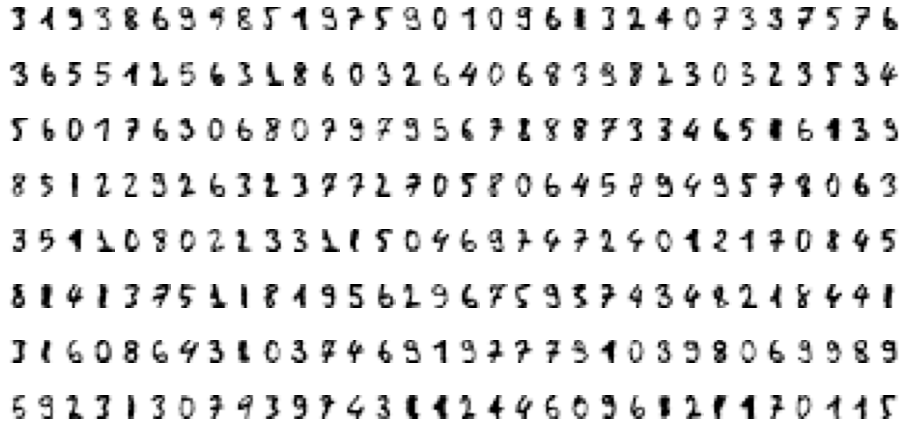

In [36]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

/home/nelson/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nelson/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/nelson/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nelson/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/nelson/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments w

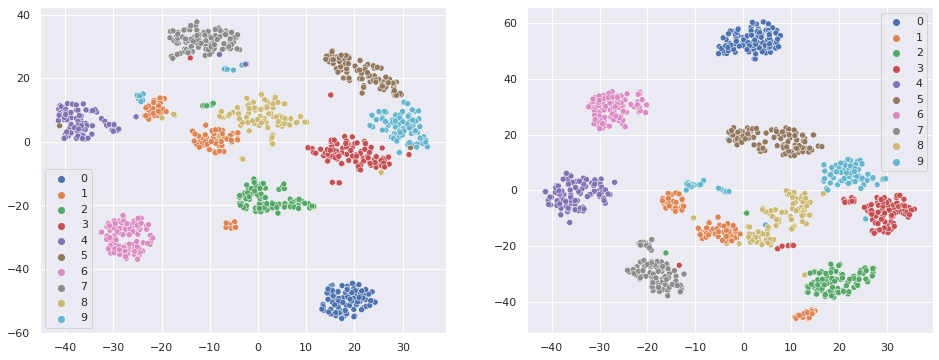

In [37]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

/home/nelson/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nelson/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


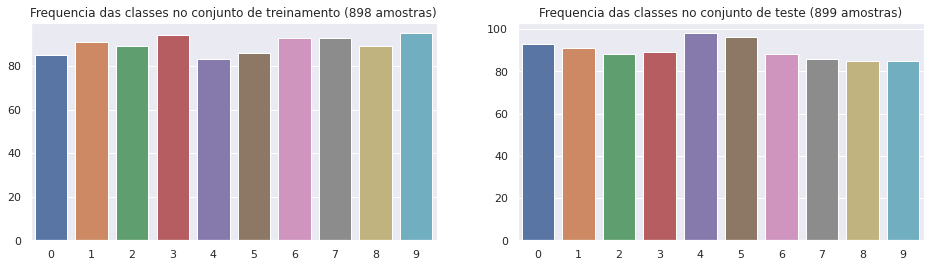

In [38]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

### Modelando um classificador de digitos com SVM Linear

**Atividade (1 pt):** defina e treine uma máquina de vetor de suporte com kernel linear, utilizando o scikit-learn. Encontre o melhor valor do parâmetro C, definindo um intervalo de busca e fazendo um grid search com validação cruzada em 10 folds.

In [39]:
# imports
from sklearn import svm
from sklearn import metrics

In [40]:
# Creating training params
c_range = [1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0, 5e0, 1e1, 5e1, 1e2, 500, 1e3]
param_grid = dict(C=c_range)
cv = KFold(n_splits=10, shuffle=True, random_state=rs)

# Scaling the training and test data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [41]:
# Applying a grid search (This may take some time, around 20 minutes to run)
grid_digits = GridSearchCV(svm.SVC(kernel="linear"), param_grid, cv=cv, scoring="accuracy", verbose=10)
grid_digits.fit(X=x_train, y=y_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV 1/10; 1/14] START C=0.0001..................................................
[CV 1/10; 1/14] END ...................C=0.0001;, score=0.156 total time=   0.1s
[CV 2/10; 1/14] START C=0.0001..................................................
[CV 2/10; 1/14] END ...................C=0.0001;, score=0.078 total time=   0.0s
[CV 3/10; 1/14] START C=0.0001..................................................
[CV 3/10; 1/14] END ...................C=0.0001;, score=0.222 total time=   0.0s
[CV 4/10; 1/14] START C=0.0001..................................................
[CV 4/10; 1/14] END ...................C=0.0001;, score=0.178 total time=   0.0s
[CV 5/10; 1/14] START C=0.0001..................................................
[CV 5/10; 1/14] END ...................C=0.0001;, score=0.067 total time=   0.0s
[CV 6/10; 1/14] START C=0.0001..................................................
[CV 6/10; 1/14] END ...................C=0.000

[CV 4/10; 7/14] END ......................C=0.5;, score=0.978 total time=   0.0s
[CV 5/10; 7/14] START C=0.5.....................................................
[CV 5/10; 7/14] END ......................C=0.5;, score=1.000 total time=   0.0s
[CV 6/10; 7/14] START C=0.5.....................................................
[CV 6/10; 7/14] END ......................C=0.5;, score=0.978 total time=   0.0s
[CV 7/10; 7/14] START C=0.5.....................................................
[CV 7/10; 7/14] END ......................C=0.5;, score=0.989 total time=   0.0s
[CV 8/10; 7/14] START C=0.5.....................................................
[CV 8/10; 7/14] END ......................C=0.5;, score=0.989 total time=   0.0s
[CV 9/10; 7/14] START C=0.5.....................................................
[CV 9/10; 7/14] END ......................C=0.5;, score=0.966 total time=   0.0s
[CV 10/10; 7/14] START C=0.5....................................................
[CV 10/10; 7/14] END .......

[CV 5/10; 12/14] END ...................C=100.0;, score=1.000 total time=   0.0s
[CV 6/10; 12/14] START C=100.0..................................................
[CV 6/10; 12/14] END ...................C=100.0;, score=0.978 total time=   0.0s
[CV 7/10; 12/14] START C=100.0..................................................
[CV 7/10; 12/14] END ...................C=100.0;, score=0.978 total time=   0.0s
[CV 8/10; 12/14] START C=100.0..................................................
[CV 8/10; 12/14] END ...................C=100.0;, score=0.989 total time=   0.0s
[CV 9/10; 12/14] START C=100.0..................................................
[CV 9/10; 12/14] END ...................C=100.0;, score=0.966 total time=   0.0s
[CV 10/10; 12/14] START C=100.0.................................................
[CV 10/10; 12/14] END ..................C=100.0;, score=0.966 total time=   0.0s
[CV 1/10; 13/14] START C=500....................................................
[CV 1/10; 13/14] END .......

GridSearchCV(cv=KFold(n_splits=10, random_state=1082141, shuffle=True),
             estimator=SVC(kernel='linear'),
             param_grid={'C': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0,
                               5.0, 10.0, 50.0, 100.0, 500, 1000.0]},
             scoring='accuracy', verbose=10)

In [42]:
# Sorting classifiers by MSE quality
results_svm_grid = pd.DataFrame(grid_digits.cv_results_).sort_values(by=['rank_test_score'])

best_c = results_svm_grid.head(1)["param_C"].iloc[0]
mean_best_acc = results_svm_grid.head(1)["mean_test_score"].iloc[0]
print(f"The best result for the training set using CV = 10 is C = {best_c} with mean accuracy = {mean_best_acc}")

The best result for the training set using CV = 10 is C = 0.5 with mean accuracy = 0.9788139825218478


### Avaliando o modelo treinado

**Atividade (1 pt):** avalie o modelo treinado com o melhor valor encontrado para o parâmetro C sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão.

The accuracy of the best SVM model for the test set is 0.9699666295884316


Text(0.5, 1.0, 'Confusion Matrix')

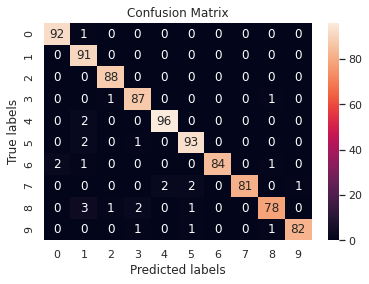

In [43]:
best_svm_lin = svm.SVC(kernel="linear", C=best_c)
best_svm_lin.fit(X=x_train, y=y_train)

# Applying prediction to test set
y_pred_test = best_svm_lin.predict(x_test)


# Applying accuracy and precision
acc_best_svm_lin_test = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test)
print(f"The accuracy of the best SVM model for the test set is {acc_best_svm_lin_test}")

# Confusion matrix
cm_best_svm_lin_test = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_test)
ax= plt.subplot()
sns.heatmap(cm_best_svm_lin_test, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')

### Modelando um classificador de digitos com SVM com kernel RBF

**Atividade (1 pt):** utilizando o kernel RBF, defina e treine uma máquina de vetor de suporte. Faça um grid search nos valores de C e gamma com validação cruzada em 10 folds.

In [44]:
c_range = [1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0, 5e0, 1e1, 5e1, 1e2, 500, 1e3]
gamma_range = [1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0, 5e0, 1e1, 5e1, 1e2, 500, 1e3]
param_grid = dict(C=c_range, gamma=gamma_range)
cv = KFold(n_splits=10, shuffle=True, random_state=rs)

# Applying a grid search (This may take some time, around 20 minutes to run)
grid_digits_rbf = GridSearchCV(svm.SVC(kernel="rbf"), param_grid, cv=cv, scoring="accuracy", verbose=10)
grid_digits_rbf.fit(X=x_train, y=y_train)

Fitting 10 folds for each of 196 candidates, totalling 1960 fits
[CV 1/10; 1/196] START C=0.0001, gamma=0.0001...................................
[CV 1/10; 1/196] END ....C=0.0001, gamma=0.0001;, score=0.156 total time=   0.1s
[CV 2/10; 1/196] START C=0.0001, gamma=0.0001...................................
[CV 2/10; 1/196] END ....C=0.0001, gamma=0.0001;, score=0.078 total time=   0.1s
[CV 3/10; 1/196] START C=0.0001, gamma=0.0001...................................
[CV 3/10; 1/196] END ....C=0.0001, gamma=0.0001;, score=0.222 total time=   0.1s
[CV 4/10; 1/196] START C=0.0001, gamma=0.0001...................................
[CV 4/10; 1/196] END ....C=0.0001, gamma=0.0001;, score=0.178 total time=   0.1s
[CV 5/10; 1/196] START C=0.0001, gamma=0.0001...................................
[CV 5/10; 1/196] END ....C=0.0001, gamma=0.0001;, score=0.067 total time=   0.1s
[CV 6/10; 1/196] START C=0.0001, gamma=0.0001...................................
[CV 6/10; 1/196] END ....C=0.0001, gamma=0.0

[CV 2/10; 6/196] END .......C=0.0001, gamma=0.1;, score=0.078 total time=   0.1s
[CV 3/10; 6/196] START C=0.0001, gamma=0.1......................................
[CV 3/10; 6/196] END .......C=0.0001, gamma=0.1;, score=0.189 total time=   0.1s
[CV 4/10; 6/196] START C=0.0001, gamma=0.1......................................
[CV 4/10; 6/196] END .......C=0.0001, gamma=0.1;, score=0.167 total time=   0.1s
[CV 5/10; 6/196] START C=0.0001, gamma=0.1......................................
[CV 5/10; 6/196] END .......C=0.0001, gamma=0.1;, score=0.067 total time=   0.1s
[CV 6/10; 6/196] START C=0.0001, gamma=0.1......................................
[CV 6/10; 6/196] END .......C=0.0001, gamma=0.1;, score=0.067 total time=   0.1s
[CV 7/10; 6/196] START C=0.0001, gamma=0.1......................................
[CV 7/10; 6/196] END .......C=0.0001, gamma=0.1;, score=0.156 total time=   0.1s
[CV 8/10; 6/196] START C=0.0001, gamma=0.1......................................
[CV 8/10; 6/196] END .......

[CV 4/10; 11/196] END .....C=0.0001, gamma=50.0;, score=0.167 total time=   0.1s
[CV 5/10; 11/196] START C=0.0001, gamma=50.0....................................
[CV 5/10; 11/196] END .....C=0.0001, gamma=50.0;, score=0.067 total time=   0.1s
[CV 6/10; 11/196] START C=0.0001, gamma=50.0....................................
[CV 6/10; 11/196] END .....C=0.0001, gamma=50.0;, score=0.067 total time=   0.1s
[CV 7/10; 11/196] START C=0.0001, gamma=50.0....................................
[CV 7/10; 11/196] END .....C=0.0001, gamma=50.0;, score=0.133 total time=   0.1s
[CV 8/10; 11/196] START C=0.0001, gamma=50.0....................................
[CV 8/10; 11/196] END .....C=0.0001, gamma=50.0;, score=0.056 total time=   0.1s
[CV 9/10; 11/196] START C=0.0001, gamma=50.0....................................
[CV 9/10; 11/196] END .....C=0.0001, gamma=50.0;, score=0.079 total time=   0.1s
[CV 10/10; 11/196] START C=0.0001, gamma=50.0...................................
[CV 10/10; 11/196] END ....C

[CV 6/10; 16/196] END .....C=0.001, gamma=0.001;, score=0.067 total time=   0.1s
[CV 7/10; 16/196] START C=0.001, gamma=0.001....................................
[CV 7/10; 16/196] END .....C=0.001, gamma=0.001;, score=0.167 total time=   0.1s
[CV 8/10; 16/196] START C=0.001, gamma=0.001....................................
[CV 8/10; 16/196] END .....C=0.001, gamma=0.001;, score=0.056 total time=   0.1s
[CV 9/10; 16/196] START C=0.001, gamma=0.001....................................
[CV 9/10; 16/196] END .....C=0.001, gamma=0.001;, score=0.079 total time=   0.1s
[CV 10/10; 16/196] START C=0.001, gamma=0.001...................................
[CV 10/10; 16/196] END ....C=0.001, gamma=0.001;, score=0.135 total time=   0.1s
[CV 1/10; 17/196] START C=0.001, gamma=0.005....................................
[CV 1/10; 17/196] END .....C=0.001, gamma=0.005;, score=0.156 total time=   0.1s
[CV 2/10; 17/196] START C=0.001, gamma=0.005....................................
[CV 2/10; 17/196] END .....C

[CV 8/10; 21/196] END .......C=0.001, gamma=0.5;, score=0.056 total time=   0.1s
[CV 9/10; 21/196] START C=0.001, gamma=0.5......................................
[CV 9/10; 21/196] END .......C=0.001, gamma=0.5;, score=0.079 total time=   0.1s
[CV 10/10; 21/196] START C=0.001, gamma=0.5.....................................
[CV 10/10; 21/196] END ......C=0.001, gamma=0.5;, score=0.124 total time=   0.1s
[CV 1/10; 22/196] START C=0.001, gamma=1.0......................................
[CV 1/10; 22/196] END .......C=0.001, gamma=1.0;, score=0.100 total time=   0.1s
[CV 2/10; 22/196] START C=0.001, gamma=1.0......................................
[CV 2/10; 22/196] END .......C=0.001, gamma=1.0;, score=0.078 total time=   0.1s
[CV 3/10; 22/196] START C=0.001, gamma=1.0......................................
[CV 3/10; 22/196] END .......C=0.001, gamma=1.0;, score=0.100 total time=   0.1s
[CV 4/10; 22/196] START C=0.001, gamma=1.0......................................
[CV 4/10; 22/196] END ......

[CV 10/10; 26/196] END ....C=0.001, gamma=100.0;, score=0.090 total time=   0.1s
[CV 1/10; 27/196] START C=0.001, gamma=500......................................
[CV 1/10; 27/196] END .......C=0.001, gamma=500;, score=0.100 total time=   0.1s
[CV 2/10; 27/196] START C=0.001, gamma=500......................................
[CV 2/10; 27/196] END .......C=0.001, gamma=500;, score=0.078 total time=   0.1s
[CV 3/10; 27/196] START C=0.001, gamma=500......................................
[CV 3/10; 27/196] END .......C=0.001, gamma=500;, score=0.089 total time=   0.1s
[CV 4/10; 27/196] START C=0.001, gamma=500......................................
[CV 4/10; 27/196] END .......C=0.001, gamma=500;, score=0.100 total time=   0.1s
[CV 5/10; 27/196] START C=0.001, gamma=500......................................
[CV 5/10; 27/196] END .......C=0.001, gamma=500;, score=0.067 total time=   0.1s
[CV 6/10; 27/196] START C=0.001, gamma=500......................................
[CV 6/10; 27/196] END ......

[CV 2/10; 32/196] END ......C=0.005, gamma=0.01;, score=0.078 total time=   0.1s
[CV 3/10; 32/196] START C=0.005, gamma=0.01.....................................
[CV 3/10; 32/196] END ......C=0.005, gamma=0.01;, score=0.222 total time=   0.1s
[CV 4/10; 32/196] START C=0.005, gamma=0.01.....................................
[CV 4/10; 32/196] END ......C=0.005, gamma=0.01;, score=0.178 total time=   0.1s
[CV 5/10; 32/196] START C=0.005, gamma=0.01.....................................
[CV 5/10; 32/196] END ......C=0.005, gamma=0.01;, score=0.067 total time=   0.1s
[CV 6/10; 32/196] START C=0.005, gamma=0.01.....................................
[CV 6/10; 32/196] END ......C=0.005, gamma=0.01;, score=0.067 total time=   0.1s
[CV 7/10; 32/196] START C=0.005, gamma=0.01.....................................
[CV 7/10; 32/196] END ......C=0.005, gamma=0.01;, score=0.167 total time=   0.1s
[CV 8/10; 32/196] START C=0.005, gamma=0.01.....................................
[CV 8/10; 32/196] END ......

[CV 4/10; 37/196] END .......C=0.005, gamma=5.0;, score=0.100 total time=   0.1s
[CV 5/10; 37/196] START C=0.005, gamma=5.0......................................
[CV 5/10; 37/196] END .......C=0.005, gamma=5.0;, score=0.067 total time=   0.1s
[CV 6/10; 37/196] START C=0.005, gamma=5.0......................................
[CV 6/10; 37/196] END .......C=0.005, gamma=5.0;, score=0.067 total time=   0.1s
[CV 7/10; 37/196] START C=0.005, gamma=5.0......................................
[CV 7/10; 37/196] END .......C=0.005, gamma=5.0;, score=0.100 total time=   0.1s
[CV 8/10; 37/196] START C=0.005, gamma=5.0......................................
[CV 8/10; 37/196] END .......C=0.005, gamma=5.0;, score=0.056 total time=   0.1s
[CV 9/10; 37/196] START C=0.005, gamma=5.0......................................
[CV 9/10; 37/196] END .......C=0.005, gamma=5.0;, score=0.079 total time=   0.1s
[CV 10/10; 37/196] START C=0.005, gamma=5.0.....................................
[CV 10/10; 37/196] END .....

[CV 6/10; 42/196] END ....C=0.005, gamma=1000.0;, score=0.067 total time=   0.1s
[CV 7/10; 42/196] START C=0.005, gamma=1000.0...................................
[CV 7/10; 42/196] END ....C=0.005, gamma=1000.0;, score=0.100 total time=   0.1s
[CV 8/10; 42/196] START C=0.005, gamma=1000.0...................................
[CV 8/10; 42/196] END ....C=0.005, gamma=1000.0;, score=0.056 total time=   0.1s
[CV 9/10; 42/196] START C=0.005, gamma=1000.0...................................
[CV 9/10; 42/196] END ....C=0.005, gamma=1000.0;, score=0.079 total time=   0.1s
[CV 10/10; 42/196] START C=0.005, gamma=1000.0..................................
[CV 10/10; 42/196] END ...C=0.005, gamma=1000.0;, score=0.090 total time=   0.1s
[CV 1/10; 43/196] START C=0.01, gamma=0.0001....................................
[CV 1/10; 43/196] END .....C=0.01, gamma=0.0001;, score=0.156 total time=   0.1s
[CV 2/10; 43/196] START C=0.01, gamma=0.0001....................................
[CV 2/10; 43/196] END .....C

[CV 8/10; 47/196] END .......C=0.01, gamma=0.05;, score=0.056 total time=   0.1s
[CV 9/10; 47/196] START C=0.01, gamma=0.05......................................
[CV 9/10; 47/196] END .......C=0.01, gamma=0.05;, score=0.079 total time=   0.1s
[CV 10/10; 47/196] START C=0.01, gamma=0.05.....................................
[CV 10/10; 47/196] END ......C=0.01, gamma=0.05;, score=0.124 total time=   0.1s
[CV 1/10; 48/196] START C=0.01, gamma=0.1.......................................
[CV 1/10; 48/196] END ........C=0.01, gamma=0.1;, score=0.111 total time=   0.1s
[CV 2/10; 48/196] START C=0.01, gamma=0.1.......................................
[CV 2/10; 48/196] END ........C=0.01, gamma=0.1;, score=0.078 total time=   0.1s
[CV 3/10; 48/196] START C=0.01, gamma=0.1.......................................
[CV 3/10; 48/196] END ........C=0.01, gamma=0.1;, score=0.189 total time=   0.1s
[CV 4/10; 48/196] START C=0.01, gamma=0.1.......................................
[CV 4/10; 48/196] END ......

[CV 10/10; 52/196] END ......C=0.01, gamma=10.0;, score=0.157 total time=   0.1s
[CV 1/10; 53/196] START C=0.01, gamma=50.0......................................
[CV 1/10; 53/196] END .......C=0.01, gamma=50.0;, score=0.144 total time=   0.1s
[CV 2/10; 53/196] START C=0.01, gamma=50.0......................................
[CV 2/10; 53/196] END .......C=0.01, gamma=50.0;, score=0.078 total time=   0.1s
[CV 3/10; 53/196] START C=0.01, gamma=50.0......................................
[CV 3/10; 53/196] END .......C=0.01, gamma=50.0;, score=0.189 total time=   0.1s
[CV 4/10; 53/196] START C=0.01, gamma=50.0......................................
[CV 4/10; 53/196] END .......C=0.01, gamma=50.0;, score=0.167 total time=   0.1s
[CV 5/10; 53/196] START C=0.01, gamma=50.0......................................
[CV 5/10; 53/196] END .......C=0.01, gamma=50.0;, score=0.067 total time=   0.1s
[CV 6/10; 53/196] START C=0.01, gamma=50.0......................................
[CV 6/10; 53/196] END ......

[CV 2/10; 58/196] END ......C=0.05, gamma=0.001;, score=0.078 total time=   0.1s
[CV 3/10; 58/196] START C=0.05, gamma=0.001.....................................
[CV 3/10; 58/196] END ......C=0.05, gamma=0.001;, score=0.222 total time=   0.1s
[CV 4/10; 58/196] START C=0.05, gamma=0.001.....................................
[CV 4/10; 58/196] END ......C=0.05, gamma=0.001;, score=0.178 total time=   0.1s
[CV 5/10; 58/196] START C=0.05, gamma=0.001.....................................
[CV 5/10; 58/196] END ......C=0.05, gamma=0.001;, score=0.067 total time=   0.1s
[CV 6/10; 58/196] START C=0.05, gamma=0.001.....................................
[CV 6/10; 58/196] END ......C=0.05, gamma=0.001;, score=0.067 total time=   0.1s
[CV 7/10; 58/196] START C=0.05, gamma=0.001.....................................
[CV 7/10; 58/196] END ......C=0.05, gamma=0.001;, score=0.167 total time=   0.1s
[CV 8/10; 58/196] START C=0.05, gamma=0.001.....................................
[CV 8/10; 58/196] END ......

[CV 5/10; 63/196] END ........C=0.05, gamma=0.5;, score=0.067 total time=   0.1s
[CV 6/10; 63/196] START C=0.05, gamma=0.5.......................................
[CV 6/10; 63/196] END ........C=0.05, gamma=0.5;, score=0.067 total time=   0.1s
[CV 7/10; 63/196] START C=0.05, gamma=0.5.......................................
[CV 7/10; 63/196] END ........C=0.05, gamma=0.5;, score=0.100 total time=   0.1s
[CV 8/10; 63/196] START C=0.05, gamma=0.5.......................................
[CV 8/10; 63/196] END ........C=0.05, gamma=0.5;, score=0.056 total time=   0.1s
[CV 9/10; 63/196] START C=0.05, gamma=0.5.......................................
[CV 9/10; 63/196] END ........C=0.05, gamma=0.5;, score=0.079 total time=   0.1s
[CV 10/10; 63/196] START C=0.05, gamma=0.5......................................
[CV 10/10; 63/196] END .......C=0.05, gamma=0.5;, score=0.124 total time=   0.1s
[CV 1/10; 64/196] START C=0.05, gamma=1.0.......................................
[CV 1/10; 64/196] END ......

[CV 9/10; 68/196] END ......C=0.05, gamma=100.0;, score=0.079 total time=   0.1s
[CV 10/10; 68/196] START C=0.05, gamma=100.0....................................
[CV 10/10; 68/196] END .....C=0.05, gamma=100.0;, score=0.090 total time=   0.1s
[CV 1/10; 69/196] START C=0.05, gamma=500.......................................
[CV 1/10; 69/196] END ........C=0.05, gamma=500;, score=0.100 total time=   0.1s
[CV 2/10; 69/196] START C=0.05, gamma=500.......................................
[CV 2/10; 69/196] END ........C=0.05, gamma=500;, score=0.078 total time=   0.1s
[CV 3/10; 69/196] START C=0.05, gamma=500.......................................
[CV 3/10; 69/196] END ........C=0.05, gamma=500;, score=0.089 total time=   0.1s
[CV 4/10; 69/196] START C=0.05, gamma=500.......................................
[CV 4/10; 69/196] END ........C=0.05, gamma=500;, score=0.100 total time=   0.1s
[CV 5/10; 69/196] START C=0.05, gamma=500.......................................
[CV 5/10; 69/196] END ......

[CV 4/10; 74/196] END ........C=0.1, gamma=0.01;, score=0.911 total time=   0.0s
[CV 5/10; 74/196] START C=0.1, gamma=0.01.......................................
[CV 5/10; 74/196] END ........C=0.1, gamma=0.01;, score=0.933 total time=   0.0s
[CV 6/10; 74/196] START C=0.1, gamma=0.01.......................................
[CV 6/10; 74/196] END ........C=0.1, gamma=0.01;, score=0.889 total time=   0.0s
[CV 7/10; 74/196] START C=0.1, gamma=0.01.......................................
[CV 7/10; 74/196] END ........C=0.1, gamma=0.01;, score=0.844 total time=   0.0s
[CV 8/10; 74/196] START C=0.1, gamma=0.01.......................................
[CV 8/10; 74/196] END ........C=0.1, gamma=0.01;, score=0.911 total time=   0.0s
[CV 9/10; 74/196] START C=0.1, gamma=0.01.......................................
[CV 9/10; 74/196] END ........C=0.1, gamma=0.01;, score=0.865 total time=   0.0s
[CV 10/10; 74/196] START C=0.1, gamma=0.01......................................
[CV 10/10; 74/196] END .....

[CV 7/10; 79/196] END .........C=0.1, gamma=5.0;, score=0.100 total time=   0.1s
[CV 8/10; 79/196] START C=0.1, gamma=5.0........................................
[CV 8/10; 79/196] END .........C=0.1, gamma=5.0;, score=0.056 total time=   0.1s
[CV 9/10; 79/196] START C=0.1, gamma=5.0........................................
[CV 9/10; 79/196] END .........C=0.1, gamma=5.0;, score=0.079 total time=   0.1s
[CV 10/10; 79/196] START C=0.1, gamma=5.0.......................................
[CV 10/10; 79/196] END ........C=0.1, gamma=5.0;, score=0.090 total time=   0.1s
[CV 1/10; 80/196] START C=0.1, gamma=10.0.......................................
[CV 1/10; 80/196] END ........C=0.1, gamma=10.0;, score=0.100 total time=   0.1s
[CV 2/10; 80/196] START C=0.1, gamma=10.0.......................................
[CV 2/10; 80/196] END ........C=0.1, gamma=10.0;, score=0.078 total time=   0.1s
[CV 3/10; 80/196] START C=0.1, gamma=10.0.......................................
[CV 3/10; 80/196] END ......

[CV 9/10; 84/196] END ......C=0.1, gamma=1000.0;, score=0.079 total time=   0.1s
[CV 10/10; 84/196] START C=0.1, gamma=1000.0....................................
[CV 10/10; 84/196] END .....C=0.1, gamma=1000.0;, score=0.090 total time=   0.1s
[CV 1/10; 85/196] START C=0.5, gamma=0.0001.....................................
[CV 1/10; 85/196] END ......C=0.5, gamma=0.0001;, score=0.156 total time=   0.1s
[CV 2/10; 85/196] START C=0.5, gamma=0.0001.....................................
[CV 2/10; 85/196] END ......C=0.5, gamma=0.0001;, score=0.078 total time=   0.1s
[CV 3/10; 85/196] START C=0.5, gamma=0.0001.....................................
[CV 3/10; 85/196] END ......C=0.5, gamma=0.0001;, score=0.222 total time=   0.1s
[CV 4/10; 85/196] START C=0.5, gamma=0.0001.....................................
[CV 4/10; 85/196] END ......C=0.5, gamma=0.0001;, score=0.178 total time=   0.1s
[CV 5/10; 85/196] START C=0.5, gamma=0.0001.....................................
[CV 5/10; 85/196] END ......

[CV 1/10; 90/196] END .........C=0.5, gamma=0.1;, score=0.833 total time=   0.1s
[CV 2/10; 90/196] START C=0.5, gamma=0.1........................................
[CV 2/10; 90/196] END .........C=0.5, gamma=0.1;, score=0.889 total time=   0.1s
[CV 3/10; 90/196] START C=0.5, gamma=0.1........................................
[CV 3/10; 90/196] END .........C=0.5, gamma=0.1;, score=0.944 total time=   0.1s
[CV 4/10; 90/196] START C=0.5, gamma=0.1........................................
[CV 4/10; 90/196] END .........C=0.5, gamma=0.1;, score=0.856 total time=   0.1s
[CV 5/10; 90/196] START C=0.5, gamma=0.1........................................
[CV 5/10; 90/196] END .........C=0.5, gamma=0.1;, score=0.811 total time=   0.1s
[CV 6/10; 90/196] START C=0.5, gamma=0.1........................................
[CV 6/10; 90/196] END .........C=0.5, gamma=0.1;, score=0.856 total time=   0.1s
[CV 7/10; 90/196] START C=0.5, gamma=0.1........................................
[CV 7/10; 90/196] END ......

[CV 5/10; 95/196] END ........C=0.5, gamma=50.0;, score=0.067 total time=   0.1s
[CV 6/10; 95/196] START C=0.5, gamma=50.0.......................................
[CV 6/10; 95/196] END ........C=0.5, gamma=50.0;, score=0.067 total time=   0.1s
[CV 7/10; 95/196] START C=0.5, gamma=50.0.......................................
[CV 7/10; 95/196] END ........C=0.5, gamma=50.0;, score=0.133 total time=   0.1s
[CV 8/10; 95/196] START C=0.5, gamma=50.0.......................................
[CV 8/10; 95/196] END ........C=0.5, gamma=50.0;, score=0.056 total time=   0.1s
[CV 9/10; 95/196] START C=0.5, gamma=50.0.......................................
[CV 9/10; 95/196] END ........C=0.5, gamma=50.0;, score=0.079 total time=   0.1s
[CV 10/10; 95/196] START C=0.5, gamma=50.0......................................
[CV 10/10; 95/196] END .......C=0.5, gamma=50.0;, score=0.146 total time=   0.1s
[CV 1/10; 96/196] START C=0.5, gamma=100.0......................................
[CV 1/10; 96/196] END ......

[CV 2/10; 101/196] END ......C=1.0, gamma=0.005;, score=0.922 total time=   0.0s
[CV 3/10; 101/196] START C=1.0, gamma=0.005.....................................
[CV 3/10; 101/196] END ......C=1.0, gamma=0.005;, score=0.978 total time=   0.0s
[CV 4/10; 101/196] START C=1.0, gamma=0.005.....................................
[CV 4/10; 101/196] END ......C=1.0, gamma=0.005;, score=0.967 total time=   0.0s
[CV 5/10; 101/196] START C=1.0, gamma=0.005.....................................
[CV 5/10; 101/196] END ......C=1.0, gamma=0.005;, score=0.956 total time=   0.0s
[CV 6/10; 101/196] START C=1.0, gamma=0.005.....................................
[CV 6/10; 101/196] END ......C=1.0, gamma=0.005;, score=0.956 total time=   0.0s
[CV 7/10; 101/196] START C=1.0, gamma=0.005.....................................
[CV 7/10; 101/196] END ......C=1.0, gamma=0.005;, score=0.978 total time=   0.0s
[CV 8/10; 101/196] START C=1.0, gamma=0.005.....................................
[CV 8/10; 101/196] END .....

[CV 4/10; 106/196] END ........C=1.0, gamma=1.0;, score=0.133 total time=   0.1s
[CV 5/10; 106/196] START C=1.0, gamma=1.0.......................................
[CV 5/10; 106/196] END ........C=1.0, gamma=1.0;, score=0.078 total time=   0.1s
[CV 6/10; 106/196] START C=1.0, gamma=1.0.......................................
[CV 6/10; 106/196] END ........C=1.0, gamma=1.0;, score=0.067 total time=   0.1s
[CV 7/10; 106/196] START C=1.0, gamma=1.0.......................................
[CV 7/10; 106/196] END ........C=1.0, gamma=1.0;, score=0.100 total time=   0.1s
[CV 8/10; 106/196] START C=1.0, gamma=1.0.......................................
[CV 8/10; 106/196] END ........C=1.0, gamma=1.0;, score=0.078 total time=   0.1s
[CV 9/10; 106/196] START C=1.0, gamma=1.0.......................................
[CV 9/10; 106/196] END ........C=1.0, gamma=1.0;, score=0.090 total time=   0.1s
[CV 10/10; 106/196] START C=1.0, gamma=1.0......................................
[CV 10/10; 106/196] END ....

[CV 8/10; 111/196] END ........C=1.0, gamma=500;, score=0.056 total time=   0.1s
[CV 9/10; 111/196] START C=1.0, gamma=500.......................................
[CV 9/10; 111/196] END ........C=1.0, gamma=500;, score=0.079 total time=   0.1s
[CV 10/10; 111/196] START C=1.0, gamma=500......................................
[CV 10/10; 111/196] END .......C=1.0, gamma=500;, score=0.090 total time=   0.1s
[CV 1/10; 112/196] START C=1.0, gamma=1000.0....................................
[CV 1/10; 112/196] END .....C=1.0, gamma=1000.0;, score=0.100 total time=   0.1s
[CV 2/10; 112/196] START C=1.0, gamma=1000.0....................................
[CV 2/10; 112/196] END .....C=1.0, gamma=1000.0;, score=0.078 total time=   0.1s
[CV 3/10; 112/196] START C=1.0, gamma=1000.0....................................
[CV 3/10; 112/196] END .....C=1.0, gamma=1000.0;, score=0.089 total time=   0.1s
[CV 4/10; 112/196] START C=1.0, gamma=1000.0....................................
[CV 4/10; 112/196] END .....

[CV 3/10; 117/196] END .......C=5.0, gamma=0.05;, score=1.000 total time=   0.1s
[CV 4/10; 117/196] START C=5.0, gamma=0.05......................................
[CV 4/10; 117/196] END .......C=5.0, gamma=0.05;, score=0.967 total time=   0.0s
[CV 5/10; 117/196] START C=5.0, gamma=0.05......................................
[CV 5/10; 117/196] END .......C=5.0, gamma=0.05;, score=0.933 total time=   0.0s
[CV 6/10; 117/196] START C=5.0, gamma=0.05......................................
[CV 6/10; 117/196] END .......C=5.0, gamma=0.05;, score=0.978 total time=   0.0s
[CV 7/10; 117/196] START C=5.0, gamma=0.05......................................
[CV 7/10; 117/196] END .......C=5.0, gamma=0.05;, score=0.967 total time=   0.0s
[CV 8/10; 117/196] START C=5.0, gamma=0.05......................................
[CV 8/10; 117/196] END .......C=5.0, gamma=0.05;, score=0.956 total time=   0.1s
[CV 9/10; 117/196] START C=5.0, gamma=0.05......................................
[CV 9/10; 117/196] END .....

[CV 5/10; 122/196] END .......C=5.0, gamma=10.0;, score=0.067 total time=   0.1s
[CV 6/10; 122/196] START C=5.0, gamma=10.0......................................
[CV 6/10; 122/196] END .......C=5.0, gamma=10.0;, score=0.067 total time=   0.1s
[CV 7/10; 122/196] START C=5.0, gamma=10.0......................................
[CV 7/10; 122/196] END .......C=5.0, gamma=10.0;, score=0.100 total time=   0.1s
[CV 8/10; 122/196] START C=5.0, gamma=10.0......................................
[CV 8/10; 122/196] END .......C=5.0, gamma=10.0;, score=0.056 total time=   0.1s
[CV 9/10; 122/196] START C=5.0, gamma=10.0......................................
[CV 9/10; 122/196] END .......C=5.0, gamma=10.0;, score=0.079 total time=   0.1s
[CV 10/10; 122/196] START C=5.0, gamma=10.0.....................................
[CV 10/10; 122/196] END ......C=5.0, gamma=10.0;, score=0.090 total time=   0.1s
[CV 1/10; 123/196] START C=5.0, gamma=50.0......................................
[CV 1/10; 123/196] END .....

[CV 8/10; 127/196] END ....C=10.0, gamma=0.0001;, score=0.922 total time=   0.0s
[CV 9/10; 127/196] START C=10.0, gamma=0.0001...................................
[CV 9/10; 127/196] END ....C=10.0, gamma=0.0001;, score=0.888 total time=   0.0s
[CV 10/10; 127/196] START C=10.0, gamma=0.0001..................................
[CV 10/10; 127/196] END ...C=10.0, gamma=0.0001;, score=0.955 total time=   0.0s
[CV 1/10; 128/196] START C=10.0, gamma=0.001....................................
[CV 1/10; 128/196] END .....C=10.0, gamma=0.001;, score=0.967 total time=   0.0s
[CV 2/10; 128/196] START C=10.0, gamma=0.001....................................
[CV 2/10; 128/196] END .....C=10.0, gamma=0.001;, score=0.922 total time=   0.0s
[CV 3/10; 128/196] START C=10.0, gamma=0.001....................................
[CV 3/10; 128/196] END .....C=10.0, gamma=0.001;, score=0.978 total time=   0.0s
[CV 4/10; 128/196] START C=10.0, gamma=0.001....................................
[CV 4/10; 128/196] END .....

[CV 2/10; 133/196] END .......C=10.0, gamma=0.5;, score=0.122 total time=   0.1s
[CV 3/10; 133/196] START C=10.0, gamma=0.5......................................
[CV 3/10; 133/196] END .......C=10.0, gamma=0.5;, score=0.278 total time=   0.1s
[CV 4/10; 133/196] START C=10.0, gamma=0.5......................................
[CV 4/10; 133/196] END .......C=10.0, gamma=0.5;, score=0.211 total time=   0.1s
[CV 5/10; 133/196] START C=10.0, gamma=0.5......................................
[CV 5/10; 133/196] END .......C=10.0, gamma=0.5;, score=0.167 total time=   0.1s
[CV 6/10; 133/196] START C=10.0, gamma=0.5......................................
[CV 6/10; 133/196] END .......C=10.0, gamma=0.5;, score=0.122 total time=   0.1s
[CV 7/10; 133/196] START C=10.0, gamma=0.5......................................
[CV 7/10; 133/196] END .......C=10.0, gamma=0.5;, score=0.233 total time=   0.1s
[CV 8/10; 133/196] START C=10.0, gamma=0.5......................................
[CV 8/10; 133/196] END .....

[CV 3/10; 138/196] END .....C=10.0, gamma=100.0;, score=0.122 total time=   0.1s
[CV 4/10; 138/196] START C=10.0, gamma=100.0....................................
[CV 4/10; 138/196] END .....C=10.0, gamma=100.0;, score=0.122 total time=   0.1s
[CV 5/10; 138/196] START C=10.0, gamma=100.0....................................
[CV 5/10; 138/196] END .....C=10.0, gamma=100.0;, score=0.067 total time=   0.1s
[CV 6/10; 138/196] START C=10.0, gamma=100.0....................................
[CV 6/10; 138/196] END .....C=10.0, gamma=100.0;, score=0.067 total time=   0.1s
[CV 7/10; 138/196] START C=10.0, gamma=100.0....................................
[CV 7/10; 138/196] END .....C=10.0, gamma=100.0;, score=0.100 total time=   0.1s
[CV 8/10; 138/196] START C=10.0, gamma=100.0....................................
[CV 8/10; 138/196] END .....C=10.0, gamma=100.0;, score=0.056 total time=   0.1s
[CV 9/10; 138/196] START C=10.0, gamma=100.0....................................
[CV 9/10; 138/196] END .....

[CV 6/10; 143/196] END .....C=50.0, gamma=0.005;, score=0.956 total time=   0.0s
[CV 7/10; 143/196] START C=50.0, gamma=0.005....................................
[CV 7/10; 143/196] END .....C=50.0, gamma=0.005;, score=1.000 total time=   0.0s
[CV 8/10; 143/196] START C=50.0, gamma=0.005....................................
[CV 8/10; 143/196] END .....C=50.0, gamma=0.005;, score=0.989 total time=   0.0s
[CV 9/10; 143/196] START C=50.0, gamma=0.005....................................
[CV 9/10; 143/196] END .....C=50.0, gamma=0.005;, score=0.966 total time=   0.0s
[CV 10/10; 143/196] START C=50.0, gamma=0.005...................................
[CV 10/10; 143/196] END ....C=50.0, gamma=0.005;, score=0.989 total time=   0.0s
[CV 1/10; 144/196] START C=50.0, gamma=0.01.....................................
[CV 1/10; 144/196] END ......C=50.0, gamma=0.01;, score=0.956 total time=   0.0s
[CV 2/10; 144/196] START C=50.0, gamma=0.01.....................................
[CV 2/10; 144/196] END .....

[CV 10/10; 148/196] END ......C=50.0, gamma=1.0;, score=0.112 total time=   0.1s
[CV 1/10; 149/196] START C=50.0, gamma=5.0......................................
[CV 1/10; 149/196] END .......C=50.0, gamma=5.0;, score=0.100 total time=   0.1s
[CV 2/10; 149/196] START C=50.0, gamma=5.0......................................
[CV 2/10; 149/196] END .......C=50.0, gamma=5.0;, score=0.078 total time=   0.1s
[CV 3/10; 149/196] START C=50.0, gamma=5.0......................................
[CV 3/10; 149/196] END .......C=50.0, gamma=5.0;, score=0.111 total time=   0.1s
[CV 4/10; 149/196] START C=50.0, gamma=5.0......................................
[CV 4/10; 149/196] END .......C=50.0, gamma=5.0;, score=0.111 total time=   0.1s
[CV 5/10; 149/196] START C=50.0, gamma=5.0......................................
[CV 5/10; 149/196] END .......C=50.0, gamma=5.0;, score=0.067 total time=   0.1s
[CV 6/10; 149/196] START C=50.0, gamma=5.0......................................
[CV 6/10; 149/196] END .....

[CV 2/10; 154/196] END ....C=50.0, gamma=1000.0;, score=0.078 total time=   0.1s
[CV 3/10; 154/196] START C=50.0, gamma=1000.0...................................
[CV 3/10; 154/196] END ....C=50.0, gamma=1000.0;, score=0.089 total time=   0.1s
[CV 4/10; 154/196] START C=50.0, gamma=1000.0...................................
[CV 4/10; 154/196] END ....C=50.0, gamma=1000.0;, score=0.100 total time=   0.1s
[CV 5/10; 154/196] START C=50.0, gamma=1000.0...................................
[CV 5/10; 154/196] END ....C=50.0, gamma=1000.0;, score=0.067 total time=   0.1s
[CV 6/10; 154/196] START C=50.0, gamma=1000.0...................................
[CV 6/10; 154/196] END ....C=50.0, gamma=1000.0;, score=0.067 total time=   0.1s
[CV 7/10; 154/196] START C=50.0, gamma=1000.0...................................
[CV 7/10; 154/196] END ....C=50.0, gamma=1000.0;, score=0.100 total time=   0.1s
[CV 8/10; 154/196] START C=50.0, gamma=1000.0...................................
[CV 8/10; 154/196] END ....C

[CV 3/10; 159/196] END .....C=100.0, gamma=0.05;, score=1.000 total time=   0.1s
[CV 4/10; 159/196] START C=100.0, gamma=0.05....................................
[CV 4/10; 159/196] END .....C=100.0, gamma=0.05;, score=0.967 total time=   0.0s
[CV 5/10; 159/196] START C=100.0, gamma=0.05....................................
[CV 5/10; 159/196] END .....C=100.0, gamma=0.05;, score=0.933 total time=   0.0s
[CV 6/10; 159/196] START C=100.0, gamma=0.05....................................
[CV 6/10; 159/196] END .....C=100.0, gamma=0.05;, score=0.978 total time=   0.0s
[CV 7/10; 159/196] START C=100.0, gamma=0.05....................................
[CV 7/10; 159/196] END .....C=100.0, gamma=0.05;, score=0.967 total time=   0.0s
[CV 8/10; 159/196] START C=100.0, gamma=0.05....................................
[CV 8/10; 159/196] END .....C=100.0, gamma=0.05;, score=0.956 total time=   0.1s
[CV 9/10; 159/196] START C=100.0, gamma=0.05....................................
[CV 9/10; 159/196] END .....

[CV 5/10; 164/196] END .....C=100.0, gamma=10.0;, score=0.067 total time=   0.1s
[CV 6/10; 164/196] START C=100.0, gamma=10.0....................................
[CV 6/10; 164/196] END .....C=100.0, gamma=10.0;, score=0.067 total time=   0.1s
[CV 7/10; 164/196] START C=100.0, gamma=10.0....................................
[CV 7/10; 164/196] END .....C=100.0, gamma=10.0;, score=0.100 total time=   0.1s
[CV 8/10; 164/196] START C=100.0, gamma=10.0....................................
[CV 8/10; 164/196] END .....C=100.0, gamma=10.0;, score=0.056 total time=   0.1s
[CV 9/10; 164/196] START C=100.0, gamma=10.0....................................
[CV 9/10; 164/196] END .....C=100.0, gamma=10.0;, score=0.079 total time=   0.1s
[CV 10/10; 164/196] START C=100.0, gamma=10.0...................................
[CV 10/10; 164/196] END ....C=100.0, gamma=10.0;, score=0.090 total time=   0.1s
[CV 1/10; 165/196] START C=100.0, gamma=50.0....................................
[CV 1/10; 165/196] END .....

[CV 4/10; 170/196] END ......C=500, gamma=0.001;, score=0.978 total time=   0.0s
[CV 5/10; 170/196] START C=500, gamma=0.001.....................................
[CV 5/10; 170/196] END ......C=500, gamma=0.001;, score=0.989 total time=   0.0s
[CV 6/10; 170/196] START C=500, gamma=0.001.....................................
[CV 6/10; 170/196] END ......C=500, gamma=0.001;, score=0.967 total time=   0.0s
[CV 7/10; 170/196] START C=500, gamma=0.001.....................................
[CV 7/10; 170/196] END ......C=500, gamma=0.001;, score=0.989 total time=   0.0s
[CV 8/10; 170/196] START C=500, gamma=0.001.....................................
[CV 8/10; 170/196] END ......C=500, gamma=0.001;, score=0.978 total time=   0.0s
[CV 9/10; 170/196] START C=500, gamma=0.001.....................................
[CV 9/10; 170/196] END ......C=500, gamma=0.001;, score=0.966 total time=   0.0s
[CV 10/10; 170/196] START C=500, gamma=0.001....................................
[CV 10/10; 170/196] END ....

[CV 5/10; 175/196] END ........C=500, gamma=0.5;, score=0.167 total time=   0.1s
[CV 6/10; 175/196] START C=500, gamma=0.5.......................................
[CV 6/10; 175/196] END ........C=500, gamma=0.5;, score=0.122 total time=   0.1s
[CV 7/10; 175/196] START C=500, gamma=0.5.......................................
[CV 7/10; 175/196] END ........C=500, gamma=0.5;, score=0.233 total time=   0.1s
[CV 8/10; 175/196] START C=500, gamma=0.5.......................................
[CV 8/10; 175/196] END ........C=500, gamma=0.5;, score=0.178 total time=   0.1s
[CV 9/10; 175/196] START C=500, gamma=0.5.......................................
[CV 9/10; 175/196] END ........C=500, gamma=0.5;, score=0.213 total time=   0.1s
[CV 10/10; 175/196] START C=500, gamma=0.5......................................
[CV 10/10; 175/196] END .......C=500, gamma=0.5;, score=0.213 total time=   0.1s
[CV 1/10; 176/196] START C=500, gamma=1.0.......................................
[CV 1/10; 176/196] END .....

[CV 8/10; 180/196] END ......C=500, gamma=100.0;, score=0.056 total time=   0.1s
[CV 9/10; 180/196] START C=500, gamma=100.0.....................................
[CV 9/10; 180/196] END ......C=500, gamma=100.0;, score=0.079 total time=   0.1s
[CV 10/10; 180/196] START C=500, gamma=100.0....................................
[CV 10/10; 180/196] END .....C=500, gamma=100.0;, score=0.090 total time=   0.1s
[CV 1/10; 181/196] START C=500, gamma=500.......................................
[CV 1/10; 181/196] END ........C=500, gamma=500;, score=0.100 total time=   0.1s
[CV 2/10; 181/196] START C=500, gamma=500.......................................
[CV 2/10; 181/196] END ........C=500, gamma=500;, score=0.078 total time=   0.1s
[CV 3/10; 181/196] START C=500, gamma=500.......................................
[CV 3/10; 181/196] END ........C=500, gamma=500;, score=0.089 total time=   0.1s
[CV 4/10; 181/196] START C=500, gamma=500.......................................
[CV 4/10; 181/196] END .....

[CV 1/10; 186/196] END ....C=1000.0, gamma=0.01;, score=0.956 total time=   0.0s
[CV 2/10; 186/196] START C=1000.0, gamma=0.01...................................
[CV 2/10; 186/196] END ....C=1000.0, gamma=0.01;, score=0.967 total time=   0.0s
[CV 3/10; 186/196] START C=1000.0, gamma=0.01...................................
[CV 3/10; 186/196] END ....C=1000.0, gamma=0.01;, score=1.000 total time=   0.0s
[CV 4/10; 186/196] START C=1000.0, gamma=0.01...................................
[CV 4/10; 186/196] END ....C=1000.0, gamma=0.01;, score=0.978 total time=   0.0s
[CV 5/10; 186/196] START C=1000.0, gamma=0.01...................................
[CV 5/10; 186/196] END ....C=1000.0, gamma=0.01;, score=0.967 total time=   0.0s
[CV 6/10; 186/196] START C=1000.0, gamma=0.01...................................
[CV 6/10; 186/196] END ....C=1000.0, gamma=0.01;, score=0.956 total time=   0.0s
[CV 7/10; 186/196] START C=1000.0, gamma=0.01...................................
[CV 7/10; 186/196] END ....C

[CV 4/10; 191/196] END .....C=1000.0, gamma=5.0;, score=0.111 total time=   0.1s
[CV 5/10; 191/196] START C=1000.0, gamma=5.0....................................
[CV 5/10; 191/196] END .....C=1000.0, gamma=5.0;, score=0.067 total time=   0.1s
[CV 6/10; 191/196] START C=1000.0, gamma=5.0....................................
[CV 6/10; 191/196] END .....C=1000.0, gamma=5.0;, score=0.067 total time=   0.1s
[CV 7/10; 191/196] START C=1000.0, gamma=5.0....................................
[CV 7/10; 191/196] END .....C=1000.0, gamma=5.0;, score=0.100 total time=   0.1s
[CV 8/10; 191/196] START C=1000.0, gamma=5.0....................................
[CV 8/10; 191/196] END .....C=1000.0, gamma=5.0;, score=0.056 total time=   0.1s
[CV 9/10; 191/196] START C=1000.0, gamma=5.0....................................
[CV 9/10; 191/196] END .....C=1000.0, gamma=5.0;, score=0.079 total time=   0.1s
[CV 10/10; 191/196] START C=1000.0, gamma=5.0...................................
[CV 10/10; 191/196] END ....

[CV 8/10; 196/196] END ..C=1000.0, gamma=1000.0;, score=0.056 total time=   0.1s
[CV 9/10; 196/196] START C=1000.0, gamma=1000.0.................................
[CV 9/10; 196/196] END ..C=1000.0, gamma=1000.0;, score=0.079 total time=   0.1s
[CV 10/10; 196/196] START C=1000.0, gamma=1000.0................................
[CV 10/10; 196/196] END .C=1000.0, gamma=1000.0;, score=0.090 total time=   0.1s


GridSearchCV(cv=KFold(n_splits=10, random_state=1082141, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0,
                               5.0, 10.0, 50.0, 100.0, 500, 1000.0],
                         'gamma': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,
                                   1.0, 5.0, 10.0, 50.0, 100.0, 500, 1000.0]},
             scoring='accuracy', verbose=10)

In [45]:
# Sorting classifiers by MSE quality
results_svm_rbf_grid = pd.DataFrame(grid_digits_rbf.cv_results_).sort_values(by=['rank_test_score'])

best_c_rbf = results_svm_rbf_grid.head(1)["param_C"].iloc[0]
best_gamma_rbf = results_svm_rbf_grid.head(1)["param_gamma"].iloc[0]
mean_best_acc_rbf = results_svm_rbf_grid.head(1)["mean_test_score"].iloc[0]
print(f"The best result for the training set using CV = 10 is C = {best_c_rbf} and gamma = {best_gamma_rbf} with mean accuracy = {mean_best_acc_rbf}")

The best result for the training set using CV = 10 is C = 1000.0 and gamma = 0.0001 with mean accuracy = 0.9799500624219725


**Atividade (1 pt):** aumente o intervalo de busca de C e gamma e faça uma busca randômica pelo intervalo. 

In [46]:
c_range = [1e-5, 3e-5, 5e-5, 7e-5, 1e-4, 3e-4, 5e-4, 6e-4, 1e-3, 3e-3, 5e-3, 7e-3, 1e-2, 3e-2, 5e-2, 7e-2, 1e-1, 3e-1, 5e-1, 7e-1, 1e0, 3e0, 5e0, 7e0, 1e1, 3e-1, 5e1, 7e1, 1e2, 3e2, 5e2, 7e2, 1e3, 3e3, 5e3, 7e3, 1e4, 5e4]
gamma_range = [1e-5, 3e-5, 5e-5, 7e-5, 1e-4, 3e-4, 5e-4, 6e-4, 1e-3, 3e-3, 5e-3, 7e-3, 1e-2, 3e-2, 5e-2, 7e-2, 1e-1, 3e-1, 5e-1, 7e-1, 1e0, 3e0, 5e0, 7e0, 1e1, 3e-1, 5e1, 7e1, 1e2, 3e2, 5e2, 7e2, 1e3, 3e3, 5e3, 7e3, 1e4, 5e4]
param_grid = dict(C=c_range, gamma=gamma_range)

random_search_digits_rbf = RandomizedSearchCV(svm.SVC(kernel="rbf"), param_grid, cv=cv, scoring="accuracy", n_iter=100, random_state=rs, verbose=10)
random_search_digits_rbf.fit(X=x_train, y=y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10; 1/100] START C=3000.0, gamma=7e-05....................................
[CV 1/10; 1/100] END .....C=3000.0, gamma=7e-05;, score=0.967 total time=   0.0s
[CV 2/10; 1/100] START C=3000.0, gamma=7e-05....................................
[CV 2/10; 1/100] END .....C=3000.0, gamma=7e-05;, score=0.956 total time=   0.0s
[CV 3/10; 1/100] START C=3000.0, gamma=7e-05....................................
[CV 3/10; 1/100] END .....C=3000.0, gamma=7e-05;, score=1.000 total time=   0.0s
[CV 4/10; 1/100] START C=3000.0, gamma=7e-05....................................
[CV 4/10; 1/100] END .....C=3000.0, gamma=7e-05;, score=0.978 total time=   0.0s
[CV 5/10; 1/100] START C=3000.0, gamma=7e-05....................................
[CV 5/10; 1/100] END .....C=3000.0, gamma=7e-05;, score=1.000 total time=   0.0s
[CV 6/10; 1/100] START C=3000.0, gamma=7e-05....................................
[CV 6/10; 1/100] END .....C=3000.0, gamma=7e

[CV 3/10; 6/100] END ....C=1000.0, gamma=0.0005;, score=1.000 total time=   0.0s
[CV 4/10; 6/100] START C=1000.0, gamma=0.0005...................................
[CV 4/10; 6/100] END ....C=1000.0, gamma=0.0005;, score=0.978 total time=   0.0s
[CV 5/10; 6/100] START C=1000.0, gamma=0.0005...................................
[CV 5/10; 6/100] END ....C=1000.0, gamma=0.0005;, score=0.989 total time=   0.0s
[CV 6/10; 6/100] START C=1000.0, gamma=0.0005...................................
[CV 6/10; 6/100] END ....C=1000.0, gamma=0.0005;, score=0.978 total time=   0.0s
[CV 7/10; 6/100] START C=1000.0, gamma=0.0005...................................
[CV 7/10; 6/100] END ....C=1000.0, gamma=0.0005;, score=0.989 total time=   0.0s
[CV 8/10; 6/100] START C=1000.0, gamma=0.0005...................................
[CV 8/10; 6/100] END ....C=1000.0, gamma=0.0005;, score=0.978 total time=   0.0s
[CV 9/10; 6/100] START C=1000.0, gamma=0.0005...................................
[CV 9/10; 6/100] END ....C=1

[CV 4/10; 11/100] END ......C=70.0, gamma=500.0;, score=0.100 total time=   0.1s
[CV 5/10; 11/100] START C=70.0, gamma=500.0.....................................
[CV 5/10; 11/100] END ......C=70.0, gamma=500.0;, score=0.067 total time=   0.1s
[CV 6/10; 11/100] START C=70.0, gamma=500.0.....................................
[CV 6/10; 11/100] END ......C=70.0, gamma=500.0;, score=0.067 total time=   0.1s
[CV 7/10; 11/100] START C=70.0, gamma=500.0.....................................
[CV 7/10; 11/100] END ......C=70.0, gamma=500.0;, score=0.100 total time=   0.1s
[CV 8/10; 11/100] START C=70.0, gamma=500.0.....................................
[CV 8/10; 11/100] END ......C=70.0, gamma=500.0;, score=0.056 total time=   0.1s
[CV 9/10; 11/100] START C=70.0, gamma=500.0.....................................
[CV 9/10; 11/100] END ......C=70.0, gamma=500.0;, score=0.079 total time=   0.1s
[CV 10/10; 11/100] START C=70.0, gamma=500.0....................................
[CV 10/10; 11/100] END .....

[CV 5/10; 16/100] END .....C=0.0001, gamma=0.05;, score=0.067 total time=   0.1s
[CV 6/10; 16/100] START C=0.0001, gamma=0.05....................................
[CV 6/10; 16/100] END .....C=0.0001, gamma=0.05;, score=0.067 total time=   0.1s
[CV 7/10; 16/100] START C=0.0001, gamma=0.05....................................
[CV 7/10; 16/100] END .....C=0.0001, gamma=0.05;, score=0.167 total time=   0.1s
[CV 8/10; 16/100] START C=0.0001, gamma=0.05....................................
[CV 8/10; 16/100] END .....C=0.0001, gamma=0.05;, score=0.056 total time=   0.1s
[CV 9/10; 16/100] START C=0.0001, gamma=0.05....................................
[CV 9/10; 16/100] END .....C=0.0001, gamma=0.05;, score=0.079 total time=   0.1s
[CV 10/10; 16/100] START C=0.0001, gamma=0.05...................................
[CV 10/10; 16/100] END ....C=0.0001, gamma=0.05;, score=0.124 total time=   0.1s
[CV 1/10; 17/100] START C=7000.0, gamma=50.0....................................
[CV 1/10; 17/100] END .....C

[CV 6/10; 21/100] END ....C=7000.0, gamma=300.0;, score=0.067 total time=   0.1s
[CV 7/10; 21/100] START C=7000.0, gamma=300.0...................................
[CV 7/10; 21/100] END ....C=7000.0, gamma=300.0;, score=0.100 total time=   0.1s
[CV 8/10; 21/100] START C=7000.0, gamma=300.0...................................
[CV 8/10; 21/100] END ....C=7000.0, gamma=300.0;, score=0.056 total time=   0.1s
[CV 9/10; 21/100] START C=7000.0, gamma=300.0...................................
[CV 9/10; 21/100] END ....C=7000.0, gamma=300.0;, score=0.079 total time=   0.1s
[CV 10/10; 21/100] START C=7000.0, gamma=300.0..................................
[CV 10/10; 21/100] END ...C=7000.0, gamma=300.0;, score=0.090 total time=   0.1s
[CV 1/10; 22/100] START C=300.0, gamma=0.007....................................
[CV 1/10; 22/100] END .....C=300.0, gamma=0.007;, score=0.956 total time=   0.0s
[CV 2/10; 22/100] START C=300.0, gamma=0.007....................................
[CV 2/10; 22/100] END .....C

[CV 1/10; 27/100] END .....C=0.05, gamma=0.0006;, score=0.156 total time=   0.1s
[CV 2/10; 27/100] START C=0.05, gamma=0.0006....................................
[CV 2/10; 27/100] END .....C=0.05, gamma=0.0006;, score=0.078 total time=   0.1s
[CV 3/10; 27/100] START C=0.05, gamma=0.0006....................................
[CV 3/10; 27/100] END .....C=0.05, gamma=0.0006;, score=0.222 total time=   0.1s
[CV 4/10; 27/100] START C=0.05, gamma=0.0006....................................
[CV 4/10; 27/100] END .....C=0.05, gamma=0.0006;, score=0.178 total time=   0.1s
[CV 5/10; 27/100] START C=0.05, gamma=0.0006....................................
[CV 5/10; 27/100] END .....C=0.05, gamma=0.0006;, score=0.067 total time=   0.1s
[CV 6/10; 27/100] START C=0.05, gamma=0.0006....................................
[CV 6/10; 27/100] END .....C=0.05, gamma=0.0006;, score=0.067 total time=   0.1s
[CV 7/10; 27/100] START C=0.05, gamma=0.0006....................................
[CV 7/10; 27/100] END .....C

[CV 1/10; 33/100] END .......C=0.5, gamma=700.0;, score=0.100 total time=   0.1s
[CV 2/10; 33/100] START C=0.5, gamma=700.0......................................
[CV 2/10; 33/100] END .......C=0.5, gamma=700.0;, score=0.078 total time=   0.1s
[CV 3/10; 33/100] START C=0.5, gamma=700.0......................................
[CV 3/10; 33/100] END .......C=0.5, gamma=700.0;, score=0.089 total time=   0.1s
[CV 4/10; 33/100] START C=0.5, gamma=700.0......................................
[CV 4/10; 33/100] END .......C=0.5, gamma=700.0;, score=0.100 total time=   0.1s
[CV 5/10; 33/100] START C=0.5, gamma=700.0......................................
[CV 5/10; 33/100] END .......C=0.5, gamma=700.0;, score=0.067 total time=   0.1s
[CV 6/10; 33/100] START C=0.5, gamma=700.0......................................
[CV 6/10; 33/100] END .......C=0.5, gamma=700.0;, score=0.067 total time=   0.1s
[CV 7/10; 33/100] START C=0.5, gamma=700.0......................................
[CV 7/10; 33/100] END ......

[CV 5/10; 38/100] END ......C=1e-05, gamma=0.05;, score=0.067 total time=   0.1s
[CV 6/10; 38/100] START C=1e-05, gamma=0.05.....................................
[CV 6/10; 38/100] END ......C=1e-05, gamma=0.05;, score=0.067 total time=   0.1s
[CV 7/10; 38/100] START C=1e-05, gamma=0.05.....................................
[CV 7/10; 38/100] END ......C=1e-05, gamma=0.05;, score=0.167 total time=   0.1s
[CV 8/10; 38/100] START C=1e-05, gamma=0.05.....................................
[CV 8/10; 38/100] END ......C=1e-05, gamma=0.05;, score=0.056 total time=   0.1s
[CV 9/10; 38/100] START C=1e-05, gamma=0.05.....................................
[CV 9/10; 38/100] END ......C=1e-05, gamma=0.05;, score=0.079 total time=   0.1s
[CV 10/10; 38/100] START C=1e-05, gamma=0.05....................................
[CV 10/10; 38/100] END .....C=1e-05, gamma=0.05;, score=0.124 total time=   0.1s
[CV 1/10; 39/100] START C=5e-05, gamma=0.003....................................
[CV 1/10; 39/100] END .....C

[CV 8/10; 43/100] END .......C=700.0, gamma=0.7;, score=0.078 total time=   0.1s
[CV 9/10; 43/100] START C=700.0, gamma=0.7......................................
[CV 9/10; 43/100] END .......C=700.0, gamma=0.7;, score=0.135 total time=   0.1s
[CV 10/10; 43/100] START C=700.0, gamma=0.7.....................................
[CV 10/10; 43/100] END ......C=700.0, gamma=0.7;, score=0.146 total time=   0.1s
[CV 1/10; 44/100] START C=0.7, gamma=0.0003.....................................
[CV 1/10; 44/100] END ......C=0.7, gamma=0.0003;, score=0.622 total time=   0.0s
[CV 2/10; 44/100] START C=0.7, gamma=0.0003.....................................
[CV 2/10; 44/100] END ......C=0.7, gamma=0.0003;, score=0.622 total time=   0.1s
[CV 3/10; 44/100] START C=0.7, gamma=0.0003.....................................
[CV 3/10; 44/100] END ......C=0.7, gamma=0.0003;, score=0.622 total time=   0.0s
[CV 4/10; 44/100] START C=0.7, gamma=0.0003.....................................
[CV 4/10; 44/100] END ......

[CV 2/10; 49/100] END .......C=0.05, gamma=0.07;, score=0.100 total time=   0.1s
[CV 3/10; 49/100] START C=0.05, gamma=0.07......................................
[CV 3/10; 49/100] END .......C=0.05, gamma=0.07;, score=0.256 total time=   0.1s
[CV 4/10; 49/100] START C=0.05, gamma=0.07......................................
[CV 4/10; 49/100] END .......C=0.05, gamma=0.07;, score=0.167 total time=   0.1s
[CV 5/10; 49/100] START C=0.05, gamma=0.07......................................
[CV 5/10; 49/100] END .......C=0.05, gamma=0.07;, score=0.111 total time=   0.1s
[CV 6/10; 49/100] START C=0.05, gamma=0.07......................................
[CV 6/10; 49/100] END .......C=0.05, gamma=0.07;, score=0.089 total time=   0.1s
[CV 7/10; 49/100] START C=0.05, gamma=0.07......................................
[CV 7/10; 49/100] END .......C=0.05, gamma=0.07;, score=0.222 total time=   0.1s
[CV 8/10; 49/100] START C=0.05, gamma=0.07......................................
[CV 8/10; 49/100] END ......

[CV 4/10; 54/100] END .........C=0.1, gamma=0.3;, score=0.122 total time=   0.1s
[CV 5/10; 54/100] START C=0.1, gamma=0.3........................................
[CV 5/10; 54/100] END .........C=0.1, gamma=0.3;, score=0.067 total time=   0.1s
[CV 6/10; 54/100] START C=0.1, gamma=0.3........................................
[CV 6/10; 54/100] END .........C=0.1, gamma=0.3;, score=0.067 total time=   0.1s
[CV 7/10; 54/100] START C=0.1, gamma=0.3........................................
[CV 7/10; 54/100] END .........C=0.1, gamma=0.3;, score=0.122 total time=   0.1s
[CV 8/10; 54/100] START C=0.1, gamma=0.3........................................
[CV 8/10; 54/100] END .........C=0.1, gamma=0.3;, score=0.056 total time=   0.1s
[CV 9/10; 54/100] START C=0.1, gamma=0.3........................................
[CV 9/10; 54/100] END .........C=0.1, gamma=0.3;, score=0.079 total time=   0.1s
[CV 10/10; 54/100] START C=0.1, gamma=0.3.......................................
[CV 10/10; 54/100] END .....

[CV 5/10; 59/100] END .........C=0.1, gamma=5.0;, score=0.067 total time=   0.1s
[CV 6/10; 59/100] START C=0.1, gamma=5.0........................................
[CV 6/10; 59/100] END .........C=0.1, gamma=5.0;, score=0.067 total time=   0.1s
[CV 7/10; 59/100] START C=0.1, gamma=5.0........................................
[CV 7/10; 59/100] END .........C=0.1, gamma=5.0;, score=0.100 total time=   0.1s
[CV 8/10; 59/100] START C=0.1, gamma=5.0........................................
[CV 8/10; 59/100] END .........C=0.1, gamma=5.0;, score=0.056 total time=   0.1s
[CV 9/10; 59/100] START C=0.1, gamma=5.0........................................
[CV 9/10; 59/100] END .........C=0.1, gamma=5.0;, score=0.079 total time=   0.1s
[CV 10/10; 59/100] START C=0.1, gamma=5.0.......................................
[CV 10/10; 59/100] END ........C=0.1, gamma=5.0;, score=0.090 total time=   0.1s
[CV 1/10; 60/100] START C=0.005, gamma=0.3......................................
[CV 1/10; 60/100] END ......

[CV 6/10; 64/100] END ....C=7000.0, gamma=100.0;, score=0.067 total time=   0.1s
[CV 7/10; 64/100] START C=7000.0, gamma=100.0...................................
[CV 7/10; 64/100] END ....C=7000.0, gamma=100.0;, score=0.100 total time=   0.1s
[CV 8/10; 64/100] START C=7000.0, gamma=100.0...................................
[CV 8/10; 64/100] END ....C=7000.0, gamma=100.0;, score=0.056 total time=   0.1s
[CV 9/10; 64/100] START C=7000.0, gamma=100.0...................................
[CV 9/10; 64/100] END ....C=7000.0, gamma=100.0;, score=0.079 total time=   0.1s
[CV 10/10; 64/100] START C=7000.0, gamma=100.0..................................
[CV 10/10; 64/100] END ...C=7000.0, gamma=100.0;, score=0.090 total time=   0.1s
[CV 1/10; 65/100] START C=7e-05, gamma=3e-05....................................
[CV 1/10; 65/100] END .....C=7e-05, gamma=3e-05;, score=0.156 total time=   0.1s
[CV 2/10; 65/100] START C=7e-05, gamma=3e-05....................................
[CV 2/10; 65/100] END .....C

[CV 8/10; 69/100] END .......C=0.3, gamma=100.0;, score=0.056 total time=   0.1s
[CV 9/10; 69/100] START C=0.3, gamma=100.0......................................
[CV 9/10; 69/100] END .......C=0.3, gamma=100.0;, score=0.079 total time=   0.1s
[CV 10/10; 69/100] START C=0.3, gamma=100.0.....................................
[CV 10/10; 69/100] END ......C=0.3, gamma=100.0;, score=0.090 total time=   0.1s
[CV 1/10; 70/100] START C=7.0, gamma=300.0......................................
[CV 1/10; 70/100] END .......C=7.0, gamma=300.0;, score=0.100 total time=   0.1s
[CV 2/10; 70/100] START C=7.0, gamma=300.0......................................
[CV 2/10; 70/100] END .......C=7.0, gamma=300.0;, score=0.078 total time=   0.1s
[CV 3/10; 70/100] START C=7.0, gamma=300.0......................................
[CV 3/10; 70/100] END .......C=7.0, gamma=300.0;, score=0.089 total time=   0.1s
[CV 4/10; 70/100] START C=7.0, gamma=300.0......................................
[CV 4/10; 70/100] END ......

[CV 10/10; 74/100] END ....C=0.05, gamma=0.0005;, score=0.135 total time=   0.1s
[CV 1/10; 75/100] START C=0.7, gamma=0.0005.....................................
[CV 1/10; 75/100] END ......C=0.7, gamma=0.0005;, score=0.833 total time=   0.0s
[CV 2/10; 75/100] START C=0.7, gamma=0.0005.....................................
[CV 2/10; 75/100] END ......C=0.7, gamma=0.0005;, score=0.833 total time=   0.0s
[CV 3/10; 75/100] START C=0.7, gamma=0.0005.....................................
[CV 3/10; 75/100] END ......C=0.7, gamma=0.0005;, score=0.800 total time=   0.0s
[CV 4/10; 75/100] START C=0.7, gamma=0.0005.....................................
[CV 4/10; 75/100] END ......C=0.7, gamma=0.0005;, score=0.878 total time=   0.0s
[CV 5/10; 75/100] START C=0.7, gamma=0.0005.....................................
[CV 5/10; 75/100] END ......C=0.7, gamma=0.0005;, score=0.867 total time=   0.0s
[CV 6/10; 75/100] START C=0.7, gamma=0.0005.....................................
[CV 6/10; 75/100] END ......

[CV 3/10; 80/100] END ........C=0.05, gamma=7.0;, score=0.222 total time=   0.1s
[CV 4/10; 80/100] START C=0.05, gamma=7.0.......................................
[CV 4/10; 80/100] END ........C=0.05, gamma=7.0;, score=0.178 total time=   0.1s
[CV 5/10; 80/100] START C=0.05, gamma=7.0.......................................
[CV 5/10; 80/100] END ........C=0.05, gamma=7.0;, score=0.067 total time=   0.1s
[CV 6/10; 80/100] START C=0.05, gamma=7.0.......................................
[CV 6/10; 80/100] END ........C=0.05, gamma=7.0;, score=0.067 total time=   0.1s
[CV 7/10; 80/100] START C=0.05, gamma=7.0.......................................
[CV 7/10; 80/100] END ........C=0.05, gamma=7.0;, score=0.189 total time=   0.1s
[CV 8/10; 80/100] START C=0.05, gamma=7.0.......................................
[CV 8/10; 80/100] END ........C=0.05, gamma=7.0;, score=0.056 total time=   0.1s
[CV 9/10; 80/100] START C=0.05, gamma=7.0.......................................
[CV 9/10; 80/100] END ......

[CV 1/10; 86/100] END .......C=0.005, gamma=0.5;, score=0.100 total time=   0.1s
[CV 2/10; 86/100] START C=0.005, gamma=0.5......................................
[CV 2/10; 86/100] END .......C=0.005, gamma=0.5;, score=0.078 total time=   0.1s
[CV 3/10; 86/100] START C=0.005, gamma=0.5......................................
[CV 3/10; 86/100] END .......C=0.005, gamma=0.5;, score=0.133 total time=   0.1s
[CV 4/10; 86/100] START C=0.005, gamma=0.5......................................
[CV 4/10; 86/100] END .......C=0.005, gamma=0.5;, score=0.122 total time=   0.1s
[CV 5/10; 86/100] START C=0.005, gamma=0.5......................................
[CV 5/10; 86/100] END .......C=0.005, gamma=0.5;, score=0.067 total time=   0.1s
[CV 6/10; 86/100] START C=0.005, gamma=0.5......................................
[CV 6/10; 86/100] END .......C=0.005, gamma=0.5;, score=0.067 total time=   0.1s
[CV 7/10; 86/100] START C=0.005, gamma=0.5......................................
[CV 7/10; 86/100] END ......

[CV 3/10; 91/100] END .....C=5.0, gamma=50000.0;, score=0.089 total time=   0.1s
[CV 4/10; 91/100] START C=5.0, gamma=50000.0....................................
[CV 4/10; 91/100] END .....C=5.0, gamma=50000.0;, score=0.100 total time=   0.1s
[CV 5/10; 91/100] START C=5.0, gamma=50000.0....................................
[CV 5/10; 91/100] END .....C=5.0, gamma=50000.0;, score=0.067 total time=   0.1s
[CV 6/10; 91/100] START C=5.0, gamma=50000.0....................................
[CV 6/10; 91/100] END .....C=5.0, gamma=50000.0;, score=0.067 total time=   0.1s
[CV 7/10; 91/100] START C=5.0, gamma=50000.0....................................
[CV 7/10; 91/100] END .....C=5.0, gamma=50000.0;, score=0.100 total time=   0.1s
[CV 8/10; 91/100] START C=5.0, gamma=50000.0....................................
[CV 8/10; 91/100] END .....C=5.0, gamma=50000.0;, score=0.056 total time=   0.1s
[CV 9/10; 91/100] START C=5.0, gamma=50000.0....................................
[CV 9/10; 91/100] END .....C

[CV 5/10; 96/100] END ....C=1000.0, gamma=5e-05;, score=1.000 total time=   0.0s
[CV 6/10; 96/100] START C=1000.0, gamma=5e-05...................................
[CV 6/10; 96/100] END ....C=1000.0, gamma=5e-05;, score=0.978 total time=   0.0s
[CV 7/10; 96/100] START C=1000.0, gamma=5e-05...................................
[CV 7/10; 96/100] END ....C=1000.0, gamma=5e-05;, score=0.978 total time=   0.0s
[CV 8/10; 96/100] START C=1000.0, gamma=5e-05...................................
[CV 8/10; 96/100] END ....C=1000.0, gamma=5e-05;, score=0.989 total time=   0.0s
[CV 9/10; 96/100] START C=1000.0, gamma=5e-05...................................
[CV 9/10; 96/100] END ....C=1000.0, gamma=5e-05;, score=0.966 total time=   0.0s
[CV 10/10; 96/100] START C=1000.0, gamma=5e-05..................................
[CV 10/10; 96/100] END ...C=1000.0, gamma=5e-05;, score=0.978 total time=   0.0s
[CV 1/10; 97/100] START C=500.0, gamma=0.07.....................................
[CV 1/10; 97/100] END ......

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=1082141, shuffle=True),
                   estimator=SVC(), n_iter=100,
                   param_distributions={'C': [1e-05, 3e-05, 5e-05, 7e-05,
                                              0.0001, 0.0003, 0.0005, 0.0006,
                                              0.001, 0.003, 0.005, 0.007, 0.01,
                                              0.03, 0.05, 0.07, 0.1, 0.3, 0.5,
                                              0.7, 1.0, 3.0, 5.0, 7.0, 10.0,
                                              0.3, 50.0, 70.0, 100.0, 300.0, ...],
                                        'gamma': [1e-05, 3e-05, 5e-05, 7e-05,
                                                  0.0001, 0.0003, 0.0005,
                                                  0.0006, 0.001, 0.003, 0.005,
                                                  0.007, 0.01, 0.03, 0.05, 0.07,
                                                  0.1, 0.3, 0.5, 0.7, 1.0, 3.0,
                                                  5.0, 7.0, 10.0, 0.3, 50.0,
                                                  70.0, 100.0, 300.0, ...]},
                   random_state=1082141, scoring='accuracy', verbose=10)

In [47]:
# Sorting classifiers by MSE quality
results_svm_rbf_random_search = pd.DataFrame(random_search_digits_rbf.cv_results_).sort_values(by=['rank_test_score'])

best_c_rbf_random_search = results_svm_rbf_random_search.head(1)["param_C"].iloc[0]
best_gamma_rbf_random_search = results_svm_rbf_random_search.head(1)["param_gamma"].iloc[0]
mean_best_acc_rbf_random_search = results_svm_rbf_random_search.head(1)["mean_test_score"].iloc[0]
print(f"The best result for the training set using CV = 10 is C = {best_c_rbf_random_search} and gamma = {best_gamma_rbf_random_search} with mean accuracy = {mean_best_acc_rbf_random_search}")

The best result for the training set using CV = 10 is C = 7000.0 and gamma = 1e-05 with mean accuracy = 0.9810486891385768


### Avaliando os melhores modelos

**Atividade (1 pt):** utilizando o melhor par de valores encontrado para C e gamma, em cada uma das estratégias, treine e avalie um modelo sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão para com cada modelo.

The accuracy of the best SVM RBF model with GridSearch for the test set is 0.9710789766407119


Text(0.5, 1.0, 'Confusion Matrix')

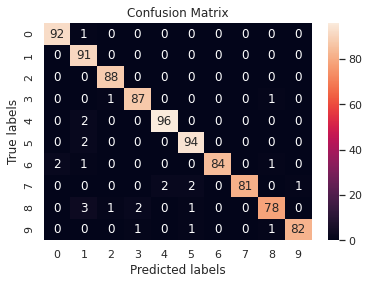

In [48]:
# Best model GridSearch for RBF
best_svm_rbf_grid = svm.SVC(kernel="rbf", C=best_c_rbf, gamma=best_gamma_rbf)
best_svm_rbf_grid.fit(X=x_train, y=y_train)

# Applying prediction to test set
y_pred_test_rbf = best_svm_rbf_grid.predict(x_test)


# Applying accuracy and precision
acc_best_svm_rbf_test = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test_rbf)
print(f"The accuracy of the best SVM RBF model with GridSearch for the test set is {acc_best_svm_rbf_test}")

# Confusion matrix
cm_best_svm_rbf_test = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_test_rbf)
ax= plt.subplot()
sns.heatmap(cm_best_svm_rbf_test, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')


The accuracy of the best SVM RBF model with RandomSearch for the test set is 0.9721913236929922


Text(0.5, 1.0, 'Confusion Matrix')

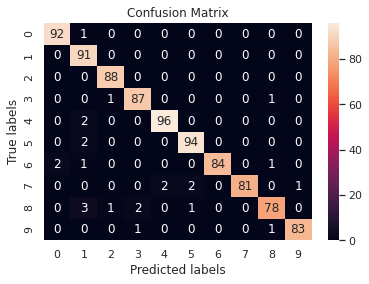

In [49]:
# Best model Random for RBF
best_svm_rbf_random_search = svm.SVC(kernel="rbf", C=best_c_rbf_random_search, gamma=best_gamma_rbf_random_search)
best_svm_rbf_random_search.fit(X=x_train, y=y_train)

# Applying prediction to test set
y_pred_test_rbf_random_search = best_svm_rbf_random_search.predict(x_test)


# Applying accuracy and precision
acc_best_svm_rbf_test_random_search = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test_rbf_random_search)
print(f"The accuracy of the best SVM RBF model with RandomSearch for the test set is {acc_best_svm_rbf_test_random_search}")

# Confusion matrix
cm_best_svm_rbf_test_random_search = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_test_rbf_random_search)
ax= plt.subplot()
sns.heatmap(cm_best_svm_rbf_test_random_search, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')